In [1]:
pwd

'c:\\Users\\xavie\\P7\\P7_ML_model'

# 1 Intro

Notebook dédié à l'entrainement du modèle de ML
- sur base application_train (train_V1.csv)
- dummy classifier
- modèles de classification: Regression Logistique, Random Forest, LGBM, XGBooost
- transformation des variables catégorielles via OneHotEncoder puis via booléen (quand possible)
- gestion de classes non équilibrées(RandomUnderSampler)


## 1.1. Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour, ClusterCentroids,EditedNearestNeighbours, AllKNN, TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as Pipeline_imb
import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from xgboost import XGBClassifier
import xgboost as xgb
import mlflow
from mlflow import log_metric, log_param, log_artifacts, log_metrics
from mlflow.models import infer_signature
from mlflow.sklearn import log_model
import os
import tempfile
import datetime
from datetime import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import pickle
import yellowbrick
from yellowbrick import ROCAUC

## 1.2 Fonctions utiles / set-up

In [3]:
from src.fonctions import *

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
DISPLAY=True

"""If Dispaly == False then all cell starting starting with 'If Display=True' won't be ran.
Else they will

This short function allows to by-pass instructions which are long to run (ex MSNO on huge dataset or sns.pairplot)"""

"If Dispaly == False then all cell starting starting with 'If Display=True' won't be ran.\nElse they will\n\nThis short function allows to by-pass instructions which are long to run (ex MSNO on huge dataset or sns.pairplot)"

# 2 Data

## 2.1 Import and display

In [6]:
train_V1=pd.read_csv('../train_V1.csv')

In [5]:
train_V2=pd.read_csv('../train_V2.csv')

In [7]:
train_V1.shape

(307490, 23)

In [8]:
train_V1.head()

,SK_ID_CURR,TARGET,FLAG_OWN_CAR,OWN_CAR_AGE,FLAG_OWN_REALTY,NAME_HOUSING_TYPE,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,NAME_EDUCATION_TYPE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,client_age,client_prof_exp,Cash_loans,GENDER_FEMALE,active_client,relationship
0,100002,1,0,NaN,1,House / apartment,202500.0,406597.5,24700.5,351000.0,Working,Single / not married,Secondary / secondary special,1.0,0.083037,0.262949,0.139376,25,2.0,1,0,1,0
1,100003,0,0,NaN,0,House / apartment,270000.0,1293502.5,35698.5,1129500.0,State servant,Married,Higher education,2.0,0.311267,0.622246,NaN,45,3.0,1,1,1,1
2,100004,0,1,26.0,1,House / apartment,67500.0,135000.0,6750.0,135000.0,Working,Single / not married,Secondary / secondary special,1.0,NaN,0.555912,0.729567,52,1.0,0,0,1,0
3,100006,0,0,NaN,1,House / apartment,135000.0,312682.5,29686.5,297000.0,Working,Civil marriage,Secondary / secondary special,2.0,NaN,0.650442,NaN,52,8.0,1,1,1,1
4,100007,0,0,NaN,1,House / apartment,121500.0,513000.0,21865.5,513000.0,Working,Single / not married,Secondary / secondary special,1.0,NaN,0.322738,NaN,54,8.0,1,0,1,0


Select only 20% du dataset pour accelerer divers fits ci dessous

In [9]:
train_V1=train_V1.sample(frac=0.2)
train_V1.shape

(61498, 23)

# 3 Phase 0: MachineLearning / Baseline
- Sur base Application Train
- Dummy Classifier

## 3.1. Séparation du jeu de données (features: X / target:y)
 et suppression de colonnes inutiles

In [10]:
X=train_V1.drop(['SK_ID_CURR','TARGET','OWN_CAR_AGE','NAME_HOUSING_TYPE','AMT_GOODS_PRICE','active_client','relationship'],axis=1)
X.shape

(61498, 16)

In [11]:
y=train_V1['TARGET']
y.shape

(61498,)

In [12]:
num_feat=X.select_dtypes(exclude=object).columns.to_list()
num_feat

['FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'client_age',
 'client_prof_exp',
 'Cash_loans',
 'GENDER_FEMALE']

In [13]:
cat_feat=X.select_dtypes(include=object).columns.to_list()
cat_feat

['NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_EDUCATION_TYPE']

## 3.2 Train-test split

In [14]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [15]:
print('Train set:',X_train.shape)
print('Test set:',X_test.shape)
print('Train target:',y_train.shape)
print('Test target:',y_test.shape)

Train set: (49198, 16)
Test set: (12300, 16)
Train target: (49198,)
Test target: (12300,)


## 3.3 Entrainement du DummyClassifier

In [16]:
dc=DummyClassifier()

In [17]:
dc.fit(X_train,y_train)

DummyClassifier()

In [18]:
dc_pred=dc.predict(X_test)

In [19]:
acc=accuracy_score(y_test, dc_pred)
acc

0.9191056910569105

In [20]:
error=1-dc.score(X_test,y_test)
error

0.08089430894308947

In [21]:
1-acc


0.08089430894308947

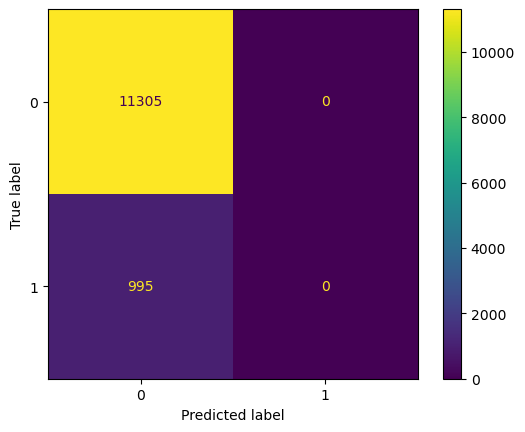

In [22]:
ConfusionMatrixDisplay(confusion_matrix(y_test,dc_pred)).plot()

In [23]:
print_score(y_test, dc_pred)

Accuracy score = 0.9191056910569105
Precision score = 0.0
Recall score = 0.0
F1 score = 0.0
ROC AUC score = 0.5


## 3.5 Log MLFlow

In [90]:
params={}

In [91]:
metrics={"accuracy": accuracy_score(y_test, dc_pred), "ROC AUC": roc_auc_score(y_test, dc_pred)}

In [92]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

In [93]:
mlflow.set_experiment('credit_default_learning')

2024/02/15 16:51:05 INFO mlflow.tracking.fluent: Experiment with name 'credit_default_learning' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/773495734063755611', creation_time=1708012265862, experiment_id='773495734063755611', last_update_time=1708012265862, lifecycle_stage='active', name='credit_default_learning', tags={}>

In [94]:
with mlflow.start_run():
       
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metrics(metrics)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "DummyClassifier for credit default")

    # Infer the model signature
    #signature = infer_signature(X_train, dc.predict(X_train))

    # Log the model

    mlflow.sklearn.log_model(
        sk_model=dc,
        artifact_path="pret_a_depenser",
        #signature=signature,
        input_example=X_train.iloc[:10],
        registered_model_name="tracking-dummy_classifier",
    )


Registered model 'tracking-dummy_classifier' already exists. Creating a new version of this model...
2024/02/15 16:51:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tracking-dummy_classifier, version 2
Created version '2' of model 'tracking-dummy_classifier'.


# 4 V1: Autres modèles et pipeline sur base train_V1

Pour le pipeline:
- sampler: RandomUnderSampler() (imblearn) 
- transformer: OHE pour cat_feat / log pour feat AMT
- imputer: SimpleImputer('median')
- scaler: StandardScaler()
- estimator = DummyClassifier(), LogReg(), RF(),LightGBM, XGBoost

Pour les metrics: priotité au ROC aUC
récupération de F1, recall, accuracy, precision

Et 'speci: fonction créée pour calculer spécificité (TN / (TN+FP)) qui doit être le + grand possible 


#### Transformer

In [7]:
log_fct = FunctionTransformer(np.log1p)

In [25]:
transformer= ColumnTransformer(transformers=
                               [
                               ('OneHot',OneHotEncoder(sparse=False,handle_unknown='ignore'),cat_feat),
                               ('num',log_fct,['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY'])                            
                               ],
                               remainder='passthrough'
                             )
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('OneHot',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS',
                                  'NAME_EDUCATION_TYPE']),
                                ('num',
                                 FunctionTransformer(func=<ufunc 'log1p'>),
                                 ['AMT_INCOME_TOTAL', 'AMT_CREDIT',
                                  'AMT_ANNUITY'])])

#### Pipeline

In [26]:
pipeline=Pipeline_imb([
    ('sampler',RandomUnderSampler()),
    ('transformer',transformer),
    ('imputer',SimpleImputer()),
    ('scaler',StandardScaler()),    
    ('estimator',LogisticRegression())
])
pipeline

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OneHot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['NAME_INCOME_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_EDUCATION_TYPE']),
                                                 ('num',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  ['AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT',
                                                   'AMT_ANNUITY'])])),
                ('imputer', SimpleImputer()), ('scal

#### Paramgrid

- Avec ou sans scaler
- Avec ou sans sampler (ici RandomUnderSampler() car reste plus de 20000 individus de chaque catégorie (A essayer avec d'autres techniques: SMOTE, oversmapling, class_weight...)
- différents estimateurs: LogisticRegression, RandomForest, XGBoost, LightGBM

In [27]:
param_grid={
    'sampler':[RandomUnderSampler(), 'passthrough'],
    'scaler':[StandardScaler(),'passthrough'],    
    'estimator':[LogisticRegression(),RandomForestClassifier(),LGBMClassifier(),XGBClassifier()]
}

#### GridsearchCV

In [17]:
scoring = {
        'roc_auc': 'roc_auc',
        'accuracy': 'accuracy',
        'f1': 'f1',
        'recall':'recall',
        'precision':'precision',
        'speci': (make_scorer(my_specificity_score,))# greater_is_better=False,))
}

In [29]:
grid= GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    #scoring=('roc_auc','accuracy','f1','recall','precision'),
    scoring=scoring,
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit='roc_auc')

In [37]:
if DISPLAY:
    grid.fit(X,y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Info] Number of positive: 5076, number of negative: 56422
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1655
[LightGBM] [Info] Number of data points in the train set: 61498, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082539 -> initscore=-2.408336
[LightGBM] [Info] Start training from score -2.408336


In [38]:
if DISPLAY:
    res=result(grid, log_target=1)
    res.sort_values(by='mean_test_roc_auc',ascending=False).head(5)

In [39]:
RES=pd.DataFrame()

In [40]:
RES=pd.concat([RES, res],axis=0, ignore_index=True)

In [41]:
RES.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,mean_test_speci,std_test_speci,rank_test_speci,mean_train_speci,std_train_speci,log_target,transf_feat,features
0,0.12,0.01,0.11,0.00,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,2,0.74,0.0,0.68,0.00,11,0.68,0.00,0.26,0.00,1,0.26,0.00,0.67,0.02,1,0.68,0.00,0.16,0.00,9,0.16,0.00,0.68,0.01,11,0.68,0.00,1,0,
1,0.25,0.02,0.13,0.01,LogisticRegression(),RandomUnderSampler(),passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,6,0.74,0.0,0.68,0.00,9,0.68,0.00,0.26,0.00,2,0.26,0.00,0.66,0.01,4,0.67,0.00,0.16,0.00,10,0.16,0.00,0.68,0.00,9,0.68,0.00,1,0,
2,0.69,0.03,0.14,0.03,LogisticRegression(),passthrough,StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,4,0.74,0.0,0.92,0.00,3,0.92,0.00,0.02,0.00,13,0.02,0.00,0.01,0.00,13,0.01,0.00,0.48,0.09,4,0.47,0.03,1.00,0.00,4,1.00,0.00,1,0,
3,1.25,0.05,0.09,0.00,LogisticRegression(),passthrough,passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,5,0.74,0.0,0.92,0.00,2,0.92,0.00,0.02,0.01,14,0.02,0.00,0.01,0.00,14,0.01,0.00,0.49,0.10,2,0.47,0.02,1.00,0.00,3,1.00,0.00,1,0,
4,1.94,0.05,0.65,0.03,RandomForestClassifier(),RandomUnderSampler(),StandardScaler(),"{'estimator': RandomForestClassifier(), 'sampl...",0.72,0.01,12,0.98,0.0,0.68,0.00,12,0.73,0.01,0.25,0.00,6,0.38,0.01,0.66,0.01,5,1.00,0.00,0.16,0.00,14,0.23,0.00,0.68,0.00,12,0.71,0.01,1,0,
5,1.80,0.09,0.64,0.05,RandomForestClassifier(),RandomUnderSampler(),passthrough,"{'estimator': RandomForestClassifier(), 'sampl...",0.72,0.01,11,0.98,0.0,0.68,0.01,10,0.73,0.00,0.25,0.01,4,0.38,0.00,0.66,0.01,8,1.00,0.00,0.16,0.00,11,0.24,0.00,0.68,0.01,10,0.71,0.00,1,0,
6,11.57,0.44,0.73,0.03,RandomForestClassifier(),passthrough,StandardScaler(),"{'estimator': RandomForestClassifier(), 'sampl...",0.71,0.00,15,1.00,0.0,0.92,0.00,1,1.00,0.00,0.01,0.00,15,1.00,0.00,0.01,0.00,15,1.00,0.00,0.55,0.11,1,1.00,0.00,1.00,0.00,1,1.00,0.00,1,0,
7,11.37,0.49,0.75,0.05,RandomForestClassifier(),passthrough,passthrough,"{'estimator': RandomForestClassifier(), 'sampl...",0.71,0.00,16,1.00,0.0,0.92,0.00,6,1.00,0.00,0.01,0.00,16,1.00,0.00,0.00,0.00,16,1.00,0.00,0.39,0.05,6,1.00,0.00,1.00,0.00,2,1.00,0.00,1,0,
8,16.60,1.08,0.15,0.01,LGBMClassifier(),RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.73,0.00,7,0.83,0.0,0.67,0.01,13,0.70,0.00,0.25,0.00,3,0.31,0.00,0.67,0.01,2,0.81,0.00,0.16,0.00,12,0.19,0.00,0.67,0.01,13,0.69,0.00,1,0,
9,7.55,4.01,0.15,0.02,LGBMClassifier(),RandomUnderSampler(),passthrough,"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.73,0.00,8,0.83,0.0,0.67,0.01,14,0.70,0.01,0.25,0.00,5,0.31,0.00,0.67,0.01,3,0.81,0.01,0.16,0.00,13,0.19,0.00,0.67,0.01,14,0.69,0.01,1,0,


#### Log Mlflow

In [42]:
log_results(grid, experiment_name='credit_default_learning',model_name='1st try_with_log_V1')

2024/02/15 22:45:13 INFO mlflow.tracking.fluent: Experiment with name 'credit_default_learning' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model


Registered model '1st try_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:45:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: 1st try_with_log_V1, version 17
Created version '17' of model '1st try_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/04f5a9ab17934aaaa1ca7d817988efd8/artifacts
runID: 04f5a9ab17934aaaa1ca7d817988efd8
Logging parameters
Logging metrics
Logging model


Registered model '1st try_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:45:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: 1st try_with_log_V1, version 18
Created version '18' of model '1st try_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/b5080c3244c94f668b754ddccf206a25/artifacts
runID: b5080c3244c94f668b754ddccf206a25
Logging parameters
Logging metrics
Logging model


Registered model '1st try_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:45:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: 1st try_with_log_V1, version 19
Created version '19' of model '1st try_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/57eb22a579f547dc9a4d78813fef1d15/artifacts
runID: 57eb22a579f547dc9a4d78813fef1d15
Logging parameters
Logging metrics
Logging model


Registered model '1st try_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:45:18 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: 1st try_with_log_V1, version 20
Created version '20' of model '1st try_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/d31447acd2ef44328e486ed0a5683503/artifacts
runID: d31447acd2ef44328e486ed0a5683503
Logging parameters
Logging metrics
Logging model


Registered model '1st try_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:45:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: 1st try_with_log_V1, version 21
Created version '21' of model '1st try_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/19d17b478404463aabf13124dfb8a84f/artifacts
runID: 19d17b478404463aabf13124dfb8a84f
Logging parameters
Logging metrics
Logging model


Registered model '1st try_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:45:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: 1st try_with_log_V1, version 22
Created version '22' of model '1st try_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/b9536ae251ae4894a11d82abd6b6595d/artifacts
runID: b9536ae251ae4894a11d82abd6b6595d
Logging parameters
Logging metrics
Logging model


Registered model '1st try_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:45:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: 1st try_with_log_V1, version 23
Created version '23' of model '1st try_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/e9471a023be64e03a1aa9ab647d92a60/artifacts
runID: e9471a023be64e03a1aa9ab647d92a60
Logging parameters
Logging metrics
Logging model


Registered model '1st try_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:45:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: 1st try_with_log_V1, version 24
Created version '24' of model '1st try_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/f75884a03f3e4dc8a7b89cd4a15adbe1/artifacts
runID: f75884a03f3e4dc8a7b89cd4a15adbe1
Logging parameters
Logging metrics
Logging model


Registered model '1st try_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:45:22 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: 1st try_with_log_V1, version 25
Created version '25' of model '1st try_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/a100a131b06b44948e5ca7ee375abfb4/artifacts
runID: a100a131b06b44948e5ca7ee375abfb4
Logging parameters
Logging metrics
Logging model


Registered model '1st try_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:45:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: 1st try_with_log_V1, version 26
Created version '26' of model '1st try_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/1473344f6c894c4c9ebb0a42eec241bc/artifacts
runID: 1473344f6c894c4c9ebb0a42eec241bc
Logging parameters
Logging metrics
Logging model


Registered model '1st try_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:45:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: 1st try_with_log_V1, version 27
Created version '27' of model '1st try_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/459042d8a64c4ed4a6d560159622094f/artifacts
runID: 459042d8a64c4ed4a6d560159622094f
Logging parameters
Logging metrics
Logging model


Registered model '1st try_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:45:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: 1st try_with_log_V1, version 28
Created version '28' of model '1st try_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/16761afcb88f48058db45379a8dc7115/artifacts
runID: 16761afcb88f48058db45379a8dc7115
Logging parameters
Logging metrics
Logging model


Registered model '1st try_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:45:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: 1st try_with_log_V1, version 29
Created version '29' of model '1st try_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/dfc64ef6d9364349941d3b1908363da8/artifacts
runID: dfc64ef6d9364349941d3b1908363da8
Logging parameters
Logging metrics
Logging model


Registered model '1st try_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:45:26 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: 1st try_with_log_V1, version 30
Created version '30' of model '1st try_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/654ac81f02384ca5b45d86f967c0cb5c/artifacts
runID: 654ac81f02384ca5b45d86f967c0cb5c
Logging parameters
Logging metrics
Logging model


Registered model '1st try_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:45:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: 1st try_with_log_V1, version 31
Created version '31' of model '1st try_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/54981698c2874e148b08dbfa5cfa40dc/artifacts
runID: 54981698c2874e148b08dbfa5cfa40dc
Logging parameters
Logging metrics
Logging model


Registered model '1st try_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:45:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: 1st try_with_log_V1, version 32
Created version '32' of model '1st try_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/e5241352bedc4ff59a358068f46ab648/artifacts
runID: e5241352bedc4ff59a358068f46ab648


#### Même chose sans log

In [30]:
transformer2=ColumnTransformer(transformers=
                               [
                               ('OneHot',OneHotEncoder(sparse=False,handle_unknown='ignore'),cat_feat),
                               ],
                               remainder='passthrough'
                             )
transformer2

ColumnTransformer(remainder='passthrough',
                  transformers=[('OneHot',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS',
                                  'NAME_EDUCATION_TYPE'])])

In [31]:
pipeline2=Pipeline_imb([
    ('sampler',RandomUnderSampler(replacement=True)),
    ('transformer',transformer2),
    ('imputer',SimpleImputer()),
    ('scaler',StandardScaler()),
    ('estimator',LogisticRegression())
])
pipeline2

Pipeline(steps=[('sampler', RandomUnderSampler(replacement=True)),
                ('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OneHot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['NAME_INCOME_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_EDUCATION_TYPE'])])),
                ('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('estimator', LogisticRegression())])

In [32]:
grid= GridSearchCV(
    pipeline2,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit='roc_auc')

In [46]:
if DISPLAY:
    grid.fit(X,y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Info] Number of positive: 5076, number of negative: 56422
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 61498, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082539 -> initscore=-2.408336
[LightGBM] [Info] Start training from score -2.408336


In [47]:
res=result(grid, log_target=0)
res.sort_values(by='mean_test_roc_auc',ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,mean_test_speci,std_test_speci,rank_test_speci,mean_train_speci,std_train_speci,log_target,transf_feat,features
0,0.13,0.02,0.12,0.02,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,2,0.74,0.0,0.68,0.00,10,0.68,0.0,0.26,0.00,1,0.26,0.00,0.68,0.01,2,0.68,0.00,0.16,0.00,8,0.16,0.00,0.68,0.01,11,0.68,0.0,0,0,
2,0.66,0.07,0.14,0.01,LogisticRegression(),passthrough,StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,4,0.74,0.0,0.92,0.00,3,0.92,0.0,0.02,0.00,13,0.02,0.00,0.01,0.00,13,0.01,0.00,0.45,0.11,3,0.45,0.03,1.00,0.00,4,1.00,0.0,0,0,
10,6.01,0.96,0.15,0.04,LGBMClassifier(),passthrough,StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.74,0.01,3,0.86,0.0,0.92,0.00,6,0.92,0.0,0.03,0.01,11,0.07,0.01,0.01,0.00,11,0.04,0.00,0.44,0.06,4,0.91,0.01,1.00,0.00,6,1.00,0.0,0,0,
11,17.58,2.53,0.13,0.01,LGBMClassifier(),passthrough,passthrough,"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.74,0.01,1,0.86,0.0,0.92,0.00,4,0.92,0.0,0.02,0.00,12,0.08,0.01,0.01,0.00,12,0.04,0.01,0.47,0.12,2,0.89,0.03,1.00,0.00,5,1.00,0.0,0,0,
4,1.80,0.03,0.62,0.03,RandomForestClassifier(),RandomUnderSampler(),StandardScaler(),"{'estimator': RandomForestClassifier(), 'sampl...",0.73,0.01,9,0.98,0.0,0.68,0.01,9,0.73,0.0,0.25,0.00,5,0.38,0.00,0.65,0.02,7,1.00,0.00,0.16,0.00,12,0.24,0.00,0.68,0.01,9,0.71,0.0,0,0,


In [48]:
RES=pd.concat([RES, res],axis=0, ignore_index=True)
RES.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,mean_test_speci,std_test_speci,rank_test_speci,mean_train_speci,std_train_speci,log_target,transf_feat,features
0,0.12,0.01,0.11,0.00,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,2,0.74,0.0,0.68,0.00,11,0.68,0.00,0.26,0.00,1,0.26,0.00,0.67,0.02,1,0.68,0.00,0.16,0.00,9,0.16,0.00,0.68,0.01,11,0.68,0.00,1,0,
1,0.25,0.02,0.13,0.01,LogisticRegression(),RandomUnderSampler(),passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,6,0.74,0.0,0.68,0.00,9,0.68,0.00,0.26,0.00,2,0.26,0.00,0.66,0.01,4,0.67,0.00,0.16,0.00,10,0.16,0.00,0.68,0.00,9,0.68,0.00,1,0,
2,0.69,0.03,0.14,0.03,LogisticRegression(),passthrough,StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,4,0.74,0.0,0.92,0.00,3,0.92,0.00,0.02,0.00,13,0.02,0.00,0.01,0.00,13,0.01,0.00,0.48,0.09,4,0.47,0.03,1.00,0.00,4,1.00,0.00,1,0,
3,1.25,0.05,0.09,0.00,LogisticRegression(),passthrough,passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,5,0.74,0.0,0.92,0.00,2,0.92,0.00,0.02,0.01,14,0.02,0.00,0.01,0.00,14,0.01,0.00,0.49,0.10,2,0.47,0.02,1.00,0.00,3,1.00,0.00,1,0,
4,1.94,0.05,0.65,0.03,RandomForestClassifier(),RandomUnderSampler(),StandardScaler(),"{'estimator': RandomForestClassifier(), 'sampl...",0.72,0.01,12,0.98,0.0,0.68,0.00,12,0.73,0.01,0.25,0.00,6,0.38,0.01,0.66,0.01,5,1.00,0.00,0.16,0.00,14,0.23,0.00,0.68,0.00,12,0.71,0.01,1,0,
5,1.80,0.09,0.64,0.05,RandomForestClassifier(),RandomUnderSampler(),passthrough,"{'estimator': RandomForestClassifier(), 'sampl...",0.72,0.01,11,0.98,0.0,0.68,0.01,10,0.73,0.00,0.25,0.01,4,0.38,0.00,0.66,0.01,8,1.00,0.00,0.16,0.00,11,0.24,0.00,0.68,0.01,10,0.71,0.00,1,0,
6,11.57,0.44,0.73,0.03,RandomForestClassifier(),passthrough,StandardScaler(),"{'estimator': RandomForestClassifier(), 'sampl...",0.71,0.00,15,1.00,0.0,0.92,0.00,1,1.00,0.00,0.01,0.00,15,1.00,0.00,0.01,0.00,15,1.00,0.00,0.55,0.11,1,1.00,0.00,1.00,0.00,1,1.00,0.00,1,0,
7,11.37,0.49,0.75,0.05,RandomForestClassifier(),passthrough,passthrough,"{'estimator': RandomForestClassifier(), 'sampl...",0.71,0.00,16,1.00,0.0,0.92,0.00,6,1.00,0.00,0.01,0.00,16,1.00,0.00,0.00,0.00,16,1.00,0.00,0.39,0.05,6,1.00,0.00,1.00,0.00,2,1.00,0.00,1,0,
8,16.60,1.08,0.15,0.01,LGBMClassifier(),RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.73,0.00,7,0.83,0.0,0.67,0.01,13,0.70,0.00,0.25,0.00,3,0.31,0.00,0.67,0.01,2,0.81,0.00,0.16,0.00,12,0.19,0.00,0.67,0.01,13,0.69,0.00,1,0,
9,7.55,4.01,0.15,0.02,LGBMClassifier(),RandomUnderSampler(),passthrough,"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.73,0.00,8,0.83,0.0,0.67,0.01,14,0.70,0.01,0.25,0.00,5,0.31,0.00,0.67,0.01,3,0.81,0.01,0.16,0.00,13,0.19,0.00,0.67,0.01,14,0.69,0.01,1,0,


In [49]:
grid.best_params_

{'estimator': LGBMClassifier(),
 'sampler': 'passthrough',
 'scaler': 'passthrough'}

#### MLflow

In [50]:
log_results(grid,experiment_name='credit_default_learning',model_name='P7_sans_log_V1')

Logging parameters
Logging metrics
Logging model


Registered model 'P7_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:52:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_sans_log_V1, version 17
Created version '17' of model 'P7_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/f9df7beb8f78469091b49a40725d5992/artifacts
runID: f9df7beb8f78469091b49a40725d5992
Logging parameters
Logging metrics
Logging model


Registered model 'P7_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:52:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_sans_log_V1, version 18
Created version '18' of model 'P7_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/f00c72044dec4246b0024e789cc48733/artifacts
runID: f00c72044dec4246b0024e789cc48733
Logging parameters
Logging metrics
Logging model


Registered model 'P7_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:52:44 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_sans_log_V1, version 19
Created version '19' of model 'P7_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/5afbf423f94741088a97bf3cb12ad6a1/artifacts
runID: 5afbf423f94741088a97bf3cb12ad6a1
Logging parameters
Logging metrics
Logging model


Registered model 'P7_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:52:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_sans_log_V1, version 20
Created version '20' of model 'P7_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/a332e81b96694b6784351fd7dce0b66c/artifacts
runID: a332e81b96694b6784351fd7dce0b66c
Logging parameters
Logging metrics
Logging model


Registered model 'P7_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:52:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_sans_log_V1, version 21
Created version '21' of model 'P7_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/ff4d7c27c7bf4f8fb51af2c96808a166/artifacts
runID: ff4d7c27c7bf4f8fb51af2c96808a166
Logging parameters
Logging metrics
Logging model


Registered model 'P7_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:52:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_sans_log_V1, version 22
Created version '22' of model 'P7_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/8d5d98a614464bc893433da168f976fa/artifacts
runID: 8d5d98a614464bc893433da168f976fa
Logging parameters
Logging metrics
Logging model


Registered model 'P7_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:52:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_sans_log_V1, version 23
Created version '23' of model 'P7_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/c7e1f2b3db534a02bead2ad7d33d8952/artifacts
runID: c7e1f2b3db534a02bead2ad7d33d8952
Logging parameters
Logging metrics
Logging model


Registered model 'P7_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:52:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_sans_log_V1, version 24
Created version '24' of model 'P7_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/092974a13d784387a5a0425256c8fa79/artifacts
runID: 092974a13d784387a5a0425256c8fa79
Logging parameters
Logging metrics
Logging model


Registered model 'P7_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:52:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_sans_log_V1, version 25
Created version '25' of model 'P7_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/becce4a8821c48dcbc4034f67cfb64c3/artifacts
runID: becce4a8821c48dcbc4034f67cfb64c3
Logging parameters
Logging metrics
Logging model


Registered model 'P7_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:52:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_sans_log_V1, version 26
Created version '26' of model 'P7_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/750f1566c8c6451f92f1ffa63a811e9a/artifacts
runID: 750f1566c8c6451f92f1ffa63a811e9a
Logging parameters
Logging metrics
Logging model


Registered model 'P7_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:52:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_sans_log_V1, version 27
Created version '27' of model 'P7_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/3f969100b21d422c810731370ac9b934/artifacts
runID: 3f969100b21d422c810731370ac9b934
Logging parameters
Logging metrics
Logging model


Registered model 'P7_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:52:51 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_sans_log_V1, version 28
Created version '28' of model 'P7_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/4a9192d6cbdc487da4e8f03d2d62ee9d/artifacts
runID: 4a9192d6cbdc487da4e8f03d2d62ee9d
Logging parameters
Logging metrics
Logging model


Registered model 'P7_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:52:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_sans_log_V1, version 29
Created version '29' of model 'P7_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/5998e7e0f58b4f60bd9d763d5b7a0205/artifacts
runID: 5998e7e0f58b4f60bd9d763d5b7a0205
Logging parameters
Logging metrics
Logging model


Registered model 'P7_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:52:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_sans_log_V1, version 30
Created version '30' of model 'P7_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/3658030316464a769e7821c1e18712a4/artifacts
runID: 3658030316464a769e7821c1e18712a4
Logging parameters
Logging metrics
Logging model


Registered model 'P7_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:52:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_sans_log_V1, version 31
Created version '31' of model 'P7_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/af4f3436d96b40b8910471e9fb078939/artifacts
runID: af4f3436d96b40b8910471e9fb078939
Logging parameters
Logging metrics
Logging model


Registered model 'P7_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:52:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_sans_log_V1, version 32
Created version '32' of model 'P7_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/54b33a97306943b5bacc1710cf01a468/artifacts
runID: 54b33a97306943b5bacc1710cf01a468


#### Remplaçons certaines variables par leur booléen (Income type et Family status)

In [33]:
train_V1.columns.to_list()

['SK_ID_CURR',
 'TARGET',
 'FLAG_OWN_CAR',
 'OWN_CAR_AGE',
 'FLAG_OWN_REALTY',
 'NAME_HOUSING_TYPE',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_INCOME_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_EDUCATION_TYPE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'client_age',
 'client_prof_exp',
 'Cash_loans',
 'GENDER_FEMALE',
 'active_client',
 'relationship']

In [34]:
X=train_V1.drop(['SK_ID_CURR','TARGET','OWN_CAR_AGE','NAME_HOUSING_TYPE','AMT_GOODS_PRICE','NAME_INCOME_TYPE','NAME_FAMILY_STATUS'],axis=1)
X.shape

(61498, 16)

In [35]:
y.shape

(61498,)

In [36]:
cat_feat=X.select_dtypes(include=object).columns.to_list()
cat_feat

['NAME_EDUCATION_TYPE']

In [37]:
num_feat

['FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'client_age',
 'client_prof_exp',
 'Cash_loans',
 'GENDER_FEMALE']

#### avec passage au log (transformer)

In [38]:
transformer= ColumnTransformer(transformers=
                               [
                               ('OneHot',OneHotEncoder(sparse=False,handle_unknown='ignore'),cat_feat),
                               ('num',log_fct,['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY'])
                               ],
                               remainder='passthrough'
                             )
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('OneHot',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['NAME_EDUCATION_TYPE']),
                                ('num',
                                 FunctionTransformer(func=<ufunc 'log1p'>),
                                 ['AMT_INCOME_TOTAL', 'AMT_CREDIT',
                                  'AMT_ANNUITY'])])

In [39]:
pipeline=Pipeline_imb([
    ('sampler',RandomUnderSampler(replacement=True)),
    ('transformer',transformer),
    ('imputer',SimpleImputer()),
    ('scaler',StandardScaler()),
    ('estimator',DummyClassifier())
])
pipeline

Pipeline(steps=[('sampler', RandomUnderSampler(replacement=True)),
                ('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OneHot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['NAME_EDUCATION_TYPE']),
                                                 ('num',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  ['AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT',
                                                   'AMT_ANNUITY'])])),
                ('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('estimator', DummyClassifier())])

In [40]:
grid= GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit='roc_auc')

In [59]:
if DISPLAY:
    grid.fit(X,y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Info] Number of positive: 5076, number of negative: 56422
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1634
[LightGBM] [Info] Number of data points in the train set: 61498, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082539 -> initscore=-2.408336
[LightGBM] [Info] Start training from score -2.408336


In [60]:
res=result(grid, log_target=1)
res.sort_values(by='mean_test_roc_auc',ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,mean_test_speci,std_test_speci,rank_test_speci,mean_train_speci,std_train_speci,log_target,transf_feat,features
0,0.17,0.12,0.08,0.02,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,3,0.74,0.0,0.68,0.01,10,0.68,0.00,0.26,0.01,1,0.26,0.00,0.67,0.01,2,0.68,0.00,0.16,0.00,9,0.16,0.00,0.68,0.01,11,0.68,0.00,1,0,
1,0.41,0.12,0.12,0.03,LogisticRegression(),RandomUnderSampler(),passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,4,0.74,0.0,0.68,0.00,9,0.68,0.00,0.26,0.00,2,0.26,0.00,0.67,0.01,3,0.67,0.00,0.16,0.00,10,0.16,0.00,0.68,0.00,10,0.68,0.00,1,0,
2,0.37,0.18,0.26,0.17,LogisticRegression(),passthrough,StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,5,0.74,0.0,0.92,0.00,4,0.92,0.00,0.02,0.00,14,0.02,0.00,0.01,0.00,13,0.01,0.00,0.43,0.10,4,0.44,0.03,1.00,0.00,3,1.00,0.00,1,0,
3,1.18,0.14,0.06,0.00,LogisticRegression(),passthrough,passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,6,0.74,0.0,0.92,0.00,1,0.92,0.00,0.02,0.01,13,0.02,0.00,0.01,0.00,14,0.01,0.00,0.44,0.11,3,0.46,0.03,1.00,0.00,2,1.00,0.00,1,0,
10,11.21,5.60,0.11,0.02,LGBMClassifier(),passthrough,StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.74,0.01,1,0.86,0.0,0.92,0.00,2,0.92,0.00,0.02,0.01,12,0.07,0.01,0.01,0.00,12,0.04,0.00,0.47,0.06,1,0.91,0.02,1.00,0.00,5,1.00,0.00,1,0,
11,13.13,0.32,0.10,0.02,LGBMClassifier(),passthrough,passthrough,"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.74,0.01,2,0.86,0.0,0.92,0.00,5,0.92,0.00,0.02,0.01,11,0.07,0.01,0.01,0.00,11,0.04,0.01,0.45,0.09,2,0.90,0.03,1.00,0.00,6,1.00,0.00,1,0,
8,12.69,0.38,0.13,0.04,LGBMClassifier(),RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.73,0.00,7,0.83,0.0,0.67,0.01,13,0.69,0.00,0.25,0.00,3,0.31,0.00,0.68,0.01,1,0.82,0.01,0.16,0.00,11,0.19,0.00,0.67,0.01,13,0.68,0.00,1,0,
9,6.74,3.97,0.10,0.01,LGBMClassifier(),RandomUnderSampler(),passthrough,"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.73,0.00,8,0.83,0.0,0.67,0.01,14,0.70,0.01,0.25,0.00,6,0.31,0.00,0.67,0.01,5,0.81,0.01,0.15,0.00,14,0.19,0.00,0.67,0.01,14,0.69,0.01,1,0,
14,7.32,0.14,0.09,0.00,"XGBClassifier(base_score=None, booster=None, c...",passthrough,StandardScaler(),"{'estimator': XGBClassifier(base_score=None, b...",0.73,0.00,10,0.91,0.0,0.92,0.00,7,0.93,0.00,0.06,0.01,9,0.23,0.01,0.03,0.00,9,0.13,0.01,0.41,0.06,6,0.96,0.01,1.00,0.00,7,1.00,0.00,1,0,
15,6.47,1.31,0.07,0.01,"XGBClassifier(base_score=None, booster=None, c...",passthrough,passthrough,"{'estimator': XGBClassifier(base_score=None, b...",0.73,0.00,9,0.91,0.0,0.92,0.00,7,0.93,0.00,0.06,0.01,9,0.23,0.01,0.03,0.00,9,0.13,0.01,0.41,0.06,6,0.96,0.01,1.00,0.00,7,1.00,0.00,1,0,


In [61]:
RES=pd.concat([RES, res],axis=0, ignore_index=True)

In [62]:
RES.sort_values(by='mean_test_roc_auc',ascending=False).head(20)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,mean_test_speci,std_test_speci,rank_test_speci,mean_train_speci,std_train_speci,log_target,transf_feat,features
0,0.12,0.01,0.11,0.00,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,2,0.74,0.0,0.68,0.00,11,0.68,0.00,0.26,0.00,1,0.26,0.00,0.67,0.02,1,0.68,0.00,0.16,0.00,9,0.16,0.00,0.68,0.01,11,0.68,0.00,1,0,
10,5.86,1.32,0.15,0.04,LGBMClassifier(),passthrough,StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.74,0.00,1,0.86,0.0,0.92,0.00,5,0.92,0.00,0.03,0.00,12,0.07,0.01,0.01,0.00,12,0.04,0.00,0.47,0.10,5,0.91,0.01,1.00,0.00,6,1.00,0.00,1,0,
26,6.01,0.96,0.15,0.04,LGBMClassifier(),passthrough,StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.74,0.01,3,0.86,0.0,0.92,0.00,6,0.92,0.00,0.03,0.01,11,0.07,0.01,0.01,0.00,11,0.04,0.00,0.44,0.06,4,0.91,0.01,1.00,0.00,6,1.00,0.00,0,0,
27,17.58,2.53,0.13,0.01,LGBMClassifier(),passthrough,passthrough,"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.74,0.01,1,0.86,0.0,0.92,0.00,4,0.92,0.00,0.02,0.00,12,0.08,0.01,0.01,0.00,12,0.04,0.01,0.47,0.12,2,0.89,0.03,1.00,0.00,5,1.00,0.00,0,0,
18,0.66,0.07,0.14,0.01,LogisticRegression(),passthrough,StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,4,0.74,0.0,0.92,0.00,3,0.92,0.00,0.02,0.00,13,0.02,0.00,0.01,0.00,13,0.01,0.00,0.45,0.11,3,0.45,0.03,1.00,0.00,4,1.00,0.00,0,0,
16,0.13,0.02,0.12,0.02,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,2,0.74,0.0,0.68,0.00,10,0.68,0.00,0.26,0.00,1,0.26,0.00,0.68,0.01,2,0.68,0.00,0.16,0.00,8,0.16,0.00,0.68,0.01,11,0.68,0.00,0,0,
32,0.17,0.12,0.08,0.02,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,3,0.74,0.0,0.68,0.01,10,0.68,0.00,0.26,0.01,1,0.26,0.00,0.67,0.01,2,0.68,0.00,0.16,0.00,9,0.16,0.00,0.68,0.01,11,0.68,0.00,1,0,
33,0.41,0.12,0.12,0.03,LogisticRegression(),RandomUnderSampler(),passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,4,0.74,0.0,0.68,0.00,9,0.68,0.00,0.26,0.00,2,0.26,0.00,0.67,0.01,3,0.67,0.00,0.16,0.00,10,0.16,0.00,0.68,0.00,10,0.68,0.00,1,0,
34,0.37,0.18,0.26,0.17,LogisticRegression(),passthrough,StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,5,0.74,0.0,0.92,0.00,4,0.92,0.00,0.02,0.00,14,0.02,0.00,0.01,0.00,13,0.01,0.00,0.43,0.10,4,0.44,0.03,1.00,0.00,3,1.00,0.00,1,0,
1,0.25,0.02,0.13,0.01,LogisticRegression(),RandomUnderSampler(),passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,6,0.74,0.0,0.68,0.00,9,0.68,0.00,0.26,0.00,2,0.26,0.00,0.66,0.01,4,0.67,0.00,0.16,0.00,10,0.16,0.00,0.68,0.00,9,0.68,0.00,1,0,


#### MLflow

In [63]:
log_results(grid,experiment_name='credit_default_learning',model_name='P7_bool_with_log_V1')

Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:54:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V1, version 17
Created version '17' of model 'P7_bool_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/535b6f51621d41e0b782bce1c333faea/artifacts
runID: 535b6f51621d41e0b782bce1c333faea
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:54:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V1, version 18
Created version '18' of model 'P7_bool_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/899d23f855e64cacac7890c65997c193/artifacts
runID: 899d23f855e64cacac7890c65997c193
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:54:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V1, version 19
Created version '19' of model 'P7_bool_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/307039d061184568a9f3b223738d9b91/artifacts
runID: 307039d061184568a9f3b223738d9b91
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:54:22 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V1, version 20
Created version '20' of model 'P7_bool_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/77a79066fccd4e88b91e53ad7e11e5c2/artifacts
runID: 77a79066fccd4e88b91e53ad7e11e5c2
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:54:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V1, version 21
Created version '21' of model 'P7_bool_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/9d208b3b715949fcb0ef0da0544a9acf/artifacts
runID: 9d208b3b715949fcb0ef0da0544a9acf
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:54:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V1, version 22
Created version '22' of model 'P7_bool_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/2c8aefdab793467c96c988db873716fc/artifacts
runID: 2c8aefdab793467c96c988db873716fc
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:54:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V1, version 23
Created version '23' of model 'P7_bool_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/0726e8b26c72446d9661b2c2d08347fb/artifacts
runID: 0726e8b26c72446d9661b2c2d08347fb
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:54:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V1, version 24
Created version '24' of model 'P7_bool_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/f1eefa5efa804d94b0d17a9ba08368cf/artifacts
runID: f1eefa5efa804d94b0d17a9ba08368cf
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:54:26 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V1, version 25
Created version '25' of model 'P7_bool_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/c77c1b43939e48fe809dbae3c7aa9578/artifacts
runID: c77c1b43939e48fe809dbae3c7aa9578
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:54:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V1, version 26
Created version '26' of model 'P7_bool_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/7e2102f60ec848568aa2506d662134ac/artifacts
runID: 7e2102f60ec848568aa2506d662134ac
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:54:28 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V1, version 27
Created version '27' of model 'P7_bool_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/849083080df54eedb136d2786170a3e5/artifacts
runID: 849083080df54eedb136d2786170a3e5
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:54:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V1, version 28
Created version '28' of model 'P7_bool_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/8ed24f46e48144169a888fe5217aa323/artifacts
runID: 8ed24f46e48144169a888fe5217aa323
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:54:30 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V1, version 29
Created version '29' of model 'P7_bool_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/6d619745e9024f56a12893e55f448018/artifacts
runID: 6d619745e9024f56a12893e55f448018
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:54:30 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V1, version 30
Created version '30' of model 'P7_bool_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/50c1abd2a84e45a39b14ce3d2d5eb149/artifacts
runID: 50c1abd2a84e45a39b14ce3d2d5eb149
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:54:31 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V1, version 31
Created version '31' of model 'P7_bool_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/f637e23b25744bf1a9b14781653bc536/artifacts
runID: f637e23b25744bf1a9b14781653bc536
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:54:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V1, version 32
Created version '32' of model 'P7_bool_with_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/565efc523f0a40e99f19ac9d5da6e5c7/artifacts
runID: 565efc523f0a40e99f19ac9d5da6e5c7


#### sans passage au log (transformer2)

In [41]:
transformer2=ColumnTransformer(transformers=
                               [
                               ('OneHot',OneHotEncoder(sparse=False,handle_unknown='ignore'),cat_feat),
                               ],
                               remainder='passthrough'
                             )
transformer2

ColumnTransformer(remainder='passthrough',
                  transformers=[('OneHot',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['NAME_EDUCATION_TYPE'])])

In [42]:
pipeline2=Pipeline_imb([
    ('sampler',RandomUnderSampler(replacement=True)),
    ('transformer',transformer2),
    ('imputer',SimpleImputer()),
    ('scaler',StandardScaler()),
    ('estimator',DummyClassifier())
])
pipeline2

Pipeline(steps=[('sampler', RandomUnderSampler(replacement=True)),
                ('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OneHot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['NAME_EDUCATION_TYPE'])])),
                ('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('estimator', DummyClassifier())])

In [43]:
grid= GridSearchCV(
    pipeline2,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit='roc_auc')

In [67]:
if DISPLAY:
    grid.fit(X,y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Info] Number of positive: 5076, number of negative: 56422
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1591
[LightGBM] [Info] Number of data points in the train set: 61498, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082539 -> initscore=-2.408336
[LightGBM] [Info] Start training from score -2.408336


In [68]:
res=result(grid, log_target=0)
res.sort_values(by='mean_test_roc_auc',ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,mean_test_speci,std_test_speci,rank_test_speci,mean_train_speci,std_train_speci,log_target,transf_feat,features
0,0.07,0.01,0.11,0.01,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,3,0.74,0.0,0.68,0.01,10,0.68,0.00,0.26,0.00,1,0.26,0.00,0.67,0.01,3,0.67,0.00,0.16,0.00,8,0.16,0.00,0.68,0.01,10,0.68,0.00,0,0,
2,0.45,0.07,0.11,0.03,LogisticRegression(),passthrough,StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,4,0.74,0.0,0.92,0.00,3,0.92,0.00,0.02,0.01,13,0.02,0.00,0.01,0.00,13,0.01,0.00,0.41,0.11,3,0.43,0.03,1.00,0.00,3,1.00,0.00,0,0,
10,7.47,2.28,0.09,0.01,LGBMClassifier(),passthrough,StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.74,0.01,2,0.86,0.0,0.92,0.00,5,0.92,0.00,0.02,0.00,12,0.07,0.01,0.01,0.00,12,0.04,0.01,0.44,0.05,2,0.90,0.02,1.00,0.00,5,1.00,0.00,0,0,
11,16.18,0.30,0.10,0.02,LGBMClassifier(),passthrough,passthrough,"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.74,0.01,1,0.86,0.0,0.92,0.00,2,0.92,0.00,0.03,0.01,11,0.07,0.01,0.01,0.00,11,0.04,0.00,0.46,0.10,1,0.91,0.02,1.00,0.00,6,1.00,0.00,0,0,
4,2.07,0.19,0.64,0.04,RandomForestClassifier(),RandomUnderSampler(),StandardScaler(),"{'estimator': RandomForestClassifier(), 'sampl...",0.73,0.01,9,0.98,0.0,0.68,0.01,9,0.73,0.00,0.26,0.01,2,0.38,0.00,0.66,0.01,4,1.00,0.00,0.16,0.01,9,0.24,0.00,0.68,0.01,9,0.71,0.00,0,0,
8,16.80,1.25,0.10,0.01,LGBMClassifier(),RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.73,0.00,5,0.83,0.0,0.67,0.01,13,0.69,0.00,0.25,0.01,4,0.30,0.00,0.68,0.01,1,0.82,0.01,0.15,0.00,11,0.18,0.00,0.67,0.01,13,0.68,0.00,0,0,
9,8.87,3.36,0.11,0.02,LGBMClassifier(),RandomUnderSampler(),passthrough,"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.73,0.00,6,0.83,0.0,0.67,0.01,12,0.69,0.01,0.25,0.00,3,0.30,0.00,0.67,0.02,2,0.81,0.01,0.15,0.00,10,0.19,0.00,0.67,0.01,12,0.68,0.01,0,0,
14,8.60,0.20,0.09,0.00,"XGBClassifier(base_score=None, booster=None, c...",passthrough,StandardScaler(),"{'estimator': XGBClassifier(base_score=None, b...",0.73,0.00,7,0.91,0.0,0.92,0.00,7,0.93,0.00,0.05,0.01,9,0.24,0.01,0.03,0.01,9,0.14,0.01,0.38,0.06,6,0.96,0.01,1.00,0.00,7,1.00,0.00,0,0,
15,8.07,0.55,0.07,0.00,"XGBClassifier(base_score=None, booster=None, c...",passthrough,passthrough,"{'estimator': XGBClassifier(base_score=None, b...",0.73,0.00,8,0.91,0.0,0.92,0.00,7,0.93,0.00,0.05,0.01,9,0.24,0.01,0.03,0.01,9,0.14,0.01,0.38,0.06,6,0.96,0.01,1.00,0.00,7,1.00,0.00,0,0,
5,2.11,0.12,0.64,0.03,RandomForestClassifier(),RandomUnderSampler(),passthrough,"{'estimator': RandomForestClassifier(), 'sampl...",0.72,0.00,10,0.98,0.0,0.67,0.01,11,0.73,0.00,0.25,0.00,5,0.38,0.00,0.66,0.01,6,1.00,0.00,0.15,0.00,12,0.23,0.00,0.67,0.01,11,0.70,0.00,0,0,


In [69]:
RES=pd.concat([RES, res],axis=0, ignore_index=True)

#### MLflow

In [70]:
log_results(grid,experiment_name='credit_default_learning',model_name='P7_bool_sans_log_V1')

Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:55:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V1, version 17
Created version '17' of model 'P7_bool_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/8cab5443f0e840c88897d2ce6d3eedc0/artifacts
runID: 8cab5443f0e840c88897d2ce6d3eedc0
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:55:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V1, version 18
Created version '18' of model 'P7_bool_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/b4200dc871f14cfaa733f73576e33f9f/artifacts
runID: b4200dc871f14cfaa733f73576e33f9f
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:55:44 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V1, version 19
Created version '19' of model 'P7_bool_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/eb2a6220bf774af08f9f60244eee3b5f/artifacts
runID: eb2a6220bf774af08f9f60244eee3b5f
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:55:44 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V1, version 20
Created version '20' of model 'P7_bool_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/85ed466c6a9f49ee82c2c55459ce32fc/artifacts
runID: 85ed466c6a9f49ee82c2c55459ce32fc
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:55:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V1, version 21
Created version '21' of model 'P7_bool_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/795183b09a6b4bcb9401da28702f2bfd/artifacts
runID: 795183b09a6b4bcb9401da28702f2bfd
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:55:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V1, version 22
Created version '22' of model 'P7_bool_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/c8590ca3420d49f29e96b75295a13263/artifacts
runID: c8590ca3420d49f29e96b75295a13263
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:55:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V1, version 23
Created version '23' of model 'P7_bool_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/fa14a8d45b93437ba7ab3bc38d42ac98/artifacts
runID: fa14a8d45b93437ba7ab3bc38d42ac98
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:55:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V1, version 24
Created version '24' of model 'P7_bool_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/c19997e66a0c4e84a2a451f33dccc766/artifacts
runID: c19997e66a0c4e84a2a451f33dccc766
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:55:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V1, version 25
Created version '25' of model 'P7_bool_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/562b5590a3d1447d86c8a27a455d30ab/artifacts
runID: 562b5590a3d1447d86c8a27a455d30ab
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:55:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V1, version 26
Created version '26' of model 'P7_bool_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/0f6e1d58ba434e6c834adeb8bfd1693f/artifacts
runID: 0f6e1d58ba434e6c834adeb8bfd1693f
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:55:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V1, version 27
Created version '27' of model 'P7_bool_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/9c1c924fe2064559b73d19911d924884/artifacts
runID: 9c1c924fe2064559b73d19911d924884
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:55:51 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V1, version 28
Created version '28' of model 'P7_bool_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/16361d658f804759b82618d52d4c8b54/artifacts
runID: 16361d658f804759b82618d52d4c8b54
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:55:51 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V1, version 29
Created version '29' of model 'P7_bool_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/836c11e3b4b14ecf9107e8930653a880/artifacts
runID: 836c11e3b4b14ecf9107e8930653a880
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:55:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V1, version 30
Created version '30' of model 'P7_bool_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/d7522805c0724ee38fff5993eff7d766/artifacts
runID: d7522805c0724ee38fff5993eff7d766
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:55:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V1, version 31
Created version '31' of model 'P7_bool_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/69273bd986e940aeb96eb245825d75ae/artifacts
runID: 69273bd986e940aeb96eb245825d75ae
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V1' already exists. Creating a new version of this model...
2024/02/15 22:55:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V1, version 32
Created version '32' of model 'P7_bool_sans_log_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/c2295da796fa4707ab5472dddf86547e/artifacts
runID: c2295da796fa4707ab5472dddf86547e


#### Sans variable catégorielle

In [44]:
train_V1.columns.to_list()

['SK_ID_CURR',
 'TARGET',
 'FLAG_OWN_CAR',
 'OWN_CAR_AGE',
 'FLAG_OWN_REALTY',
 'NAME_HOUSING_TYPE',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_INCOME_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_EDUCATION_TYPE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'client_age',
 'client_prof_exp',
 'Cash_loans',
 'GENDER_FEMALE',
 'active_client',
 'relationship']

In [45]:
X=train_V1.drop(['SK_ID_CURR','TARGET','OWN_CAR_AGE','NAME_HOUSING_TYPE','AMT_GOODS_PRICE','NAME_INCOME_TYPE','NAME_FAMILY_STATUS','NAME_EDUCATION_TYPE'],axis=1)
X.shape

(61498, 15)

In [46]:
cat_feat=X.select_dtypes(include=object).columns.to_list()
cat_feat

[]

In [47]:
transformer3= ColumnTransformer(transformers=
                               [
                               ('num',log_fct,['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY'])
                               ]
                             )
transformer3

ColumnTransformer(transformers=[('num',
                                 FunctionTransformer(func=<ufunc 'log1p'>),
                                 ['AMT_INCOME_TOTAL', 'AMT_CREDIT',
                                  'AMT_ANNUITY'])])

In [48]:
pipeline3=Pipeline_imb([
    ('sampler',RandomUnderSampler(replacement=True)),
    ('transformer',transformer3),
    ('imputer',SimpleImputer()),
    ('scaler',StandardScaler()),
    ('estimator',DummyClassifier())
])
pipeline3

Pipeline(steps=[('sampler', RandomUnderSampler(replacement=True)),
                ('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  ['AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT',
                                                   'AMT_ANNUITY'])])),
                ('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('estimator', DummyClassifier())])

In [49]:
param_grid={
    'sampler':[RandomUnderSampler(replacement=True), 'passthrough'],'transformer':[transformer3,'passthrough'],
    'scaler':[StandardScaler(),'passthrough'], 
    'estimator':[LogisticRegression(),RandomForestClassifier(),LGBMClassifier(),XGBClassifier()]
}

In [50]:
grid= GridSearchCV(
    pipeline3,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit='roc_auc')

In [78]:
if DISPLAY:
    grid.fit(X,y)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[LightGBM] [Info] Number of positive: 5076, number of negative: 56422
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1581
[LightGBM] [Info] Number of data points in the train set: 61498, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082539 -> initscore=-2.408336
[LightGBM] [Info] Start training from score -2.408336


In [79]:
res=result(grid, log_target=0)
res.sort_values(by='mean_test_roc_auc',ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,param_transformer,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,mean_test_speci,std_test_speci,rank_test_speci,mean_train_speci,std_train_speci,log_target,transf_feat,features
21,3.83,0.42,0.07,0.01,LGBMClassifier(),passthrough,StandardScaler(),passthrough,"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.74,0.01,2,0.86,0.0,0.92,0.00,12,0.92,0.0,0.02,0.01,22,0.06,0.01,0.01,0.00,22,0.03,0.00,0.40,0.08,5,0.91,0.01,1.00,0.00,12,1.00,0.00,0,0,
23,8.37,3.76,0.07,0.01,LGBMClassifier(),passthrough,passthrough,passthrough,"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.74,0.01,1,0.86,0.0,0.92,0.00,11,0.92,0.0,0.02,0.01,21,0.07,0.01,0.01,0.00,21,0.04,0.00,0.44,0.09,3,0.92,0.02,1.00,0.00,11,1.00,0.00,0,0,
19,3.29,0.25,0.08,0.01,LGBMClassifier(),RandomUnderSampler(replacement=True),passthrough,passthrough,"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.73,0.00,6,0.82,0.0,0.67,0.01,18,0.69,0.0,0.25,0.00,2,0.30,0.00,0.68,0.01,1,0.81,0.01,0.16,0.00,11,0.19,0.00,0.67,0.01,18,0.68,0.00,0,0,
17,3.05,0.25,0.08,0.01,LGBMClassifier(),RandomUnderSampler(replacement=True),StandardScaler(),passthrough,"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.73,0.01,5,0.82,0.0,0.67,0.01,19,0.69,0.0,0.25,0.01,3,0.30,0.00,0.67,0.01,2,0.81,0.01,0.15,0.00,12,0.19,0.00,0.67,0.01,20,0.68,0.01,0,0,
1,0.06,0.01,0.05,0.00,LogisticRegression(),RandomUnderSampler(replacement=True),StandardScaler(),passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.73,0.01,3,0.74,0.0,0.68,0.00,17,0.68,0.0,0.26,0.01,1,0.26,0.00,0.67,0.01,3,0.67,0.00,0.16,0.00,10,0.16,0.00,0.68,0.00,17,0.68,0.00,0,0,
5,0.35,0.03,0.07,0.02,LogisticRegression(),passthrough,StandardScaler(),passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.73,0.01,4,0.73,0.0,0.92,0.00,9,0.92,0.0,0.01,0.01,25,0.01,0.00,0.01,0.00,25,0.01,0.00,0.41,0.10,4,0.42,0.04,1.00,0.00,9,1.00,0.00,0,0,
31,8.65,0.36,0.06,0.01,"XGBClassifier(base_score=None, booster=None, c...",passthrough,passthrough,passthrough,"{'estimator': XGBClassifier(base_score=None, b...",0.72,0.01,8,0.91,0.0,0.92,0.00,13,0.93,0.0,0.06,0.01,17,0.24,0.01,0.03,0.01,17,0.14,0.00,0.39,0.05,6,0.96,0.01,1.00,0.00,13,1.00,0.00,0,0,
11,1.63,0.09,0.60,0.04,RandomForestClassifier(),RandomUnderSampler(replacement=True),passthrough,passthrough,"{'estimator': RandomForestClassifier(), 'sampl...",0.72,0.00,10,0.98,0.0,0.67,0.00,21,0.72,0.0,0.25,0.00,5,0.37,0.00,0.66,0.01,5,1.00,0.00,0.15,0.00,14,0.23,0.00,0.67,0.00,21,0.69,0.00,0,0,
9,1.73,0.06,0.63,0.03,RandomForestClassifier(),RandomUnderSampler(replacement=True),StandardScaler(),passthrough,"{'estimator': RandomForestClassifier(), 'sampl...",0.72,0.01,9,0.98,0.0,0.67,0.01,20,0.72,0.0,0.25,0.01,4,0.37,0.00,0.66,0.01,4,1.00,0.00,0.15,0.00,13,0.23,0.00,0.67,0.01,19,0.70,0.00,0,0,
29,9.49,0.33,0.06,0.00,"XGBClassifier(base_score=None, booster=None, c...",passthrough,StandardScaler(),passthrough,"{'estimator': XGBClassifier(base_score=None, b...",0.72,0.01,7,0.91,0.0,0.92,0.00,13,0.93,0.0,0.06,0.01,17,0.24,0.01,0.03,0.01,17,0.14,0.00,0.39,0.05,6,0.96,0.01,1.00,0.00,13,1.00,0.00,0,0,


In [80]:
RES=pd.concat([RES, res],axis=0, ignore_index=True)

In [81]:
RES.sort_values(by='mean_test_roc_auc',ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,mean_test_speci,std_test_speci,rank_test_speci,mean_train_speci,std_train_speci,log_target,transf_feat,features,param_transformer
0,0.12,0.01,0.11,0.00,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,2,0.74,0.0,0.68,0.0,11,0.68,0.0,0.26,0.00,1,0.26,0.00,0.67,0.02,1,0.68,0.00,0.16,0.00,9,0.16,0.00,0.68,0.01,11,0.68,0.0,1,0,,NaN
18,0.66,0.07,0.14,0.01,LogisticRegression(),passthrough,StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,4,0.74,0.0,0.92,0.0,3,0.92,0.0,0.02,0.00,13,0.02,0.00,0.01,0.00,13,0.01,0.00,0.45,0.11,3,0.45,0.03,1.00,0.00,4,1.00,0.0,0,0,,NaN
87,8.37,3.76,0.07,0.01,LGBMClassifier(),passthrough,passthrough,"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.74,0.01,1,0.86,0.0,0.92,0.0,11,0.92,0.0,0.02,0.01,21,0.07,0.01,0.01,0.00,21,0.04,0.00,0.44,0.09,3,0.92,0.02,1.00,0.00,11,1.00,0.0,0,0,,passthrough
85,3.83,0.42,0.07,0.01,LGBMClassifier(),passthrough,StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.74,0.01,2,0.86,0.0,0.92,0.0,12,0.92,0.0,0.02,0.01,22,0.06,0.01,0.01,0.00,22,0.03,0.00,0.40,0.08,5,0.91,0.01,1.00,0.00,12,1.00,0.0,0,0,,passthrough
59,16.18,0.30,0.10,0.02,LGBMClassifier(),passthrough,passthrough,"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.74,0.01,1,0.86,0.0,0.92,0.0,2,0.92,0.0,0.03,0.01,11,0.07,0.01,0.01,0.00,11,0.04,0.00,0.46,0.10,1,0.91,0.02,1.00,0.00,6,1.00,0.0,0,0,,NaN
58,7.47,2.28,0.09,0.01,LGBMClassifier(),passthrough,StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.74,0.01,2,0.86,0.0,0.92,0.0,5,0.92,0.0,0.02,0.00,12,0.07,0.01,0.01,0.00,12,0.04,0.01,0.44,0.05,2,0.90,0.02,1.00,0.00,5,1.00,0.0,0,0,,NaN
50,0.45,0.07,0.11,0.03,LogisticRegression(),passthrough,StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,4,0.74,0.0,0.92,0.0,3,0.92,0.0,0.02,0.01,13,0.02,0.00,0.01,0.00,13,0.01,0.00,0.41,0.11,3,0.43,0.03,1.00,0.00,3,1.00,0.0,0,0,,NaN
1,0.25,0.02,0.13,0.01,LogisticRegression(),RandomUnderSampler(),passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,6,0.74,0.0,0.68,0.0,9,0.68,0.0,0.26,0.00,2,0.26,0.00,0.66,0.01,4,0.67,0.00,0.16,0.00,10,0.16,0.00,0.68,0.00,9,0.68,0.0,1,0,,NaN
43,13.13,0.32,0.10,0.02,LGBMClassifier(),passthrough,passthrough,"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.74,0.01,2,0.86,0.0,0.92,0.0,5,0.92,0.0,0.02,0.01,11,0.07,0.01,0.01,0.00,11,0.04,0.01,0.45,0.09,2,0.90,0.03,1.00,0.00,6,1.00,0.0,1,0,,NaN
42,11.21,5.60,0.11,0.02,LGBMClassifier(),passthrough,StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.74,0.01,1,0.86,0.0,0.92,0.0,2,0.92,0.0,0.02,0.01,12,0.07,0.01,0.01,0.00,12,0.04,0.00,0.47,0.06,1,0.91,0.02,1.00,0.00,5,1.00,0.0,1,0,,NaN


In [82]:
RES.to_csv('../RES.csv', index =False)

In [83]:
log_results(grid,experiment_name='credit_default_learning',model_name='P7_no_cat_feat_V1')

Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 33
Created version '33' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/68041746256d4d508f2ea06ac072a37f/artifacts
runID: 68041746256d4d508f2ea06ac072a37f
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 34
Created version '34' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/615dfd0064c44f5bb7905594a4c0b65e/artifacts
runID: 615dfd0064c44f5bb7905594a4c0b65e
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:06 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 35
Created version '35' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/e26d130d5daf4f83916b6126abc1ce8c/artifacts
runID: e26d130d5daf4f83916b6126abc1ce8c
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 36
Created version '36' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/2e7676ff5c9143239811087842f1cf40/artifacts
runID: 2e7676ff5c9143239811087842f1cf40
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:08 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 37
Created version '37' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/78acca6d6b59477b96f628f173160826/artifacts
runID: 78acca6d6b59477b96f628f173160826
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 38
Created version '38' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/aac5cf12ab6b4d8a87a54c394917b37e/artifacts
runID: aac5cf12ab6b4d8a87a54c394917b37e
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:10 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 39
Created version '39' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/1aa136e919e14bbba680bab748084734/artifacts
runID: 1aa136e919e14bbba680bab748084734
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 40
Created version '40' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/e370d9d08300424c8e66bceb72f16965/artifacts
runID: e370d9d08300424c8e66bceb72f16965
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 41
Created version '41' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/78ca556e297e4d92af755f1edcab2318/artifacts
runID: 78ca556e297e4d92af755f1edcab2318
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 42
Created version '42' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/5a4bcf3fa9bc4b99a991dc5cc1de085c/artifacts
runID: 5a4bcf3fa9bc4b99a991dc5cc1de085c
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 43
Created version '43' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/caa92f6261f04d50a9acf81a0b9f33e9/artifacts
runID: caa92f6261f04d50a9acf81a0b9f33e9
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 44
Created version '44' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/11d8d13cce2b4edea13d749faacfcef8/artifacts
runID: 11d8d13cce2b4edea13d749faacfcef8
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 45
Created version '45' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/7344ebed19d243719241713f5795e7d2/artifacts
runID: 7344ebed19d243719241713f5795e7d2
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 46
Created version '46' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/1811b5f1c5fb46e3971f9be877bc14d1/artifacts
runID: 1811b5f1c5fb46e3971f9be877bc14d1
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:18 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 47
Created version '47' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/9bef26353b604b2e8b6f7c4bd93e784b/artifacts
runID: 9bef26353b604b2e8b6f7c4bd93e784b
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 48
Created version '48' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/5934d76a1705459689a98d0e89c9807e/artifacts
runID: 5934d76a1705459689a98d0e89c9807e
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 49
Created version '49' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/03ba475413884a30a2435b1f726edc32/artifacts
runID: 03ba475413884a30a2435b1f726edc32
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 50
Created version '50' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/52c8c6b9ded2422da87e99928545dd14/artifacts
runID: 52c8c6b9ded2422da87e99928545dd14
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:22 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 51
Created version '51' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/00852b6f2bf04453aa690825dd410a19/artifacts
runID: 00852b6f2bf04453aa690825dd410a19
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 52
Created version '52' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/99290cf2843048289d1ce3a909125f91/artifacts
runID: 99290cf2843048289d1ce3a909125f91
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 53
Created version '53' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/bcbfb11fd68246cabde8219398bbe828/artifacts
runID: bcbfb11fd68246cabde8219398bbe828
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 54
Created version '54' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/887edb844d174903b502afa63c1e6b23/artifacts
runID: 887edb844d174903b502afa63c1e6b23
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:26 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 55
Created version '55' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/62ab170d786e43018744cc102c6ab15b/artifacts
runID: 62ab170d786e43018744cc102c6ab15b
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 56
Created version '56' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/bd3a6a354a0f449893f1bde1c57d737f/artifacts
runID: bd3a6a354a0f449893f1bde1c57d737f
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:28 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 57
Created version '57' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/c75e70df261440bd9709a73a31a1b99b/artifacts
runID: c75e70df261440bd9709a73a31a1b99b
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 58
Created version '58' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/3cd83a4407e74910b04ed7c5884a7fd8/artifacts
runID: 3cd83a4407e74910b04ed7c5884a7fd8
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:30 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 59
Created version '59' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/e4c6f9e9f1f545dcb8c1eaedd0875400/artifacts
runID: e4c6f9e9f1f545dcb8c1eaedd0875400
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:31 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 60
Created version '60' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/ef78a41278ef4dde9b233cefb9da2b99/artifacts
runID: ef78a41278ef4dde9b233cefb9da2b99
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 61
Created version '61' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/7b6030668ef64bef86bbd91b9a6a4bf7/artifacts
runID: 7b6030668ef64bef86bbd91b9a6a4bf7
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 62
Created version '62' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/275e12e6a9aa47e68f0d4a69525affcf/artifacts
runID: 275e12e6a9aa47e68f0d4a69525affcf
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:34 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 63
Created version '63' of model 'P7_no_cat_feat_V1'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/61dbbbd920f9477b87452d0046a2d782/artifacts
runID: 61dbbbd920f9477b87452d0046a2d782
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V1' already exists. Creating a new version of this model...
2024/02/15 22:58:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V1, version 64


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/663ed0d1c1c64a7784de12af75e45fe3/artifacts
runID: 663ed0d1c1c64a7784de12af75e45fe3


Created version '64' of model 'P7_no_cat_feat_V1'.


In [84]:
grid.best_estimator_

Pipeline(steps=[('sampler', 'passthrough'), ('transformer', 'passthrough'),
                ('imputer', SimpleImputer()), ('scaler', 'passthrough'),
                ('estimator', LGBMClassifier())])

In [85]:
grid.best_params_

{'estimator': LGBMClassifier(),
 'sampler': 'passthrough',
 'scaler': 'passthrough',
 'transformer': 'passthrough'}

In [86]:
RES.sort_values(by='mean_test_roc_auc',ascending=False).head(20)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,mean_test_speci,std_test_speci,rank_test_speci,mean_train_speci,std_train_speci,log_target,transf_feat,features,param_transformer
0,0.12,0.01,0.11,0.00,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,2,0.74,0.0,0.68,0.00,11,0.68,0.0,0.26,0.00,1,0.26,0.00,0.67,0.02,1,0.68,0.00,0.16,0.00,9,0.16,0.00,0.68,0.01,11,0.68,0.0,1,0,,NaN
18,0.66,0.07,0.14,0.01,LogisticRegression(),passthrough,StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,4,0.74,0.0,0.92,0.00,3,0.92,0.0,0.02,0.00,13,0.02,0.00,0.01,0.00,13,0.01,0.00,0.45,0.11,3,0.45,0.03,1.00,0.00,4,1.00,0.0,0,0,,NaN
87,8.37,3.76,0.07,0.01,LGBMClassifier(),passthrough,passthrough,"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.74,0.01,1,0.86,0.0,0.92,0.00,11,0.92,0.0,0.02,0.01,21,0.07,0.01,0.01,0.00,21,0.04,0.00,0.44,0.09,3,0.92,0.02,1.00,0.00,11,1.00,0.0,0,0,,passthrough
85,3.83,0.42,0.07,0.01,LGBMClassifier(),passthrough,StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.74,0.01,2,0.86,0.0,0.92,0.00,12,0.92,0.0,0.02,0.01,22,0.06,0.01,0.01,0.00,22,0.03,0.00,0.40,0.08,5,0.91,0.01,1.00,0.00,12,1.00,0.0,0,0,,passthrough
59,16.18,0.30,0.10,0.02,LGBMClassifier(),passthrough,passthrough,"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.74,0.01,1,0.86,0.0,0.92,0.00,2,0.92,0.0,0.03,0.01,11,0.07,0.01,0.01,0.00,11,0.04,0.00,0.46,0.10,1,0.91,0.02,1.00,0.00,6,1.00,0.0,0,0,,NaN
58,7.47,2.28,0.09,0.01,LGBMClassifier(),passthrough,StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.74,0.01,2,0.86,0.0,0.92,0.00,5,0.92,0.0,0.02,0.00,12,0.07,0.01,0.01,0.00,12,0.04,0.01,0.44,0.05,2,0.90,0.02,1.00,0.00,5,1.00,0.0,0,0,,NaN
50,0.45,0.07,0.11,0.03,LogisticRegression(),passthrough,StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,4,0.74,0.0,0.92,0.00,3,0.92,0.0,0.02,0.01,13,0.02,0.00,0.01,0.00,13,0.01,0.00,0.41,0.11,3,0.43,0.03,1.00,0.00,3,1.00,0.0,0,0,,NaN
1,0.25,0.02,0.13,0.01,LogisticRegression(),RandomUnderSampler(),passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,6,0.74,0.0,0.68,0.00,9,0.68,0.0,0.26,0.00,2,0.26,0.00,0.66,0.01,4,0.67,0.00,0.16,0.00,10,0.16,0.00,0.68,0.00,9,0.68,0.0,1,0,,NaN
43,13.13,0.32,0.10,0.02,LGBMClassifier(),passthrough,passthrough,"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.74,0.01,2,0.86,0.0,0.92,0.00,5,0.92,0.0,0.02,0.01,11,0.07,0.01,0.01,0.00,11,0.04,0.01,0.45,0.09,2,0.90,0.03,1.00,0.00,6,1.00,0.0,1,0,,NaN
42,11.21,5.60,0.11,0.02,LGBMClassifier(),passthrough,StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.74,0.01,1,0.86,0.0,0.92,0.00,2,0.92,0.0,0.02,0.01,12,0.07,0.01,0.01,0.00,12,0.04,0.00,0.47,0.06,1,0.91,0.02,1.00,0.00,5,1.00,0.0,1,0,,NaN


## 1eres conclusions

- résultats meilleurs avec LogReg() et LGBM
- LogReg() bcp + raide à entrainer
- Avec sampler. Sans sampling, spécificité est très bonne mais recall proche de 0. Attention à ce score: sans sampling TN+TP est 10 fois plus important qu'avec testing.
    => A omparer avec SMOTE
- sans var catégorielles (ie sans passage par OHE) => à revérifier suite à ajout de reamainder = 'passthrough'
- avec scaler
- avec log
- avec sampler (ie avec equilibrage des classes)

est: LogReg()
ROC_AUC: 0,7388
Recall: 0,67
Speci: 0.68

=> Partir sur ces bases pour amélioratiosn des hyperparamètres

In [89]:
RES.sort_values(by='mean_test_f1',ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,mean_test_speci,std_test_speci,rank_test_speci,mean_train_speci,std_train_speci,log_target,transf_feat,features,param_transformer
0,0.12,0.01,0.11,0.00,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,2,0.74,0.0,0.68,0.00,11,0.68,0.00,0.26,0.00,1,0.26,0.0,0.67,0.02,1,0.68,0.0,0.16,0.00,9,0.16,0.0,0.68,0.01,11,0.68,0.00,1,0,,NaN
16,0.13,0.02,0.12,0.02,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,2,0.74,0.0,0.68,0.00,10,0.68,0.00,0.26,0.00,1,0.26,0.0,0.68,0.01,2,0.68,0.0,0.16,0.00,8,0.16,0.0,0.68,0.01,11,0.68,0.00,0,0,,NaN
65,0.06,0.01,0.05,0.00,LogisticRegression(),RandomUnderSampler(replacement=True),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.73,0.01,3,0.74,0.0,0.68,0.00,17,0.68,0.00,0.26,0.01,1,0.26,0.0,0.67,0.01,3,0.67,0.0,0.16,0.00,10,0.16,0.0,0.68,0.00,17,0.68,0.00,0,0,,passthrough
52,2.07,0.19,0.64,0.04,RandomForestClassifier(),RandomUnderSampler(),StandardScaler(),"{'estimator': RandomForestClassifier(), 'sampl...",0.73,0.01,9,0.98,0.0,0.68,0.01,9,0.73,0.00,0.26,0.01,2,0.38,0.0,0.66,0.01,4,1.00,0.0,0.16,0.01,9,0.24,0.0,0.68,0.01,9,0.71,0.00,0,0,,NaN
1,0.25,0.02,0.13,0.01,LogisticRegression(),RandomUnderSampler(),passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,6,0.74,0.0,0.68,0.00,9,0.68,0.00,0.26,0.00,2,0.26,0.0,0.66,0.01,4,0.67,0.0,0.16,0.00,10,0.16,0.0,0.68,0.00,9,0.68,0.00,1,0,,NaN
33,0.41,0.12,0.12,0.03,LogisticRegression(),RandomUnderSampler(),passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,4,0.74,0.0,0.68,0.00,9,0.68,0.00,0.26,0.00,2,0.26,0.0,0.67,0.01,3,0.67,0.0,0.16,0.00,10,0.16,0.0,0.68,0.00,10,0.68,0.00,1,0,,NaN
32,0.17,0.12,0.08,0.02,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,3,0.74,0.0,0.68,0.01,10,0.68,0.00,0.26,0.01,1,0.26,0.0,0.67,0.01,2,0.68,0.0,0.16,0.00,9,0.16,0.0,0.68,0.01,11,0.68,0.00,1,0,,NaN
48,0.07,0.01,0.11,0.01,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,3,0.74,0.0,0.68,0.01,10,0.68,0.00,0.26,0.00,1,0.26,0.0,0.67,0.01,3,0.67,0.0,0.16,0.00,8,0.16,0.0,0.68,0.01,10,0.68,0.00,0,0,,NaN
8,16.60,1.08,0.15,0.01,LGBMClassifier(),RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.73,0.00,7,0.83,0.0,0.67,0.01,13,0.70,0.00,0.25,0.00,3,0.31,0.0,0.67,0.01,2,0.81,0.0,0.16,0.00,12,0.19,0.0,0.67,0.01,13,0.69,0.00,1,0,,NaN
24,15.11,0.28,0.18,0.04,LGBMClassifier(),RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.73,0.00,5,0.83,0.0,0.67,0.00,13,0.69,0.01,0.25,0.00,2,0.31,0.0,0.68,0.01,1,0.82,0.0,0.16,0.00,9,0.19,0.0,0.67,0.01,13,0.68,0.01,0,0,,NaN


# 5 Sur base train_V2 

Prise en compte de la V2 du features engiennering (train_V2.csv):
- ajout de features inspirées du kernel disponible ne ressource du projetavec experimentatin de critères dans Param_grid
- ajout de features issues des datasets annexes (bureau et previous applications)

Par ailleurs essai avec:
- imputer: KNNImputer()
- sampler: SMOTE()

## 5.1 Import 

In [7]:
train_V2=pd.read_csv('../train_V2.csv')

In [9]:
train_V2.shape

(307455, 31)

Select only 20% du dataset pour accelerer divers fits ci dessous

In [9]:
train_V2=train_V2.sample(frac=0.2)
train_V2.shape

(61491, 31)

## 5.2 Séparation du jeu de données (features: X / target:y)
et suppression de colonnes inutiles

In [11]:
X=train_V2.drop(['SK_ID_CURR','TARGET','OWN_CAR_AGE','NAME_HOUSING_TYPE','AMT_GOODS_PRICE','NAME_INCOME_TYPE','NAME_FAMILY_STATUS','NAME_EDUCATION_TYPE'],axis=1)
X.shape

(61491, 23)

In [12]:
y=train_V2['TARGET']
y.shape

(61491,)

In [68]:
num_feat=X.select_dtypes(exclude=object).columns.to_list()
num_feat

['FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'Prev_contract_nb',
 'Prev_AMT_CREDIT',
 'Refused_rate',
 'default_payment',
 'INCOME_CREDIT_PERC',
 'ANNUITY_INCOME_PERC',
 'PAYMENT_RATE',
 'client_age',
 'client_prof_exp',
 'INCOME_PER_PERSON',
 'Cash_loans',
 'GENDER_FEMALE',
 'active_client',
 'relationship']

In [69]:
cat_feat=X.select_dtypes(include=object).columns.to_list()
cat_feat

[]

## 5.3 Sans variable catégorielle

In [13]:
transformer= ColumnTransformer(transformers=
                               [
                               ('num',log_fct,['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY'])
                               ]
                             )
transformer

ColumnTransformer(transformers=[('num',
                                 FunctionTransformer(func=<ufunc 'log1p'>),
                                 ['AMT_INCOME_TOTAL', 'AMT_CREDIT',
                                  'AMT_ANNUITY'])])

In [14]:
pipeline=Pipeline_imb([
    ('transformer',transformer),
    ('imputer',SimpleImputer()),
    ('sampler',RandomUnderSampler()),
    ('scaler',StandardScaler()),
    ('estimator',LogisticRegression())
])
pipeline

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  ['AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT',
                                                   'AMT_ANNUITY'])])),
                ('imputer', SimpleImputer()), ('sampler', RandomUnderSampler()),
                ('scaler', StandardScaler()),
                ('estimator', LogisticRegression())])

In [15]:
param_grid={
    'sampler':[ RandomUnderSampler(), SMOTE()],
    'transformer':[transformer,'passthrough'],
    'scaler':[StandardScaler(),'passthrough'], 
    'estimator':[LogisticRegression(),LGBMClassifier()]
}

In [18]:
grid= GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit='roc_auc')

In [19]:
if DISPLAY:
    grid.fit(X,y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [20]:
res=result(grid,features='train_V2')
res.sort_values(by='mean_test_roc_auc',ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,param_transformer,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,mean_test_speci,std_test_speci,rank_test_speci,mean_train_speci,std_train_speci,log_target,transf_feat,features
1,0.17,0.02,0.07,0.01,LogisticRegression(),RandomUnderSampler(),StandardScaler(),passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,1,0.74,0.0,0.69,0.00,6,0.69,0.00,0.26,0.00,2,0.26,0.00,0.67,0.02,3,0.67,0.00,0.16,0.00,4,0.16,0.00,0.69,0.00,6,0.69,0.00,0,0,train_V2
5,2.20,0.04,0.07,0.00,LogisticRegression(),SMOTE(),StandardScaler(),passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,2,0.74,0.0,0.69,0.00,5,0.69,0.00,0.26,0.00,1,0.26,0.00,0.67,0.02,4,0.67,0.00,0.16,0.00,3,0.16,0.00,0.69,0.01,5,0.70,0.00,0,0,train_V2
9,3.56,0.35,0.14,0.06,LGBMClassifier(),RandomUnderSampler(),StandardScaler(),passthrough,"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.74,0.01,3,0.84,0.0,0.68,0.00,8,0.71,0.00,0.25,0.00,4,0.31,0.00,0.68,0.02,1,0.83,0.00,0.16,0.00,6,0.19,0.00,0.68,0.01,8,0.69,0.00,0,0,train_V2
11,6.05,1.02,0.10,0.04,LGBMClassifier(),RandomUnderSampler(),passthrough,passthrough,"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.74,0.01,4,0.85,0.0,0.68,0.01,7,0.71,0.00,0.25,0.00,3,0.32,0.00,0.67,0.02,2,0.83,0.01,0.16,0.00,5,0.19,0.00,0.68,0.01,7,0.70,0.00,0,0,train_V2
13,7.51,0.71,0.10,0.02,LGBMClassifier(),SMOTE(),StandardScaler(),passthrough,"{'estimator': LGBMClassifier(), 'sampler': SMO...",0.73,0.01,6,0.81,0.0,0.92,0.00,2,0.92,0.00,0.06,0.01,16,0.09,0.00,0.03,0.01,16,0.05,0.00,0.39,0.07,1,0.59,0.01,1.00,0.00,2,1.00,0.00,0,0,train_V2
15,5.14,0.32,0.08,0.02,LGBMClassifier(),SMOTE(),passthrough,passthrough,"{'estimator': LGBMClassifier(), 'sampler': SMO...",0.73,0.01,5,0.81,0.0,0.92,0.00,1,0.92,0.00,0.06,0.01,15,0.09,0.01,0.03,0.01,15,0.05,0.00,0.38,0.01,2,0.60,0.04,1.00,0.00,1,1.00,0.00,0,0,train_V2
8,2.78,0.43,0.09,0.02,LGBMClassifier(),RandomUnderSampler(),StandardScaler(),"ColumnTransformer(transformers=[('num',\n ...","{'estimator': LGBMClassifier(), 'sampler': Ran...",0.60,0.00,8,0.70,0.0,0.57,0.02,11,0.59,0.01,0.17,0.00,6,0.22,0.00,0.57,0.02,6,0.71,0.02,0.10,0.00,10,0.13,0.00,0.57,0.02,11,0.58,0.02,0,0,train_V2
10,2.12,0.46,0.07,0.01,LGBMClassifier(),RandomUnderSampler(),passthrough,"ColumnTransformer(transformers=[('num',\n ...","{'estimator': LGBMClassifier(), 'sampler': Ran...",0.60,0.00,7,0.70,0.0,0.56,0.01,12,0.58,0.01,0.18,0.00,5,0.22,0.00,0.59,0.02,5,0.72,0.01,0.10,0.00,9,0.13,0.00,0.55,0.01,12,0.57,0.01,0,0,train_V2
12,5.85,0.96,0.06,0.01,LGBMClassifier(),SMOTE(),StandardScaler(),"ColumnTransformer(transformers=[('num',\n ...","{'estimator': LGBMClassifier(), 'sampler': SMO...",0.58,0.00,9,0.65,0.0,0.70,0.01,4,0.71,0.01,0.17,0.00,8,0.21,0.00,0.37,0.01,14,0.47,0.01,0.11,0.00,8,0.13,0.00,0.73,0.01,4,0.74,0.01,0,0,train_V2
14,5.11,0.64,0.08,0.03,LGBMClassifier(),SMOTE(),passthrough,"ColumnTransformer(transformers=[('num',\n ...","{'estimator': LGBMClassifier(), 'sampler': SMO...",0.58,0.00,10,0.65,0.0,0.70,0.00,3,0.71,0.00,0.17,0.00,7,0.21,0.00,0.38,0.01,13,0.46,0.01,0.11,0.00,7,0.13,0.00,0.73,0.00,3,0.73,0.00,0,0,train_V2


In [24]:
RES=pd.concat([RES, res],axis=0, ignore_index=True)
RES.sort_values(by='mean_test_roc_auc',ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,mean_test_speci,std_test_speci,rank_test_speci,mean_train_speci,std_train_speci,log_target,transf_feat,features,param_transformer
0,0.12,0.01,0.11,0.00,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,2,0.74,0.0,0.68,0.00,11,0.68,0.0,0.26,0.00,1,0.26,0.00,0.67,0.02,1,0.68,0.00,0.16,0.00,9,0.16,0.00,0.68,0.01,11,0.68,0.0,1,0,NaN,NaN
43,13.13,0.32,0.10,0.02,LGBMClassifier(),passthrough,passthrough,"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.74,0.01,2,0.86,0.0,0.92,0.00,5,0.92,0.0,0.02,0.01,11,0.07,0.01,0.01,0.00,11,0.04,0.01,0.45,0.09,2,0.90,0.03,1.00,0.00,6,1.00,0.0,1,0,NaN,NaN
26,6.01,0.96,0.15,0.04,LGBMClassifier(),passthrough,StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.74,0.01,3,0.86,0.0,0.92,0.00,6,0.92,0.0,0.03,0.01,11,0.07,0.01,0.01,0.00,11,0.04,0.00,0.44,0.06,4,0.91,0.01,1.00,0.00,6,1.00,0.0,0,0,NaN,NaN
48,0.07,0.01,0.11,0.01,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,3,0.74,0.0,0.68,0.01,10,0.68,0.0,0.26,0.00,1,0.26,0.00,0.67,0.01,3,0.67,0.00,0.16,0.00,8,0.16,0.00,0.68,0.01,10,0.68,0.0,0,0,NaN,NaN
1,0.25,0.02,0.13,0.01,LogisticRegression(),RandomUnderSampler(),passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,6,0.74,0.0,0.68,0.00,9,0.68,0.0,0.26,0.00,2,0.26,0.00,0.66,0.01,4,0.67,0.00,0.16,0.00,10,0.16,0.00,0.68,0.00,9,0.68,0.0,1,0,NaN,NaN
58,7.47,2.28,0.09,0.01,LGBMClassifier(),passthrough,StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.74,0.01,2,0.86,0.0,0.92,0.00,5,0.92,0.0,0.02,0.00,12,0.07,0.01,0.01,0.00,12,0.04,0.01,0.44,0.05,2,0.90,0.02,1.00,0.00,5,1.00,0.0,0,0,NaN,NaN
59,16.18,0.30,0.10,0.02,LGBMClassifier(),passthrough,passthrough,"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.74,0.01,1,0.86,0.0,0.92,0.00,2,0.92,0.0,0.03,0.01,11,0.07,0.01,0.01,0.00,11,0.04,0.00,0.46,0.10,1,0.91,0.02,1.00,0.00,6,1.00,0.0,0,0,NaN,NaN
32,0.17,0.12,0.08,0.02,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,3,0.74,0.0,0.68,0.01,10,0.68,0.0,0.26,0.01,1,0.26,0.00,0.67,0.01,2,0.68,0.00,0.16,0.00,9,0.16,0.00,0.68,0.01,11,0.68,0.0,1,0,NaN,NaN
18,0.66,0.07,0.14,0.01,LogisticRegression(),passthrough,StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,4,0.74,0.0,0.92,0.00,3,0.92,0.0,0.02,0.00,13,0.02,0.00,0.01,0.00,13,0.01,0.00,0.45,0.11,3,0.45,0.03,1.00,0.00,4,1.00,0.0,0,0,NaN,NaN
33,0.41,0.12,0.12,0.03,LogisticRegression(),RandomUnderSampler(),passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,4,0.74,0.0,0.68,0.00,9,0.68,0.0,0.26,0.00,2,0.26,0.00,0.67,0.01,3,0.67,0.00,0.16,0.00,10,0.16,0.00,0.68,0.00,10,0.68,0.0,1,0,NaN,NaN


In [28]:
RES.to_csv('../RES.csv', index =False)

Résultats légerement meilleurs sur train_V2

In [25]:
grid.best_estimator_

Pipeline(steps=[('transformer', 'passthrough'), ('imputer', SimpleImputer()),
                ('sampler', RandomUnderSampler()), ('scaler', StandardScaler()),
                ('estimator', LogisticRegression())])

In [26]:
grid.best_params_

{'estimator': LogisticRegression(),
 'sampler': RandomUnderSampler(),
 'scaler': StandardScaler(),
 'transformer': 'passthrough'}

### Log MLflow

In [27]:
log_results(grid,experiment_name='credit_default_learning',model_name='P7_no_cat_feat_V2',tags={'V2':'train_V2'})

Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 10:02:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 17
Created version '17' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/bd1eb2967d984bc38964be16e13a404f/artifacts
runID: bd1eb2967d984bc38964be16e13a404f
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 10:02:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 18
Created version '18' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/a81313285fef417e8e7b315a11982c3d/artifacts
runID: a81313285fef417e8e7b315a11982c3d
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 10:02:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 19
Created version '19' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/7fea9ede3d084e6c9d90049d438833e2/artifacts
runID: 7fea9ede3d084e6c9d90049d438833e2
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 10:02:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 20
Created version '20' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/2c023dcea32c4dc6ac7a7f416cc5312a/artifacts
runID: 2c023dcea32c4dc6ac7a7f416cc5312a
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 10:02:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 21
Created version '21' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/cb40cf9f578a4996a322384aee1c61c6/artifacts
runID: cb40cf9f578a4996a322384aee1c61c6
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 10:02:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 22
Created version '22' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/b5bf4e3d5c5149f6bb35f748950c4fcf/artifacts
runID: b5bf4e3d5c5149f6bb35f748950c4fcf
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 10:02:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 23
Created version '23' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/7e9b5e032b554c07aa5a33b21e042c68/artifacts
runID: 7e9b5e032b554c07aa5a33b21e042c68
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 10:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 24
Created version '24' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/34ea56a9e9974e72914d281f8e03011e/artifacts
runID: 34ea56a9e9974e72914d281f8e03011e
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 10:02:18 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 25
Created version '25' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/ea5ad6045bc043cba4a31d0719e1ec50/artifacts
runID: ea5ad6045bc043cba4a31d0719e1ec50
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 10:02:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 26
Created version '26' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/3a094299b2f74733b97f9556d17c8c90/artifacts
runID: 3a094299b2f74733b97f9556d17c8c90
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 10:02:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 27
Created version '27' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/54f9ad6dd16a43ceab7cde2418ae31d3/artifacts
runID: 54f9ad6dd16a43ceab7cde2418ae31d3
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 10:02:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 28
Created version '28' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/4bd400118310454ea0e614693d2b847c/artifacts
runID: 4bd400118310454ea0e614693d2b847c
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 10:02:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 29
Created version '29' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/ac127387aa4a4205b7b04e7dcafdea0d/artifacts
runID: ac127387aa4a4205b7b04e7dcafdea0d
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 10:02:22 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 30
Created version '30' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/7b7d45d0b27f47599601268fa6a0b5dd/artifacts
runID: 7b7d45d0b27f47599601268fa6a0b5dd
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 10:02:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 31
Created version '31' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/dc78134ecff644ba8a1347a0401f37a6/artifacts
runID: dc78134ecff644ba8a1347a0401f37a6
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 10:02:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 32


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/27eead5efead4797b6bcfc2875ba9fe6/artifacts
runID: 27eead5efead4797b6bcfc2875ba9fe6


Created version '32' of model 'P7_no_cat_feat_V2'.


## 5.4 Essai divers under samplers

Perimètre très réduit (1%; sur 20% dataset, entrainement très long)

In [36]:
tmp=train_V2.sample(frac=0.05)
tmp.shape

(3075, 31)

In [37]:
X=tmp.drop(['SK_ID_CURR','TARGET','OWN_CAR_AGE','NAME_HOUSING_TYPE','AMT_GOODS_PRICE','NAME_INCOME_TYPE','NAME_FAMILY_STATUS','NAME_EDUCATION_TYPE'],axis=1)
X.shape

(3075, 23)

In [38]:
y=tmp['TARGET']
y.shape

(3075,)

In [39]:
pipeline=Pipeline_imb([
    #('transformer',transformer3),
    ('imputer',SimpleImputer()),
    ('sampler',RandomUnderSampler()),
    ('scaler',StandardScaler()),
    ('estimator',LogisticRegression())
])
pipeline

Pipeline(steps=[('imputer', SimpleImputer()), ('sampler', RandomUnderSampler()),
                ('scaler', StandardScaler()),
                ('estimator', LogisticRegression())])

In [40]:
param_grid={
    'sampler':[RandomUnderSampler(),ClusterCentroids(),EditedNearestNeighbours(),TomekLinks()], #AllKNN()
    #'transformer':[transformer3,'passthrough'],
    'scaler':[StandardScaler()], 
    'estimator':[LogisticRegression(),LGBMClassifier()]
}

In [41]:
grid= GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit='roc_auc')

In [42]:
if DISPLAY:
    grid.fit(X,y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [43]:
res=result(grid,transf_feat='test under sample',features='train_V2')
res.sort_values(by='mean_test_roc_auc',ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,mean_test_speci,std_test_speci,rank_test_speci,mean_train_speci,std_train_speci,log_target,transf_feat,features
0,0.09,0.01,0.03,0.01,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.75,0.05,2,0.77,0.01,0.67,0.02,5,0.67,0.01,0.24,0.02,1,0.25,0.01,0.72,0.05,3,0.73,0.02,0.15,0.01,5,0.15,0.01,0.66,0.02,5,0.67,0.01,0,test under sample,train_V2
2,0.21,0.01,0.01,0.00,LogisticRegression(),EditedNearestNeighbours(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.75,0.04,3,0.78,0.01,0.92,0.00,2,0.92,0.00,0.06,0.03,6,0.06,0.02,0.03,0.02,6,0.03,0.01,0.51,0.27,1,0.34,0.11,1.00,0.00,2,1.00,0.00,0,test under sample,train_V2
3,0.19,0.02,0.02,0.00,LogisticRegression(),TomekLinks(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.75,0.04,1,0.78,0.01,0.92,0.00,1,0.92,0.00,0.02,0.02,8,0.03,0.02,0.01,0.01,8,0.01,0.01,0.17,0.21,4,0.39,0.15,1.00,0.00,1,1.00,0.00,0,test under sample,train_V2
1,1.48,0.04,0.01,0.00,LogisticRegression(),ClusterCentroids(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.05,4,0.77,0.01,0.58,0.01,7,0.59,0.01,0.22,0.03,2,0.24,0.01,0.80,0.11,2,0.86,0.01,0.13,0.02,6,0.14,0.00,0.56,0.01,7,0.57,0.01,0,test under sample,train_V2
6,1.97,0.45,0.02,0.00,LGBMClassifier(),EditedNearestNeighbours(),StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': Edi...",0.70,0.03,5,1.00,0.00,0.92,0.00,4,1.00,0.00,0.11,0.06,5,0.98,0.01,0.07,0.04,5,1.00,0.00,0.27,0.09,2,0.96,0.01,0.99,0.00,4,1.00,0.00,0,test under sample,train_V2
7,1.21,0.25,0.01,0.00,LGBMClassifier(),TomekLinks(),StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': Tom...",0.70,0.05,6,1.00,0.00,0.92,0.01,3,1.00,0.00,0.05,0.07,7,1.00,0.00,0.03,0.04,7,1.00,0.00,0.19,0.28,3,0.99,0.00,0.99,0.00,3,1.00,0.00,0,test under sample,train_V2
4,1.94,0.13,0.02,0.00,LGBMClassifier(),RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.67,0.05,7,0.94,0.01,0.64,0.01,6,0.69,0.02,0.20,0.03,3,0.33,0.01,0.60,0.11,4,1.00,0.00,0.12,0.02,7,0.20,0.01,0.64,0.01,6,0.67,0.02,0,test under sample,train_V2
5,2.26,0.06,0.02,0.00,LGBMClassifier(),ClusterCentroids(),StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': Clu...",0.63,0.04,8,0.72,0.02,0.14,0.02,8,0.15,0.01,0.15,0.00,4,0.15,0.00,0.98,0.02,1,1.00,0.00,0.08,0.00,8,0.08,0.00,0.08,0.02,8,0.08,0.01,0,test under sample,train_V2


Pas de meilleurs résultats avec autres under samplers (et entrainements beaucoup plus longs)

In [44]:
RES=pd.concat([RES, res],axis=0, ignore_index=True)
RES.sort_values(by='mean_test_roc_auc',ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,mean_test_speci,std_test_speci,rank_test_speci,mean_train_speci,std_train_speci,log_target,transf_feat,features,param_transformer
112,0.09,0.01,0.03,0.01,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.75,0.05,2,0.77,0.01,0.67,0.02,5,0.67,0.01,0.24,0.02,1,0.25,0.01,0.72,0.05,3,0.73,0.02,0.15,0.01,5,0.15,0.01,0.66,0.02,5,0.67,0.01,0,test under sample,train_V2,NaN
115,0.19,0.02,0.02,0.00,LogisticRegression(),TomekLinks(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.75,0.04,1,0.78,0.01,0.92,0.00,1,0.92,0.00,0.02,0.02,8,0.03,0.02,0.01,0.01,8,0.01,0.01,0.17,0.21,4,0.39,0.15,1.00,0.00,1,1.00,0.00,0,test under sample,train_V2,NaN
114,0.21,0.01,0.01,0.00,LogisticRegression(),EditedNearestNeighbours(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.75,0.04,3,0.78,0.01,0.92,0.00,2,0.92,0.00,0.06,0.03,6,0.06,0.02,0.03,0.02,6,0.03,0.01,0.51,0.27,1,0.34,0.11,1.00,0.00,2,1.00,0.00,0,test under sample,train_V2,NaN
0,0.12,0.01,0.11,0.00,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,2,0.74,0.00,0.68,0.00,11,0.68,0.00,0.26,0.00,1,0.26,0.00,0.67,0.02,1,0.68,0.00,0.16,0.00,9,0.16,0.00,0.68,0.01,11,0.68,0.00,1,0,NaN,NaN
42,11.21,5.60,0.11,0.02,LGBMClassifier(),passthrough,StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.74,0.01,1,0.86,0.00,0.92,0.00,2,0.92,0.00,0.02,0.01,12,0.07,0.01,0.01,0.00,12,0.04,0.00,0.47,0.06,1,0.91,0.02,1.00,0.00,5,1.00,0.00,1,0,NaN,NaN
27,17.58,2.53,0.13,0.01,LGBMClassifier(),passthrough,passthrough,"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.74,0.01,1,0.86,0.00,0.92,0.00,4,0.92,0.00,0.02,0.00,12,0.08,0.01,0.01,0.00,12,0.04,0.01,0.47,0.12,2,0.89,0.03,1.00,0.00,5,1.00,0.00,0,0,NaN,NaN
105,3.56,0.35,0.14,0.06,LGBMClassifier(),RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.74,0.01,3,0.84,0.00,0.68,0.00,8,0.71,0.00,0.25,0.00,4,0.31,0.00,0.68,0.02,1,0.83,0.00,0.16,0.00,6,0.19,0.00,0.68,0.01,8,0.69,0.00,0,0,train_V2,passthrough
32,0.17,0.12,0.08,0.02,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,3,0.74,0.00,0.68,0.01,10,0.68,0.00,0.26,0.01,1,0.26,0.00,0.67,0.01,2,0.68,0.00,0.16,0.00,9,0.16,0.00,0.68,0.01,11,0.68,0.00,1,0,NaN,NaN
33,0.41,0.12,0.12,0.03,LogisticRegression(),RandomUnderSampler(),passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,4,0.74,0.00,0.68,0.00,9,0.68,0.00,0.26,0.00,2,0.26,0.00,0.67,0.01,3,0.67,0.00,0.16,0.00,10,0.16,0.00,0.68,0.00,10,0.68,0.00,1,0,NaN,NaN
35,1.18,0.14,0.06,0.00,LogisticRegression(),passthrough,passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,6,0.74,0.00,0.92,0.00,1,0.92,0.00,0.02,0.01,13,0.02,0.00,0.01,0.00,14,0.01,0.00,0.44,0.11,3,0.46,0.03,1.00,0.00,2,1.00,0.00,1,0,NaN,NaN


In [45]:
RES.to_csv('../RES.csv', index =False)

Log MLflow

In [46]:
log_results(grid,experiment_name='credit_default_learning',model_name='P7_no_cat_feat_reduced_V2',tags={'V2':'reduced_train_V2'})

Logging parameters
Logging metrics
Logging model


Successfully registered model 'P7_no_cat_feat_reduced_V2'.
2024/02/16 10:27:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_reduced_V2, version 1
Created version '1' of model 'P7_no_cat_feat_reduced_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/c6dd49cb30484ab192f76a47a6265856/artifacts
runID: c6dd49cb30484ab192f76a47a6265856
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_reduced_V2' already exists. Creating a new version of this model...
2024/02/16 10:27:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_reduced_V2, version 2
Created version '2' of model 'P7_no_cat_feat_reduced_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/85c2f40b65f84710a040cf5be3890998/artifacts
runID: 85c2f40b65f84710a040cf5be3890998
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_reduced_V2' already exists. Creating a new version of this model...
2024/02/16 10:27:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_reduced_V2, version 3
Created version '3' of model 'P7_no_cat_feat_reduced_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/90b4259aeb434bdc8f474f1e06c162c9/artifacts
runID: 90b4259aeb434bdc8f474f1e06c162c9
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_reduced_V2' already exists. Creating a new version of this model...
2024/02/16 10:27:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_reduced_V2, version 4
Created version '4' of model 'P7_no_cat_feat_reduced_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/a3b186aba84a413db0d4b264719871b7/artifacts
runID: a3b186aba84a413db0d4b264719871b7
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_reduced_V2' already exists. Creating a new version of this model...
2024/02/16 10:28:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_reduced_V2, version 5
Created version '5' of model 'P7_no_cat_feat_reduced_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/63d4eea7cf8b4b67ac98f7bb471e6844/artifacts
runID: 63d4eea7cf8b4b67ac98f7bb471e6844
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_reduced_V2' already exists. Creating a new version of this model...
2024/02/16 10:28:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_reduced_V2, version 6
Created version '6' of model 'P7_no_cat_feat_reduced_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/2b3ccddf0d524950a4797fc1ca8b7374/artifacts
runID: 2b3ccddf0d524950a4797fc1ca8b7374
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_reduced_V2' already exists. Creating a new version of this model...
2024/02/16 10:28:01 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_reduced_V2, version 7
Created version '7' of model 'P7_no_cat_feat_reduced_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/5ba05dee2c26430dbae3745112855a51/artifacts
runID: 5ba05dee2c26430dbae3745112855a51
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_reduced_V2' already exists. Creating a new version of this model...
2024/02/16 10:28:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_reduced_V2, version 8


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/19994e7c9ec04a5683cf1d4e2f216432/artifacts
runID: 19994e7c9ec04a5683cf1d4e2f216432


Created version '8' of model 'P7_no_cat_feat_reduced_V2'.


## 5.5 Essai KNNImputer

Perimètre très réduit (1%; sur 20% dataset, plantage systématique)

In [48]:
pipeline=Pipeline_imb([
    #('transformer',transformer3),
    ('imputer',KNNImputer()),
    ('sampler',RandomUnderSampler()),
    ('scaler',StandardScaler()),
    ('estimator',LogisticRegression())
    ])
pipeline

Pipeline(steps=[('imputer', KNNImputer()), ('sampler', RandomUnderSampler()),
                ('scaler', StandardScaler()),
                ('estimator', LogisticRegression())])

In [49]:
param_grid={
    'sampler':[RandomUnderSampler()],
    'scaler':[StandardScaler(),], 
    'estimator':[LogisticRegression(),LGBMClassifier(),]
}

In [50]:
grid= GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit='roc_auc')

In [51]:
grid.fit(X,y)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                       ('sampler', RandomUnderSampler()),
                                       ('scaler', StandardScaler()),
                                       ('estimator', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'estimator': [LogisticRegression(), LGBMClassifier()],
                         'sampler': [RandomUnderSampler()],
                         'scaler': [StandardScaler()]},
             refit='roc_auc', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc',
                      'speci': make_scorer(my_specificity_score)},
             verbose=2)

In [54]:
res=result(grid,transf_feat='KNNImputer',features='train_V2')
res.sort_values(by='mean_test_roc_auc',ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,mean_test_speci,std_test_speci,rank_test_speci,mean_train_speci,std_train_speci,log_target,transf_feat,features
0,0.35,0.01,0.15,0.01,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.04,1,0.77,0.01,0.68,0.02,1,0.68,0.01,0.24,0.03,1,0.26,0.01,0.69,0.08,1,0.74,0.01,0.15,0.02,1,0.16,0.00,0.68,0.02,1,0.68,0.01,0,KNNImputer,train_V2
1,0.54,0.09,0.17,0.01,LGBMClassifier(),RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.68,0.05,2,0.94,0.01,0.63,0.02,2,0.68,0.01,0.20,0.03,2,0.32,0.01,0.62,0.08,2,1.00,0.00,0.12,0.02,2,0.19,0.01,0.63,0.02,2,0.66,0.01,0,KNNImputer,train_V2


Pas de meilleurs résultats avec KNN

In [57]:
RES=pd.concat([RES, res],axis=0, ignore_index=True)
RES.sort_values(by='mean_test_roc_auc',ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,mean_test_speci,std_test_speci,rank_test_speci,mean_train_speci,std_train_speci,log_target,transf_feat,features,param_transformer
114,0.21,0.01,0.01,0.00,LogisticRegression(),EditedNearestNeighbours(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.75,0.04,3,0.78,0.01,0.92,0.00,2,0.92,0.00,0.06,0.03,6,0.06,0.02,0.03,0.02,6,0.03,0.01,0.51,0.27,1,0.34,0.11,1.00,0.00,2,1.00,0.00,0,test under sample,train_V2,NaN
112,0.09,0.01,0.03,0.01,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.75,0.05,2,0.77,0.01,0.67,0.02,5,0.67,0.01,0.24,0.02,1,0.25,0.01,0.72,0.05,3,0.73,0.02,0.15,0.01,5,0.15,0.01,0.66,0.02,5,0.67,0.01,0,test under sample,train_V2,NaN
115,0.19,0.02,0.02,0.00,LogisticRegression(),TomekLinks(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.75,0.04,1,0.78,0.01,0.92,0.00,1,0.92,0.00,0.02,0.02,8,0.03,0.02,0.01,0.01,8,0.01,0.01,0.17,0.21,4,0.39,0.15,1.00,0.00,1,1.00,0.00,0,test under sample,train_V2,NaN
0,0.12,0.01,0.11,0.00,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,2,0.74,0.00,0.68,0.00,11,0.68,0.00,0.26,0.00,1,0.26,0.00,0.67,0.02,1,0.68,0.00,0.16,0.00,9,0.16,0.00,0.68,0.01,11,0.68,0.00,1,0,NaN,NaN
107,6.05,1.02,0.10,0.04,LGBMClassifier(),RandomUnderSampler(),passthrough,"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.74,0.01,4,0.85,0.00,0.68,0.01,7,0.71,0.00,0.25,0.00,3,0.32,0.00,0.67,0.02,2,0.83,0.01,0.16,0.00,5,0.19,0.00,0.68,0.01,7,0.70,0.00,0,0,train_V2,passthrough
32,0.17,0.12,0.08,0.02,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,3,0.74,0.00,0.68,0.01,10,0.68,0.00,0.26,0.01,1,0.26,0.00,0.67,0.01,2,0.68,0.00,0.16,0.00,9,0.16,0.00,0.68,0.01,11,0.68,0.00,1,0,NaN,NaN
33,0.41,0.12,0.12,0.03,LogisticRegression(),RandomUnderSampler(),passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,4,0.74,0.00,0.68,0.00,9,0.68,0.00,0.26,0.00,2,0.26,0.00,0.67,0.01,3,0.67,0.00,0.16,0.00,10,0.16,0.00,0.68,0.00,10,0.68,0.00,1,0,NaN,NaN
34,0.37,0.18,0.26,0.17,LogisticRegression(),passthrough,StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,5,0.74,0.00,0.92,0.00,4,0.92,0.00,0.02,0.00,14,0.02,0.00,0.01,0.00,13,0.01,0.00,0.43,0.10,4,0.44,0.03,1.00,0.00,3,1.00,0.00,1,0,NaN,NaN
105,3.56,0.35,0.14,0.06,LGBMClassifier(),RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.74,0.01,3,0.84,0.00,0.68,0.00,8,0.71,0.00,0.25,0.00,4,0.31,0.00,0.68,0.02,1,0.83,0.00,0.16,0.00,6,0.19,0.00,0.68,0.01,8,0.69,0.00,0,0,train_V2,passthrough
101,2.20,0.04,0.07,0.00,LogisticRegression(),SMOTE(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,2,0.74,0.00,0.69,0.00,5,0.69,0.00,0.26,0.00,1,0.26,0.00,0.67,0.02,4,0.67,0.00,0.16,0.00,3,0.16,0.00,0.69,0.01,5,0.70,0.00,0,0,train_V2,passthrough


In [58]:
RES.to_csv('../RES.csv', index =False)

Log MLflow

In [59]:
log_results(grid,experiment_name='credit_default_learning',model_name='P7_no_cat_feat_red_V2_KNNImp',tags={'V2':'reduced_train_V2'})

Logging parameters
Logging metrics
Logging model


Successfully registered model 'P7_no_cat_feat_red_V2_KNNImp'.
2024/02/16 10:40:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_red_V2_KNNImp, version 1
Created version '1' of model 'P7_no_cat_feat_red_V2_KNNImp'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/fa9c11d94970438dbe3c5c54ba11dc02/artifacts
runID: fa9c11d94970438dbe3c5c54ba11dc02
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_red_V2_KNNImp' already exists. Creating a new version of this model...
2024/02/16 10:40:41 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_red_V2_KNNImp, version 2


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/eae5c2630b074ccabd43ab778a94e1c9/artifacts
runID: eae5c2630b074ccabd43ab778a94e1c9


Created version '2' of model 'P7_no_cat_feat_red_V2_KNNImp'.


# 6 Améliorations hyperparamètres:
- sur best model LogReg()
- sur best model LGBM()

In [61]:
X=train_V2.drop(['SK_ID_CURR','TARGET','OWN_CAR_AGE','NAME_HOUSING_TYPE','AMT_GOODS_PRICE','NAME_INCOME_TYPE','NAME_FAMILY_STATUS','NAME_EDUCATION_TYPE'],axis=1)
X.shape

(61491, 23)

In [62]:
y=train_V2['TARGET']
y.shape

(61491,)

## 6.1 Sur LogReg()

In [106]:
best_logreg=Pipeline_imb([
    ('sampler',RandomUnderSampler()),
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler()),
    ('estimator',LogisticRegression())
])
best_logreg

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('estimator', LogisticRegression())])

In [112]:
param_grid={
    'sampler':[ RandomUnderSampler()],
    'imputer':[SimpleImputer(strategy='median'),SimpleImputer(strategy='mean')],
    'scaler':[StandardScaler()],
    'estimator':[LogisticRegression()],
    'estimator__solver':['newton-cg','lbfgs','sag', 'saga'],
    'estimator__penalty':['none', 'elasticnet', 'l1', 'l2'],
    'estimator__C':[0.001, 0.01, 0.1, 1, 10, 100]    
}

In [113]:
grid= GridSearchCV(
    best_logreg,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit='roc_auc')

In [124]:
grid.fit(X,y)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampler', RandomUnderSampler()),
                                       ('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('estimator', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'estimator': [LogisticRegression(C=10,
                                                          penalty='none')],
                         'estimator__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'estimator__penalty': ['none', 'elasticnet', 'l1'...
                         'estimator__solver': ['newton-cg', 'lbfgs', 'sag',
                                               'saga'],
                         'imputer': [SimpleImputer(strategy='median'),
                                     SimpleImputer()],
                         'sampler': [RandomUnderSampler()],
 

In [125]:
res=result(grid,features='train_V2')
res.sort_values(by='mean_test_roc_auc',ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__C,param_estimator__penalty,param_estimator__solver,param_imputer,param_sampler,param_scaler,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,mean_test_speci,std_test_speci,rank_test_speci,mean_train_speci,std_train_speci,log_target,transf_feat,features
0,0.27,0.06,0.09,0.03,"LogisticRegression(C=10, penalty='none')",0.001,none,newton-cg,SimpleImputer(strategy='median'),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(C=10, penalty...",0.74,0.01,33,0.75,0.0,0.69,0.00,65,0.69,0.0,0.26,0.00,46,0.26,0.0,0.68,0.02,28,0.68,0.00,0.16,0.0,48,0.16,0.0,0.69,0.01,69,0.69,0.0,0,0,train_V2
124,0.32,0.03,0.06,0.00,"LogisticRegression(C=10, penalty='none')",1,l2,sag,SimpleImputer(strategy='median'),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(C=10, penalty...",0.74,0.01,36,0.75,0.0,0.69,0.00,54,0.69,0.0,0.26,0.00,34,0.26,0.0,0.68,0.02,35,0.68,0.00,0.16,0.0,36,0.16,0.0,0.69,0.01,55,0.69,0.0,0,0,train_V2
135,0.41,0.23,0.06,0.01,"LogisticRegression(C=10, penalty='none')",10,none,saga,SimpleImputer(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(C=10, penalty...",0.74,0.01,68,0.75,0.0,0.68,0.01,82,0.68,0.0,0.26,0.00,77,0.26,0.0,0.68,0.02,42,0.68,0.00,0.16,0.0,76,0.16,0.0,0.69,0.01,81,0.69,0.0,0,0,train_V2
134,0.57,0.26,0.06,0.01,"LogisticRegression(C=10, penalty='none')",10,none,saga,SimpleImputer(strategy='median'),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(C=10, penalty...",0.74,0.01,45,0.75,0.0,0.69,0.00,72,0.69,0.0,0.26,0.01,87,0.26,0.0,0.68,0.02,80,0.68,0.01,0.16,0.0,86,0.16,0.0,0.69,0.01,68,0.69,0.0,0,0,train_V2
133,0.29,0.02,0.07,0.02,"LogisticRegression(C=10, penalty='none')",10,none,sag,SimpleImputer(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(C=10, penalty...",0.74,0.01,66,0.75,0.0,0.69,0.00,53,0.69,0.0,0.26,0.01,71,0.26,0.0,0.68,0.02,75,0.68,0.01,0.16,0.0,70,0.16,0.0,0.69,0.00,52,0.69,0.0,0,0,train_V2
132,0.25,0.02,0.06,0.01,"LogisticRegression(C=10, penalty='none')",10,none,sag,SimpleImputer(strategy='median'),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(C=10, penalty...",0.74,0.01,28,0.75,0.0,0.69,0.01,29,0.69,0.0,0.26,0.00,29,0.26,0.0,0.68,0.02,54,0.68,0.00,0.16,0.0,28,0.16,0.0,0.69,0.01,30,0.69,0.0,0,0,train_V2
131,0.17,0.03,0.08,0.01,"LogisticRegression(C=10, penalty='none')",10,none,lbfgs,SimpleImputer(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(C=10, penalty...",0.74,0.01,71,0.74,0.0,0.69,0.00,38,0.69,0.0,0.26,0.00,60,0.26,0.0,0.68,0.02,78,0.68,0.00,0.16,0.0,54,0.16,0.0,0.69,0.00,37,0.69,0.0,0,0,train_V2
130,0.20,0.06,0.07,0.01,"LogisticRegression(C=10, penalty='none')",10,none,lbfgs,SimpleImputer(strategy='median'),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(C=10, penalty...",0.74,0.01,1,0.75,0.0,0.68,0.00,84,0.69,0.0,0.26,0.01,84,0.26,0.0,0.68,0.02,50,0.68,0.00,0.16,0.0,82,0.16,0.0,0.69,0.01,82,0.69,0.0,0,0,train_V2
129,0.25,0.04,0.08,0.02,"LogisticRegression(C=10, penalty='none')",10,none,newton-cg,SimpleImputer(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(C=10, penalty...",0.74,0.01,24,0.75,0.0,0.68,0.00,87,0.69,0.0,0.26,0.00,79,0.26,0.0,0.68,0.02,33,0.68,0.00,0.16,0.0,79,0.16,0.0,0.69,0.00,89,0.69,0.0,0,0,train_V2
128,0.31,0.07,0.08,0.02,"LogisticRegression(C=10, penalty='none')",10,none,newton-cg,SimpleImputer(strategy='median'),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(C=

In [126]:
grid.best_estimator_

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('estimator', LogisticRegression(C=10, penalty='none'))])

In [127]:
grid.best_params_

{'estimator': LogisticRegression(C=10, penalty='none'),
 'estimator__C': 10,
 'estimator__penalty': 'none',
 'estimator__solver': 'lbfgs',
 'imputer': SimpleImputer(strategy='median'),
 'sampler': RandomUnderSampler(),
 'scaler': StandardScaler()}

In [128]:
grid.best_score_

0.7442736269693672

In [88]:
RES=pd.concat([RES, res],axis=0, ignore_index=True)
RES.sort_values(by='mean_test_roc_auc',ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,mean_test_speci,std_test_speci,rank_test_speci,mean_train_speci,std_train_speci,log_target,transf_feat,features,param_transformer,param_estimator__C,param_estimator__penalty,param_estimator__solver,param_imputer
115,0.19,0.02,0.02,0.00,LogisticRegression(),TomekLinks(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.75,0.04,1,0.78,0.01,0.92,0.00,1,0.92,0.00,0.02,0.02,8,0.03,0.02,0.01,0.01,8,0.01,0.01,0.17,0.21,4,0.39,0.15,1.00,0.00,1,1.00,0.00,0,test under sample,train_V2,NaN,NaN,NaN,NaN,NaN
114,0.21,0.01,0.01,0.00,LogisticRegression(),EditedNearestNeighbours(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.75,0.04,3,0.78,0.01,0.92,0.00,2,0.92,0.00,0.06,0.03,6,0.06,0.02,0.03,0.02,6,0.03,0.01,0.51,0.27,1,0.34,0.11,1.00,0.00,2,1.00,0.00,0,test under sample,train_V2,NaN,NaN,NaN,NaN,NaN
112,0.09,0.01,0.03,0.01,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.75,0.05,2,0.77,0.01,0.67,0.02,5,0.67,0.01,0.24,0.02,1,0.25,0.01,0.72,0.05,3,0.73,0.02,0.15,0.01,5,0.15,0.01,0.66,0.02,5,0.67,0.01,0,test under sample,train_V2,NaN,NaN,NaN,NaN,NaN
1,0.25,0.02,0.13,0.01,LogisticRegression(),RandomUnderSampler(),passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,6,0.74,0.00,0.68,0.00,9,0.68,0.00,0.26,0.00,2,0.26,0.00,0.66,0.01,4,0.67,0.00,0.16,0.00,10,0.16,0.00,0.68,0.00,9,0.68,0.00,1,0,NaN,NaN,NaN,NaN,NaN,NaN
177,0.21,0.07,0.07,0.02,NaN,RandomUnderSampler(),StandardScaler(),"{'estimator__C': 0.01, 'estimator__penalty': '...",0.74,0.01,106,0.74,0.00,0.69,0.00,25,0.69,0.00,0.26,0.00,105,0.26,0.00,0.67,0.01,105,0.67,0.00,0.16,0.00,105,0.16,0.00,0.69,0.00,10,0.69,0.00,0,0,train_V2,NaN,0.01,l1,saga,SimpleImputer()
179,0.23,0.04,0.08,0.01,NaN,RandomUnderSampler(),StandardScaler(),"{'estimator__C': 0.01, 'estimator__penalty': '...",0.74,0.01,42,0.74,0.00,0.69,0.01,38,0.69,0.00,0.26,0.01,11,0.26,0.00,0.68,0.02,8,0.68,0.00,0.16,0.00,14,0.16,0.00,0.69,0.01,49,0.69,0.00,0,0,train_V2,NaN,0.01,l2,newton-cg,SimpleImputer()
180,0.24,0.05,0.10,0.02,NaN,RandomUnderSampler(),StandardScaler(),"{'estimator__C': 0.01, 'estimator__penalty': '...",0.74,0.01,68,0.74,0.00,0.69,0.00,11,0.69,0.00,0.26,0.00,38,0.26,0.00,0.68,0.02,86,0.68,0.00,0.16,0.00,25,0.16,0.00,0.69,0.00,13,0.69,0.00,0,0,train_V2,NaN,0.01,l2,lbfgs,SimpleImputer(strategy='median')
181,0.21,0.09,0.10,0.04,NaN,RandomUnderSampler(),StandardScaler(),"{'estimator__C': 0.01, 'estimator__penalty': '...",0.74,0.01,85,0.74,0.00,0.69,0.00,46,0.69,0.00,0.26,0.00,47,0.26,0.00,0.68,0.02,64,0.68,0.00,0.16,0.00,47,0.16,0.00,0.69,0.00,47,0.69,0.00,0,0,train_V2,NaN,0.01,l2,lbfgs,SimpleImputer()
182,0.32,0.10,0.07,0.02,NaN,RandomUnderSampler(),StandardScaler(),"{'estimator__C': 0.01, 'estimator__penalty': '...",0.74,0.01,71,0.75,0.00,0.69,0.00,33,0.69,0.00,0.26,0.01,76,0.26,0.00,0.67,0.02,93,0.68,0.01,0.16,0.00,64,0.16,0.00,0.69,0.01,26,0.69,0.00,0,0,train_V2,NaN,0.01,l2,sag,SimpleImputer(strategy='median')
183,0.29,0.09,0.07,0.01,NaN,RandomUnderSampler(),StandardScaler(),"{'estimator__C': 0.01, 'estimator__penalty': '...",0.74,0.01,80,0.74,0.00,0.69,0.00,12,0.69,0.00,0.26,0.01,40,0.26,0.00,0.68,0.02,87,0.68,0.00,0.16,0.00,27,0.16,0.00,0.69,0.01,15,0.69,0.00,0,0,train_V2,NaN,0.01,l2,sag,SimpleImputer()


In [92]:
RES.to_csv('../RES.csv', index =False)

Résultats équivalents. Après qlq runs amélioration du best score 0.7414 à 0.7443. 

J'arrête ici sur l'amélioration des hyperparamètres. Les résultats sont presque identiques et à chaque run ce sont des meilleurs hyperparamètres différents

## 6.2 Sur LGBM()

In [129]:
best_LGBM=Pipeline_imb([
    ('sampler',RandomUnderSampler()),
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler()),
    ('estimator',LGBMClassifier())
])
best_LGBM

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()), ('estimator', LGBMClassifier())])

In [141]:
param_grid={
    'sampler':[ RandomUnderSampler()],
    'imputer':[SimpleImputer(strategy='median'),SimpleImputer(strategy='mean')],
    'scaler':[StandardScaler()],
    'estimator':[LGBMClassifier()],
    'estimator__num_leaves':[20,25,31],
    'estimator__max_depth':[3],#,6],
    #'estimator__learning_rate':[0.001, 0.01, 0.1],
    'estimator__min_data_in_leaf':[500,750,1000]
}

In [142]:
grid= GridSearchCV(
    best_LGBM,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit='roc_auc')

In [143]:
grid.fit(X,y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Info] Number of positive: 4957, number of negative: 4957
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2879
[LightGBM] [Info] Number of data points in the train set: 9914, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampler', RandomUnderSampler()),
                                       ('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('estimator', LGBMClassifier())]),
             n_jobs=-1,
             param_grid={'estimator': [LGBMClassifier(max_depth=3,
                                                      min_data_in_leaf=500,
                                                      num_leaves=20)],
                         'estimator__max_depth': [3],
                         'estimator__min_data_in_leaf': [500, 750, 10...
                         'estimator__num_leaves': [20, 25, 31],
                         'imputer': [SimpleImputer(strategy='median'),
                                     SimpleImputer()],
                         'sampler': [RandomUnderSampler()],
                       

In [144]:
res=result(grid,features='train_V2')
res.sort_values(by='mean_test_roc_auc',ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__max_depth,param_estimator__min_data_in_leaf,param_estimator__num_leaves,param_imputer,param_sampler,param_scaler,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,mean_test_speci,std_test_speci,rank_test_speci,mean_train_speci,std_train_speci,log_target,transf_feat,features
0,5.13,1.40,0.14,0.04,"LGBMClassifier(max_depth=3, min_data_in_leaf=5...",3,500,20,SimpleImputer(strategy='median'),RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=3, min_...",0.75,0.01,3,0.76,0.0,0.68,0.00,17,0.69,0.01,0.26,0.00,4,0.27,0.0,0.69,0.01,1,0.71,0.01,0.16,0.0,9,0.16,0.0,0.68,0.00,17,0.68,0.01,0,0,train_V2
7,4.19,0.66,0.14,0.07,"LGBMClassifier(max_depth=3, min_data_in_leaf=5...",3,750,20,SimpleImputer(),RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=3, min_...",0.75,0.01,12,0.76,0.0,0.69,0.01,10,0.69,0.00,0.26,0.01,15,0.27,0.0,0.68,0.02,13,0.70,0.00,0.16,0.0,15,0.16,0.0,0.69,0.01,10,0.69,0.00,0,0,train_V2
11,5.41,0.34,0.20,0.06,"LGBMClassifier(max_depth=3, min_data_in_leaf=5...",3,750,31,SimpleImputer(),RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=3, min_...",0.75,0.01,9,0.76,0.0,0.68,0.01,14,0.69,0.00,0.26,0.00,14,0.26,0.0,0.68,0.02,7,0.70,0.00,0.16,0.0,14,0.16,0.0,0.68,0.01,15,0.69,0.00,0,0,train_V2
10,5.20,0.20,0.14,0.04,"LGBMClassifier(max_depth=3, min_data_in_leaf=5...",3,750,31,SimpleImputer(strategy='median'),RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=3, min_...",0.75,0.01,7,0.76,0.0,0.69,0.00,3,0.69,0.00,0.26,0.00,1,0.27,0.0,0.69,0.02,3,0.70,0.01,0.16,0.0,1,0.16,0.0,0.69,0.01,4,0.69,0.00,0,0,train_V2
1,5.00,1.54,0.15,0.04,"LGBMClassifier(max_depth=3, min_data_in_leaf=5...",3,500,20,SimpleImputer(),RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=3, min_...",0.75,0.01,1,0.76,0.0,0.69,0.01,2,0.69,0.00,0.26,0.01,5,0.27,0.0,0.68,0.02,17,0.70,0.00,0.16,0.0,4,0.17,0.0,0.69,0.01,2,0.69,0.00,0,0,train_V2
8,4.56,0.72,0.13,0.04,"LGBMClassifier(max_depth=3, min_data_in_leaf=5...",3,750,25,SimpleImputer(strategy='median'),RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=3, min_...",0.75,0.01,11,0.76,0.0,0.68,0.00,15,0.69,0.00,0.26,0.00,16,0.27,0.0,0.68,0.02,14,0.70,0.00,0.16,0.0,16,0.16,0.0,0.68,0.01,14,0.69,0.00,0,0,train_V2
9,5.20,0.34,0.11,0.01,"LGBMClassifier(max_depth=3, min_data_in_leaf=5...",3,750,25,SimpleImputer(),RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=3, min_...",0.75,0.01,8,0.76,0.0,0.69,0.00,5,0.69,0.00,0.26,0.00,2,0.27,0.0,0.68,0.01,8,0.70,0.01,0.16,0.0,3,0.16,0.0,0.69,0.01,5,0.69,0.00,0,0,train_V2
6,5.20,1.25,0.13,0.01,"LGBMClassifier(max_depth=3, min_data_in_leaf=5...",3,750,20,SimpleImputer(strategy='median'),RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=3, min_...",0.75,0.01,10,0.76,0.0,0.69,0.00,8,0.69,0.00,0.26,0.00,7,0.27,0.0,0.68,0.01,9,0.70,0.00,0.16,0.0,6,0.16,0.0,0.69,0.00,8,0.69,0.00,0,0,train_V2
5,4.42,0.63,0.11,0.03,"LGBMClassifier(max_depth=3, min_data_in_leaf=5...",3,500,31,SimpleImputer(),RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=3, min_...",0.75,0.01,5,0.76,0.0,0.69,0.00,4,0.69,0.00,0.26,0.01,12,0.27,0.0,0.68,0.01,18,0.70,0.01,0.16,0.0,8,0.17,0.0,0.69,0.01,3,0.69,0.00,0,0,train_V2
4,5.20,0.79,0.15,0.05,"LGBMClassifier(max_depth=3, min_data_in_leaf=5...",3,500,31,SimpleImputer(strategy='median'),RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassi

In [145]:
grid.best_estimator_

Pipeline(steps=[('sampler', RandomUnderSampler()), ('imputer', SimpleImputer()),
                ('scaler', StandardScaler()),
                ('estimator',
                 LGBMClassifier(max_depth=3, min_data_in_leaf=500,
                                num_leaves=20))])

In [146]:
grid.best_params_

{'estimator': LGBMClassifier(max_depth=3, min_data_in_leaf=500, num_leaves=20),
 'estimator__max_depth': 3,
 'estimator__min_data_in_leaf': 500,
 'estimator__num_leaves': 20,
 'imputer': SimpleImputer(),
 'sampler': RandomUnderSampler(),
 'scaler': StandardScaler()}

In [147]:
grid.best_score_

0.7493148272300952

Après qlq essais on atteint 0.75

In [148]:
RES=pd.concat([RES, res],axis=0, ignore_index=True)
RES.sort_values(by='mean_test_roc_auc',ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,mean_test_speci,std_test_speci,rank_test_speci,mean_train_speci,std_train_speci,log_target,transf_feat,features,param_transformer,param_estimator__C,param_estimator__penalty,param_estimator__solver,param_imputer,param_estimator__max_depth,param_estimator__min_data_in_leaf,param_estimator__num_leaves
318,5.20,0.79,0.15,0.05,"LGBMClassifier(max_depth=3, min_data_in_leaf=5...",RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=3, min_...",0.75,0.01,2,0.76,0.00,0.69,0.00,9,0.69,0.0,0.26,0.00,11,0.27,0.00,0.68,0.01,6,0.70,0.00,0.16,0.00,12,0.16,0.00,0.69,0.01,9,0.69,0.01,0,0,train_V2,NaN,NaN,NaN,NaN,SimpleImputer(strategy='median'),3,500,31
322,4.56,0.72,0.13,0.04,"LGBMClassifier(max_depth=3, min_data_in_leaf=5...",RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=3, min_...",0.75,0.01,11,0.76,0.00,0.68,0.00,15,0.69,0.0,0.26,0.00,16,0.27,0.00,0.68,0.02,14,0.70,0.00,0.16,0.00,16,0.16,0.00,0.68,0.01,14,0.69,0.00,0,0,train_V2,NaN,NaN,NaN,NaN,SimpleImputer(strategy='median'),3,750,25
315,5.00,1.54,0.15,0.04,"LGBMClassifier(max_depth=3, min_data_in_leaf=5...",RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=3, min_...",0.75,0.01,1,0.76,0.00,0.69,0.01,2,0.69,0.0,0.26,0.01,5,0.27,0.00,0.68,0.02,17,0.70,0.00,0.16,0.00,4,0.17,0.00,0.69,0.01,2,0.69,0.00,0,0,train_V2,NaN,NaN,NaN,NaN,SimpleImputer(),3,500,20
316,4.26,1.20,0.17,0.07,"LGBMClassifier(max_depth=3, min_data_in_leaf=5...",RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=3, min_...",0.75,0.01,6,0.76,0.00,0.69,0.01,6,0.69,0.0,0.26,0.00,6,0.27,0.00,0.68,0.02,10,0.70,0.00,0.16,0.00,5,0.17,0.00,0.69,0.01,6,0.69,0.01,0,0,train_V2,NaN,NaN,NaN,NaN,SimpleImputer(strategy='median'),3,500,25
317,4.57,0.64,0.14,0.04,"LGBMClassifier(max_depth=3, min_data_in_leaf=5...",RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=3, min_...",0.75,0.01,4,0.76,0.00,0.69,0.01,1,0.69,0.0,0.26,0.00,3,0.27,0.00,0.68,0.01,15,0.70,0.00,0.16,0.00,2,0.17,0.00,0.69,0.01,1,0.69,0.00,0,0,train_V2,NaN,NaN,NaN,NaN,SimpleImputer(),3,500,25
115,0.19,0.02,0.02,0.00,LogisticRegression(),TomekLinks(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.75,0.04,1,0.78,0.01,0.92,0.00,1,0.92,0.0,0.02,0.02,8,0.03,0.02,0.01,0.01,8,0.01,0.01,0.17,0.21,4,0.39,0.15,1.00,0.00,1,1.00,0.00,0,test under sample,train_V2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
319,4.42,0.63,0.11,0.03,"LGBMClassifier(max_depth=3, min_data_in_leaf=5...",RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=3, min_...",0.75,0.01,5,0.76,0.00,0.69,0.00,4,0.69,0.0,0.26,0.01,12,0.27,0.00,0.68,0.01,18,0.70,0.01,0.16,0.00,8,0.17,0.00,0.69,0.01,3,0.69,0.00,0,0,train_V2,NaN,NaN,NaN,NaN,SimpleImputer(),3,500,31
320,5.20,1.25,0.13,0.01,"LGBMClassifier(max_depth=3, min_data_in_leaf=5...",RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=3, min_...",0.75,0.01,10,0.76,0.00,0.69,0.00,8,0.69,0.0,0.26,0.00,7,0.27,0.00,0.68,0.01,9,0.70,0.00,0.16,0.00,6,0.16,0.00,0.69,0.00,8,0.69,0.00,0,0,train_V2,NaN,NaN,NaN,NaN,SimpleImputer(strategy='median'),3,750,20
321,4.19,0.66,0.14,0.07,"LGBMClassifier(max_depth=3, min_data_in_leaf=5...",RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=3, min_...",0.75,0.01,12,0.76,0.00,0.69,0.01,10,0.69,0.0,0.26,0.01,15,0.27,0.00,0.68,0.02,13,0.70,0.00,0.16,0.00,15,0.16,0.00,0.69,0.01,10,0.69

Log Mlflow

In [150]:
log_results(grid,experiment_name='credit_default_learning',model_name='P7_no_cat_feat_V2',tags={'V2':'train_V2'})

Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 18:31:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 33
Created version '33' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/f0484a7c206c499fa7f701c563544e68/artifacts
runID: f0484a7c206c499fa7f701c563544e68
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 18:31:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 34
Created version '34' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/949858484043422b9bf442b78baf11fc/artifacts
runID: 949858484043422b9bf442b78baf11fc
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 18:31:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 35
Created version '35' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/33de4588ca7447e182a1d692c87c7dc1/artifacts
runID: 33de4588ca7447e182a1d692c87c7dc1
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 18:31:06 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 36
Created version '36' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/1ff5b56f3ef14fffbc78d8fe13bac12a/artifacts
runID: 1ff5b56f3ef14fffbc78d8fe13bac12a
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 18:31:08 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 37
Created version '37' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/bb6bbd423f7b420ab085cf3fe9cbd49a/artifacts
runID: bb6bbd423f7b420ab085cf3fe9cbd49a
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 18:31:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 38
Created version '38' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/fcbab98e195c4c27beefa640b967dc6d/artifacts
runID: fcbab98e195c4c27beefa640b967dc6d
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 18:31:10 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 39
Created version '39' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/bad04b7df6af4ea6b696d4a55f6b3575/artifacts
runID: bad04b7df6af4ea6b696d4a55f6b3575
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 18:31:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 40
Created version '40' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/3986ab280dda47bab8afccfb10422124/artifacts
runID: 3986ab280dda47bab8afccfb10422124
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 18:31:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 41
Created version '41' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/d2cec1f40a194e53baf8b92c2e670ee9/artifacts
runID: d2cec1f40a194e53baf8b92c2e670ee9
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 18:31:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 42
Created version '42' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/a741e401d13e46d38f4229ebe03cb002/artifacts
runID: a741e401d13e46d38f4229ebe03cb002
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 18:31:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 43
Created version '43' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/584e0e215a0b4a48bdec14d72bed18d2/artifacts
runID: 584e0e215a0b4a48bdec14d72bed18d2
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 18:31:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 44
Created version '44' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/d73a1f6c484b49618349315f53a82da5/artifacts
runID: d73a1f6c484b49618349315f53a82da5
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 18:31:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 45
Created version '45' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/15a4c179d1c044bc8b46da434bdbb8ba/artifacts
runID: 15a4c179d1c044bc8b46da434bdbb8ba
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 18:31:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 46
Created version '46' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/083298eb3db44d2b920f9da4f5d7900d/artifacts
runID: 083298eb3db44d2b920f9da4f5d7900d
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 18:31:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 47
Created version '47' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/4e5d63831bbe477b8048f33f23d79abe/artifacts
runID: 4e5d63831bbe477b8048f33f23d79abe
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 18:31:22 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 48
Created version '48' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/adc2379aae7b44f49ada033ee7951e35/artifacts
runID: adc2379aae7b44f49ada033ee7951e35
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 18:31:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 49
Created version '49' of model 'P7_no_cat_feat_V2'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/b1517a0792a341c58f60d1b3836dd6f9/artifacts
runID: b1517a0792a341c58f60d1b3836dd6f9
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V2' already exists. Creating a new version of this model...
2024/02/16 18:31:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V2, version 50


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/03871acf4b474ad9bd1a58796b51c850/artifacts
runID: 03871acf4b474ad9bd1a58796b51c850


Created version '50' of model 'P7_no_cat_feat_V2'.


# 7 Amélioration modèle avec entrienement uniquement sur lignes sans NaN sur EXT_SOURCE_1, 2 et 3

- Imputation par SimplImputer de 3 features les plus importantes me semble peu satisfaisant
- Par ailleur nb d'invididus important, on peut se permettre d'exclure les individus avec NaN et réduire le sampling initial 


## 7.1 Import

In [6]:
train_V2=pd.read_csv('../train_V2.csv')

In [7]:
train_V2= train_V2.drop(['SK_ID_CURR','OWN_CAR_AGE','NAME_HOUSING_TYPE','AMT_GOODS_PRICE','NAME_INCOME_TYPE','NAME_FAMILY_STATUS','NAME_EDUCATION_TYPE'],axis=1)

In [8]:
train_V2.isna().sum()

TARGET                      0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
AMT_INCOME_TOTAL            0
AMT_CREDIT                  0
AMT_ANNUITY                 0
CNT_FAM_MEMBERS             0
EXT_SOURCE_1           173353
EXT_SOURCE_2              660
EXT_SOURCE_3            60960
Prev_contract_nb            0
Prev_AMT_CREDIT             0
Refused_rate                0
default_payment             0
INCOME_CREDIT_PERC          0
ANNUITY_INCOME_PERC         0
PAYMENT_RATE                0
client_age                  0
client_prof_exp             0
INCOME_PER_PERSON           0
Cash_loans                  0
GENDER_FEMALE               0
active_client               0
relationship                0
dtype: int64

Suppression des lignes avec NAN

In [10]:
train_V2=train_V2.drop(train_V2.loc[(train_V2['EXT_SOURCE_1'].isna())|(train_V2['EXT_SOURCE_2'].isna())|(train_V2['EXT_SOURCE_3'].isna())].index).reset_index(drop=True)
train_V2.isna().mean().sort_values(ascending=False).round(2)

TARGET                 0.0
FLAG_OWN_CAR           0.0
active_client          0.0
GENDER_FEMALE          0.0
Cash_loans             0.0
INCOME_PER_PERSON      0.0
client_prof_exp        0.0
client_age             0.0
PAYMENT_RATE           0.0
ANNUITY_INCOME_PERC    0.0
INCOME_CREDIT_PERC     0.0
default_payment        0.0
Refused_rate           0.0
Prev_AMT_CREDIT        0.0
Prev_contract_nb       0.0
EXT_SOURCE_3           0.0
EXT_SOURCE_2           0.0
EXT_SOURCE_1           0.0
CNT_FAM_MEMBERS        0.0
AMT_ANNUITY            0.0
AMT_CREDIT             0.0
AMT_INCOME_TOTAL       0.0
FLAG_OWN_REALTY        0.0
relationship           0.0
dtype: float64

In [11]:
train_V2.shape

(109561, 24)

In [12]:
train_V2['TARGET'].value_counts(normalize=True)

0    0.927036
1    0.072964
Name: TARGET, dtype: float64

Distribution dansla target différente avec et sans NaN

## 7.2 Séparation du jeu de données (features: X / target:y)

In [14]:
X=train_V2.drop(['TARGET'],axis=1)
X.shape

(109561, 23)

In [15]:
y=train_V2['TARGET']
y.shape

(109561,)

## 7.3 Entrainemet

In [19]:
best_LGBM=Pipeline_imb([
    ('sampler',RandomUnderSampler()),
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler()),
    ('estimator',LGBMClassifier())
])
best_LGBM

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()), ('estimator', LGBMClassifier())])

In [21]:
param_grid={
    'sampler':[ RandomUnderSampler()],
    #'imputer':[SimpleImputer(strategy='median'),SimpleImputer(strategy='mean')],
    'scaler':[StandardScaler()],
    'estimator':[LGBMClassifier()],
    'estimator__num_leaves':[20,25,31],
    'estimator__max_depth':[3,6],
    'estimator__learning_rate':[0.001, 0.01, 0.1],
    'estimator__min_data_in_leaf':[500,750,1000]
}

In [22]:
scoring={'roc_auc': 'roc_auc',
 'accuracy': 'accuracy',
 'f1': 'f1',
 'recall': 'recall',
 'precision': 'precision',
 'speci': make_scorer(my_specificity_score)}

In [24]:
grid= GridSearchCV(
    best_LGBM,
    param_grid=param_grid,
    cv=10,
    scoring=scoring,
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit='roc_auc')

In [25]:
grid.fit(X,y)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Info] Number of positive: 7994, number of negative: 7994
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 15988, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('sampler', RandomUnderSampler()),
                                       ('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('estimator', LGBMClassifier())]),
             n_jobs=-1,
             param_grid={'estimator': [LGBMClassifier(max_depth=6,
                                                      min_data_in_leaf=500,
                                                      num_leaves=25)],
                         'estimator__learning_rate': [0.001, 0.01, 0.1],
                         'estimator__max_depth': [3, 6],
                         'estimator__min_data_in_leaf': [500, 750, 1000],
                         'estimator__num_leaves': [20, 25, 31],
                         'sampler': [RandomUnderSampler()],
                         'scaler': [StandardScaler()]},
             re

In [27]:
res=result(grid,features='EXT_SRC/no_NaN')
res.sort_values(by='mean_test_roc_auc',ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__learning_rate,param_estimator__max_depth,param_estimator__min_data_in_leaf,param_estimator__num_leaves,param_sampler,param_scaler,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,mean_test_speci,std_test_speci,rank_test_speci,mean_train_speci,std_train_speci,log_target,transf_feat,features
53,6.11,0.60,0.13,0.03,"LGBMClassifier(max_depth=6, min_data_in_leaf=5...",0.1,6,1000,31,RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=6, min_...",0.76,0.01,9,0.77,0.0,0.7,0.01,16,0.7,0.0,0.25,0.00,14,0.26,0.0,0.69,0.01,13,0.71,0.00,0.15,0.0,13,0.16,0.0,0.7,0.01,20,0.7,0.00,0,0,EXT_SRC/no_NaN
44,5.88,0.54,0.14,0.04,"LGBMClassifier(max_depth=6, min_data_in_leaf=5...",0.1,3,1000,31,RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=6, min_...",0.76,0.01,17,0.77,0.0,0.7,0.01,21,0.7,0.0,0.25,0.00,13,0.25,0.0,0.69,0.01,6,0.70,0.01,0.15,0.0,14,0.15,0.0,0.7,0.01,24,0.7,0.00,0,0,EXT_SRC/no_NaN
36,5.05,1.78,0.13,0.03,"LGBMClassifier(max_depth=6, min_data_in_leaf=5...",0.1,3,500,20,RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=6, min_...",0.76,0.01,13,0.77,0.0,0.7,0.01,15,0.7,0.0,0.25,0.01,10,0.25,0.0,0.69,0.01,14,0.70,0.00,0.15,0.0,11,0.16,0.0,0.7,0.01,17,0.7,0.00,0,0,EXT_SRC/no_NaN
37,6.07,0.24,0.11,0.02,"LGBMClassifier(max_depth=6, min_data_in_leaf=5...",0.1,3,500,25,RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=6, min_...",0.76,0.01,5,0.77,0.0,0.7,0.01,3,0.7,0.0,0.25,0.01,2,0.26,0.0,0.69,0.01,11,0.70,0.01,0.15,0.0,1,0.16,0.0,0.7,0.01,7,0.7,0.00,0,0,EXT_SRC/no_NaN
38,6.30,0.65,0.13,0.03,"LGBMClassifier(max_depth=6, min_data_in_leaf=5...",0.1,3,500,31,RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=6, min_...",0.76,0.01,8,0.77,0.0,0.7,0.00,4,0.7,0.0,0.25,0.00,9,0.26,0.0,0.68,0.01,17,0.70,0.00,0.15,0.0,8,0.16,0.0,0.7,0.00,8,0.7,0.00,0,0,EXT_SRC/no_NaN
39,6.17,0.72,0.10,0.01,"LGBMClassifier(max_depth=6, min_data_in_leaf=5...",0.1,3,750,20,RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=6, min_...",0.76,0.01,18,0.77,0.0,0.7,0.01,20,0.7,0.0,0.25,0.01,18,0.25,0.0,0.68,0.01,16,0.70,0.00,0.15,0.0,18,0.16,0.0,0.7,0.01,22,0.7,0.01,0,0,EXT_SRC/no_NaN
40,6.35,0.68,0.11,0.02,"LGBMClassifier(max_depth=6, min_data_in_leaf=5...",0.1,3,750,25,RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=6, min_...",0.76,0.01,10,0.77,0.0,0.7,0.01,8,0.7,0.0,0.25,0.01,5,0.25,0.0,0.69,0.01,9,0.70,0.00,0.15,0.0,4,0.16,0.0,0.7,0.01,12,0.7,0.00,0,0,EXT_SRC/no_NaN
42,6.12,0.29,0.11,0.02,"LGBMClassifier(max_depth=6, min_data_in_leaf=5...",0.1,3,1000,20,RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=6, min_...",0.76,0.01,16,0.77,0.0,0.7,0.01,24,0.7,0.0,0.25,0.00,17,0.25,0.0,0.69,0.01,8,0.70,0.00,0.15,0.0,17,0.15,0.0,0.7,0.01,26,0.7,0.00,0,0,EXT_SRC/no_NaN
43,5.89,0.38,0.11,0.02,"LGBMClassifier(max_depth=6, min_data_in_leaf=5...",0.1,3,1000,25,RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=6, min_...",0.76,0.01,15,0.77,0.0,0.7,0.01,11,0.7,0.0,0.25,0.00,11,0.25,0.0,0.68,0.01,15,0.70,0.00,0.15,0.0,10,0.16,0.0,0.7,0.01,14,0.7,0.00,0,0,EXT_SRC/no_NaN
41,6.02,0.63,0.10,0.02,"LGBMClassifier(max_depth=6, min_data_in_leaf=5...",0.1,3,750,31,RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=6, min_...",0.76,0.01,14,0.77,0.0,0.7,0.01,10,0.7,0.0,0.25,0.00,16,0.25,0.0,0.68,0.01,18,0.70,0.00,0.15,0.0,15,0.16,0.0,0.7,0.01,10,0.7,0

In [51]:
RES=pd.read_csv('../RES.csv')

In [54]:
RES=pd.concat([RES, res],axis=0, ignore_index=True)
RES.sort_values(by='mean_test_roc_auc',ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,mean_test_speci,std_test_speci,rank_test_speci,mean_train_speci,std_train_speci,log_target,transf_feat,features,param_transformer,param_estimator__C,param_estimator__penalty,param_estimator__solver,param_imputer,param_estimator__max_depth,param_estimator__min_data_in_leaf,param_estimator__num_leaves,param_estimator__learning_rate
385,6.11,0.60,0.13,0.03,"LGBMClassifier(max_depth=6, min_data_in_leaf=5...",RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=6, min_...",0.76,0.01,9,0.77,0.0,0.7,0.01,16,0.7,0.0,0.25,0.00,14,0.26,0.0,0.69,0.01,13,0.71,0.00,0.15,0.0,13,0.16,0.0,0.7,0.01,20,0.7,0.00,0,0,EXT_SRC/no_NaN,NaN,NaN,NaN,NaN,NaN,6,1000,31,0.1
376,5.88,0.54,0.14,0.04,"LGBMClassifier(max_depth=6, min_data_in_leaf=5...",RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=6, min_...",0.76,0.01,17,0.77,0.0,0.7,0.01,21,0.7,0.0,0.25,0.00,13,0.25,0.0,0.69,0.01,6,0.70,0.01,0.15,0.0,14,0.15,0.0,0.7,0.01,24,0.7,0.00,0,0,EXT_SRC/no_NaN,NaN,NaN,NaN,NaN,NaN,3,1000,31,0.1
368,5.05,1.78,0.13,0.03,"LGBMClassifier(max_depth=6, min_data_in_leaf=5...",RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=6, min_...",0.76,0.01,13,0.77,0.0,0.7,0.01,15,0.7,0.0,0.25,0.01,10,0.25,0.0,0.69,0.01,14,0.70,0.00,0.15,0.0,11,0.16,0.0,0.7,0.01,17,0.7,0.00,0,0,EXT_SRC/no_NaN,NaN,NaN,NaN,NaN,NaN,3,500,20,0.1
369,6.07,0.24,0.11,0.02,"LGBMClassifier(max_depth=6, min_data_in_leaf=5...",RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=6, min_...",0.76,0.01,5,0.77,0.0,0.7,0.01,3,0.7,0.0,0.25,0.01,2,0.26,0.0,0.69,0.01,11,0.70,0.01,0.15,0.0,1,0.16,0.0,0.7,0.01,7,0.7,0.00,0,0,EXT_SRC/no_NaN,NaN,NaN,NaN,NaN,NaN,3,500,25,0.1
371,6.17,0.72,0.10,0.01,"LGBMClassifier(max_depth=6, min_data_in_leaf=5...",RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=6, min_...",0.76,0.01,18,0.77,0.0,0.7,0.01,20,0.7,0.0,0.25,0.01,18,0.25,0.0,0.68,0.01,16,0.70,0.00,0.15,0.0,18,0.16,0.0,0.7,0.01,22,0.7,0.01,0,0,EXT_SRC/no_NaN,NaN,NaN,NaN,NaN,NaN,3,750,20,0.1
372,6.35,0.68,0.11,0.02,"LGBMClassifier(max_depth=6, min_data_in_leaf=5...",RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=6, min_...",0.76,0.01,10,0.77,0.0,0.7,0.01,8,0.7,0.0,0.25,0.01,5,0.25,0.0,0.69,0.01,9,0.70,0.00,0.15,0.0,4,0.16,0.0,0.7,0.01,12,0.7,0.00,0,0,EXT_SRC/no_NaN,NaN,NaN,NaN,NaN,NaN,3,750,25,0.1
373,6.02,0.63,0.10,0.02,"LGBMClassifier(max_depth=6, min_data_in_leaf=5...",RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=6, min_...",0.76,0.01,14,0.77,0.0,0.7,0.01,10,0.7,0.0,0.25,0.00,16,0.25,0.0,0.68,0.01,18,0.70,0.00,0.15,0.0,15,0.16,0.0,0.7,0.01,10,0.7,0.00,0,0,EXT_SRC/no_NaN,NaN,NaN,NaN,NaN,NaN,3,750,31,0.1
374,6.12,0.29,0.11,0.02,"LGBMClassifier(max_depth=6, min_data_in_leaf=5...",RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=6, min_...",0.76,0.01,16,0.77,0.0,0.7,0.01,24,0.7,0.0,0.25,0.00,17,0.25,0.0,0.69,0.01,8,0.70,0.00,0.15,0.0,17,0.15,0.0,0.7,0.01,26,0.7,0.00,0,0,EXT_SRC/no_NaN,NaN,NaN,NaN,NaN,NaN,3,1000,20,0.1
375,5.89,0.38,0.11,0.02,"LGBMClassifier(max_depth=6, min_data_in_leaf=5...",RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(max_depth=6, min_...",0.76,0.01,15,0.77,0.0,0.7,0.01,11,0.7,0.0,0.25,0.00,11,0.25,0.0,0.68,0.01,15,0.70,0.00,0.15,0.0,10,0.16,0.0,0.7,0.01,14,0.7,0.00,0,0,EXT_SRC/no_NaN,NaN,NaN,NaN,NaN,NaN,3,1000,25,0.1
370,6.30,

In [55]:
RES.to_csv('../RES.csv', index =False)

In [28]:
grid.best_estimator_

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('estimator',
                 LGBMClassifier(max_depth=6, min_data_in_leaf=500,
                                num_leaves=25))])

In [29]:
grid.best_params_

{'estimator': LGBMClassifier(max_depth=6, min_data_in_leaf=500, num_leaves=25),
 'estimator__learning_rate': 0.1,
 'estimator__max_depth': 6,
 'estimator__min_data_in_leaf': 500,
 'estimator__num_leaves': 25,
 'sampler': RandomUnderSampler(),
 'scaler': StandardScaler()}

In [30]:
grid.best_score_

0.7611264713444011

## LogMlflow

In [50]:
log_results(grid, experiment_name='credit_default_learning',model_name='train_V2_NoNaN on EXT_SRC')

Logging parameters
Logging metrics
Logging model


Successfully registered model 'train_V2_NoNaN on EXT_SRC'.
2024/02/21 17:17:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 1
Created version '1' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/793387d151dc4225ad5fd9e349dda244/artifacts
runID: 793387d151dc4225ad5fd9e349dda244
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:17:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 2
Created version '2' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/fe922410fda5478dbca2dc41021171db/artifacts
runID: fe922410fda5478dbca2dc41021171db
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:17:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 3
Created version '3' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/9d3f9abc83294842a05c4e033baf4072/artifacts
runID: 9d3f9abc83294842a05c4e033baf4072
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:17:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 4
Created version '4' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/6aaa3f412a7c44329e7a0d8a06221c61/artifacts
runID: 6aaa3f412a7c44329e7a0d8a06221c61
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:17:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 5
Created version '5' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/46c27a57ae1e4b8e9b0f70896cc3bc10/artifacts
runID: 46c27a57ae1e4b8e9b0f70896cc3bc10
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:17:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 6
Created version '6' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/aee4ece5327947bb8063d90d4547c721/artifacts
runID: aee4ece5327947bb8063d90d4547c721
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:17:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 7
Created version '7' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/29572896898b44a6a103484bac231d3c/artifacts
runID: 29572896898b44a6a103484bac231d3c
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:17:51 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 8
Created version '8' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/8bc9711fb7ca401d8a6c0e208e269291/artifacts
runID: 8bc9711fb7ca401d8a6c0e208e269291
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:17:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 9
Created version '9' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/0d6fe5570d2d4e7692cc531a89fc1792/artifacts
runID: 0d6fe5570d2d4e7692cc531a89fc1792
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:17:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 10
Created version '10' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/af3c6089927148c69c8a6623f880ae6f/artifacts
runID: af3c6089927148c69c8a6623f880ae6f
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:17:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 11
Created version '11' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/568b39e2090d4f9cb7229cdb1248d01f/artifacts
runID: 568b39e2090d4f9cb7229cdb1248d01f
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:17:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 12
Created version '12' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/1874471ab7aa4d13b0e821bdb24962ea/artifacts
runID: 1874471ab7aa4d13b0e821bdb24962ea
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:17:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 13
Created version '13' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/6ab2e057c3974798baaafe31919e400e/artifacts
runID: 6ab2e057c3974798baaafe31919e400e
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:17:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 14
Created version '14' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/2ba136ae4ac34aafb6b0b7574bf9cd82/artifacts
runID: 2ba136ae4ac34aafb6b0b7574bf9cd82
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:17:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 15
Created version '15' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/39e7ffd9f2614ad3a0d1ff87b876a230/artifacts
runID: 39e7ffd9f2614ad3a0d1ff87b876a230
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:17:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 16
Created version '16' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/ade6a23bb40642eeba068682a32d7907/artifacts
runID: ade6a23bb40642eeba068682a32d7907
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:17:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 17
Created version '17' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/bf24a77ea0a74922974f68dafa8180d5/artifacts
runID: bf24a77ea0a74922974f68dafa8180d5
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:17:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 18
Created version '18' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/27ada7d56b704a79a3bcd62bdd580dbb/artifacts
runID: 27ada7d56b704a79a3bcd62bdd580dbb
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 19
Created version '19' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/616c268a32ed4d82b1f8ffddf732692b/artifacts
runID: 616c268a32ed4d82b1f8ffddf732692b
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:01 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 20
Created version '20' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/364ebd63a63a4ed6b225108838b4d203/artifacts
runID: 364ebd63a63a4ed6b225108838b4d203
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 21
Created version '21' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/822ddc90622d4a04b61bd81655523ac6/artifacts
runID: 822ddc90622d4a04b61bd81655523ac6
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 22
Created version '22' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/5d876eabaa864cef89fef10f5a8f7004/artifacts
runID: 5d876eabaa864cef89fef10f5a8f7004
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 23
Created version '23' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/b2c411db089e4c54858cafc8ccec8f10/artifacts
runID: b2c411db089e4c54858cafc8ccec8f10
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 24
Created version '24' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/40ede7dd2bd042bd9f67d3ef91d692e3/artifacts
runID: 40ede7dd2bd042bd9f67d3ef91d692e3
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 25
Created version '25' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/db85f3a3c54b430d89e9ffa26e70f486/artifacts
runID: db85f3a3c54b430d89e9ffa26e70f486
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:06 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 26
Created version '26' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/1c50275f40314143a01d7686b0e3781d/artifacts
runID: 1c50275f40314143a01d7686b0e3781d
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 27
Created version '27' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/453c681666b24faabdec3c7ad5add9e6/artifacts
runID: 453c681666b24faabdec3c7ad5add9e6
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:08 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 28
Created version '28' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/230e7836625a49e29b0fbe0bd05c3e64/artifacts
runID: 230e7836625a49e29b0fbe0bd05c3e64
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 29
Created version '29' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/8d770f118c39436284fdebb5e84203ea/artifacts
runID: 8d770f118c39436284fdebb5e84203ea
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 30
Created version '30' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/253e25061ae04201ba6079dc475d811b/artifacts
runID: 253e25061ae04201ba6079dc475d811b
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:10 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 31
Created version '31' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/875a1aac443e4a53ade587d5f491e20a/artifacts
runID: 875a1aac443e4a53ade587d5f491e20a
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 32
Created version '32' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/854a5dc2e38c4ce1817b8000b3f717f0/artifacts
runID: 854a5dc2e38c4ce1817b8000b3f717f0
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 33
Created version '33' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/fa0f81de54e44ab5a2b43be02bb30f52/artifacts
runID: fa0f81de54e44ab5a2b43be02bb30f52
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 34
Created version '34' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/6747a091b5704b22b4d81b4d6fc4ef5c/artifacts
runID: 6747a091b5704b22b4d81b4d6fc4ef5c
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 35
Created version '35' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/6e6d0549a87240cfb25b18cfa3dc8a55/artifacts
runID: 6e6d0549a87240cfb25b18cfa3dc8a55
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 36
Created version '36' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/6dfce78bf2084eab8f357c8de153a6cc/artifacts
runID: 6dfce78bf2084eab8f357c8de153a6cc
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 37
Created version '37' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/fac1aa39599044ccafad070cce1435b6/artifacts
runID: fac1aa39599044ccafad070cce1435b6
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 38
Created version '38' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/b0bfea836ede4ae880068de9c2475a1a/artifacts
runID: b0bfea836ede4ae880068de9c2475a1a
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 39
Created version '39' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/379c8c0c30ab4cad8acfdf89d3fe5b7f/artifacts
runID: 379c8c0c30ab4cad8acfdf89d3fe5b7f
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:18 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 40
Created version '40' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/177cd59b26094b0fb3d4081c1045c5e6/artifacts
runID: 177cd59b26094b0fb3d4081c1045c5e6
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 41
Created version '41' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/6080daf6abaa4483818ef86ac0e029cd/artifacts
runID: 6080daf6abaa4483818ef86ac0e029cd
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 42
Created version '42' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/0f0daef84d534dd088377a5323a3bcc1/artifacts
runID: 0f0daef84d534dd088377a5323a3bcc1
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 43
Created version '43' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/376fa94aa9bb4d2eb9790ccfa5186a45/artifacts
runID: 376fa94aa9bb4d2eb9790ccfa5186a45
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:22 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 44
Created version '44' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/945c3a41bd694db9a67195913f9e043e/artifacts
runID: 945c3a41bd694db9a67195913f9e043e
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 45
Created version '45' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/2187c8ae09284996b2a0c3c1c9e61987/artifacts
runID: 2187c8ae09284996b2a0c3c1c9e61987
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 46
Created version '46' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/3f8a65539da04dcd96f4df9d8d4c45ca/artifacts
runID: 3f8a65539da04dcd96f4df9d8d4c45ca
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 47
Created version '47' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/28378d7789db48d993e5a55b1d4595ad/artifacts
runID: 28378d7789db48d993e5a55b1d4595ad
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:26 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 48
Created version '48' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/56922cc737a7435588563f087a5d2dfa/artifacts
runID: 56922cc737a7435588563f087a5d2dfa
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 49
Created version '49' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/75d69776bb554a86a0a1be246e5ef8e5/artifacts
runID: 75d69776bb554a86a0a1be246e5ef8e5
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:28 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 50
Created version '50' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/c5f6f8d8041544939e0d3d4ca0657a09/artifacts
runID: c5f6f8d8041544939e0d3d4ca0657a09
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 51
Created version '51' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/db0a45081a974e8a877b51d4daf69731/artifacts
runID: db0a45081a974e8a877b51d4daf69731
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:30 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 52
Created version '52' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/1bee18058f60409dbfd74bf09bdfb609/artifacts
runID: 1bee18058f60409dbfd74bf09bdfb609
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:31 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 53
Created version '53' of model 'train_V2_NoNaN on EXT_SRC'.


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/3055e71f550d4b3084f763ab52296727/artifacts
runID: 3055e71f550d4b3084f763ab52296727
Logging parameters
Logging metrics
Logging model


Registered model 'train_V2_NoNaN on EXT_SRC' already exists. Creating a new version of this model...
2024/02/21 17:18:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: train_V2_NoNaN on EXT_SRC, version 54


Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/574185881253894453/b3312deef61e4854bbca8eb3af8e4c9e/artifacts
runID: b3312deef61e4854bbca8eb3af8e4c9e


Created version '54' of model 'train_V2_NoNaN on EXT_SRC'.


# 8 Meilleurs modèles et représentation graphique 

 - sur l'ensemble du dataset
 - y_pred vs y_true / matrice de confusion

## 8.1 Recupération train_V2 et train_test split

In [10]:
train=pd.read_csv('../train_V2.csv')
train.shape

(307455, 31)

In [11]:
X=train.drop(['SK_ID_CURR','TARGET','OWN_CAR_AGE','NAME_HOUSING_TYPE','AMT_GOODS_PRICE','NAME_INCOME_TYPE','NAME_FAMILY_STATUS','NAME_EDUCATION_TYPE'],axis=1)
X.shape

(307455, 23)

In [12]:
y=train['TARGET']
y.shape

(307455,)

Train test split

In [28]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [22]:
print('Train set:',X_train.shape)
print('Test set:',X_test.shape)
print('Train target:',y_train.shape)
print('Test target:',y_test.shape)

Train set: (245964, 23)
Test set: (61491, 23)
Train target: (245964,)
Test target: (61491,)


## 8.2 Best model (LightGBM)

In [37]:
grid.best_estimator_

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('estimator',
                 LGBMClassifier(max_depth=6, min_data_in_leaf=500,
                                num_leaves=25))])

In [29]:
best_LGBM=Pipeline_imb([
    ('sampler',RandomUnderSampler()),
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler()),
    ('estimator',LGBMClassifier(max_depth=6, min_data_in_leaf=500,
                                num_leaves=25))
])
best_LGBM

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('estimator',
                 LGBMClassifier(max_depth=6, min_data_in_leaf=500,
                                num_leaves=25))])

In [30]:
best_LGBM.fit(X_train,y_train)

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Info] Number of positive: 19946, number of negative: 19946
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3031
[LightGBM] [Info] Number of data points in the train set: 39892, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('estimator',
                 LGBMClassifier(max_depth=6, min_data_in_leaf=500,
                                num_leaves=25))])

In [31]:
lgbm_predict=best_LGBM.predict(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


In [32]:
print_score(y_test, lgbm_predict)

Accuracy score = 0.6974679221349466
Precision score = 0.1643688276131808
Recall score = 0.6899240714139134
F1 score = 0.26548742448770085
ROC AUC score = 0.6940206389780013


In [33]:
my_specificity_score(y_test,lgbm_predict)

0.6981172065420891

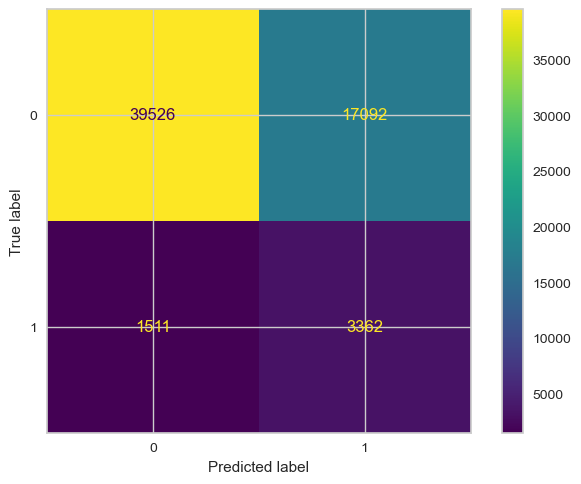

In [47]:
ConfusionMatrixDisplay(confusion_matrix(y_test,lgbm_predict)).plot(values_format='d')


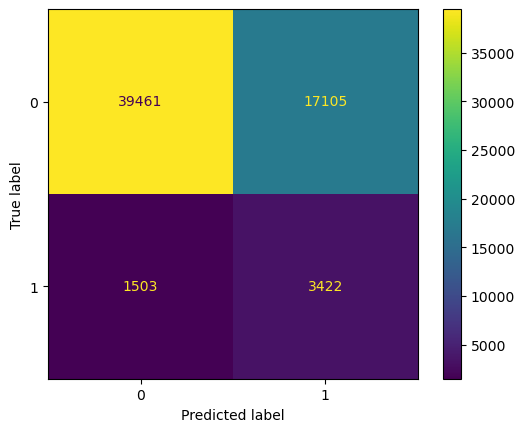

In [49]:
ConfusionMatrixDisplay(confusion_matrix(y_test,lgbm_predict)).plot()

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


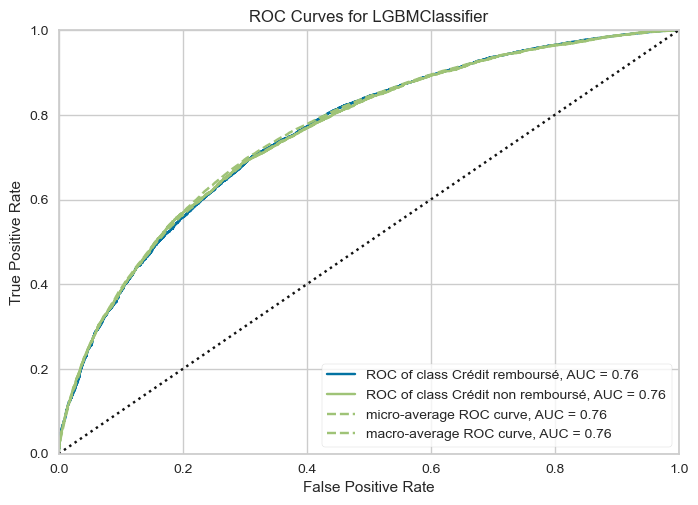

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for LGBMClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       classes=['Crédit remboursé', 'Crédit non remboursé'],
       estimator=Pipeline(steps=[('sampler', RandomUnderSampler()),
                                 ('imputer', SimpleImputer(strategy='median')),
                                 ('scaler', StandardScaler()),
                                 ('estimator',
                                  LGBMClassifier(max_depth=6,
                                                 min_data_in_leaf=500,
                                                 num_leaves=25))]))

In [48]:
from yellowbrick.classifier.rocauc import roc_auc
roc_auc(best_LGBM, X_train, y_train, X_test=X_test, y_test=y_test, classes=['Crédit remboursé', 'Crédit non remboursé'])

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


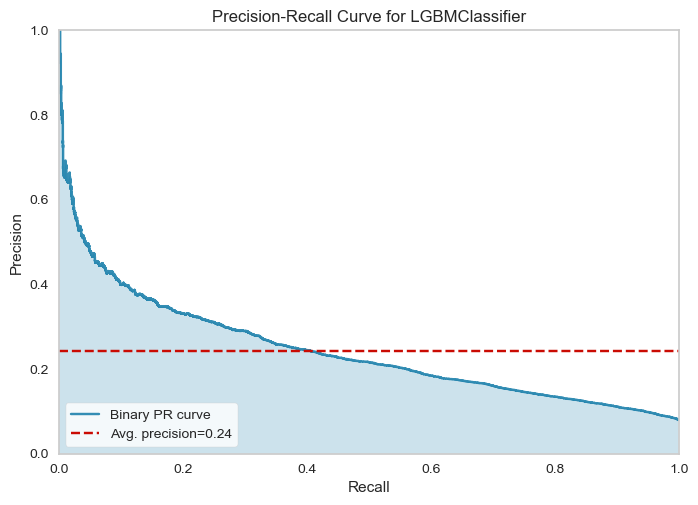

<AxesSubplot:title={'center':'Precision-Recall Curve for LGBMClassifier'}, xlabel='Recall', ylabel='Precision'>

In [49]:
from yellowbrick.classifier import PrecisionRecallCurve
viz = PrecisionRecallCurve(best_LGBM)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

## 8.3 Best LogReg

In [176]:
best_logreg=Pipeline_imb([
    ('sampler',RandomUnderSampler()),
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler()),
    ('estimator',LogisticRegression(C=10, penalty='none'))
])
best_logreg


Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('estimator', LogisticRegression(C=10, penalty='none'))])

In [177]:
best_logreg.fit(X_train,y_train)

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('estimator', LogisticRegression(C=10, penalty='none'))])

In [178]:
logreg_predict=best_logreg.predict(X_test)

In [179]:
print_score(y_test, logreg_predict)

Accuracy score = 0.6837585988193394
Precision score = 0.1575886524822695
Recall score = 0.6717049576783555
F1 score = 0.2552849264705882
ROC AUC score = 0.6782608002317374


In [180]:
my_specificity_score(y_test, logreg_predict)

0.6848166427851191

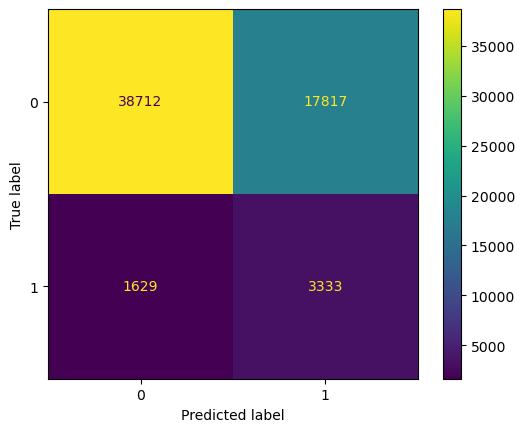

In [181]:
ConfusionMatrixDisplay(confusion_matrix(y_test,logreg_predict)).plot()

## 8.4 Sauvegarde de best_lgbm au format pkl

Pour utilisation dans API

In [50]:
pickle_out = open("best_lgbm2.pkl","wb")
pickle.dump(best_LGBM, pickle_out)
pickle_out.close()

In [15]:
bm= open("best_lgbm2.pkl","rb")
best_LGBM=pd.read_pickle(bm)
best_LGBM

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('estimator',
                 LGBMClassifier(max_depth=6, min_data_in_leaf=500,
                                num_leaves=25))])

In [88]:
### Create a Pickle file using serialization for API (cf part 7, done now in order to get right best_model)

#pickle_out = open("classifier.pkl","wb")
#pickle.dump(best_model, pickle_out)
#pickle_out.close()

# 9 Optimisation du seuil optimal de proba

En considérant que les pertes engendrées par un crédit non remboursé peuvent être diminuées par la revente du bien financé, alors on peut augmenter le suiel à partir duquel l'EC refuse l'octroi du crédit

Quels est ce seuil?

Plusieurs étapes pour y parvenir:

-  Plusieurs essais de défintion du gain ou de la perte par crédit en fonction de y-pred, d'un taux d'interet imaginaire et d'un taux de récuparation appliqué au prix du bien financé,
si le crédit n'est pas remboursé.
=> calcul_gain_gross
- Ajout de la variable seuil 
=> calcul_gain_proba_unit
- Puis fonction permettant d'atblir une grille seuil / gain total pour prêt à dépenser
=> calcul_seuil_optimal

Plusieurs contraintes

- AMNT_GOOD_PRICE nécessaire dans cette fonction mais non utilisée pour prédiction (essai avec drop dans ColumnsTransformer ==> KO)
- Or prédiction nécessaire
- Mais prédiction se basant sur BEST_LGBM qui contient un sampler (RandomUnderSampler) qui diminue la taille du dataset entrainé
=> nécessité de décomposer le modèle (sampler, imputer et scaler avec AMNT_GOOD_PRICE), estimator sans AMNT_GOOD_PRICE 
- Par ailleurs en passant le dataset dans le scaler dans Best_LGBM, les montants deviennent inexploitable
- Le taux d'interet n'est pas connu => à défaulter
- nb d'annuités inconnu => forcé dans un 1er temps (montant du crédit / montant de l'annuité) puis abandonné
- Si un crédit n'est pas remboursé nous ne savons pas si une partie a été remboursée ou non => je considère que rien n'a été remboursé (= perte de tout le capital prêté)

## 9.1 Décomposition et reconstruction de best_LGBM

Sur base Train_V2

In [8]:
train_V2.shape

(307455, 31)

Dans X_tmp, j'inclus AMT_GOODS_PRICE

In [9]:
X_tmp=train_V2.drop(['TARGET','OWN_CAR_AGE','NAME_HOUSING_TYPE','NAME_INCOME_TYPE','NAME_FAMILY_STATUS','NAME_EDUCATION_TYPE'],axis=1)
X_tmp.shape

(307455, 25)

In [10]:
y=train_V2['TARGET']
y.shape

(307455,)

Train test split sur base X_tmp

In [11]:
X_train,X_test,y_train,y_test=train_test_split(X_tmp,y,test_size=0.2)

In [12]:
print('Train set:',X_train.shape)
print('Test set:',X_test.shape)
print('Train target:',y_train.shape)
print('Test target:',y_test.shape)

Train set: (245964, 25)
Test set: (61491, 25)
Train target: (245964,)
Test target: (61491,)


In [14]:
best_LGBM=Pipeline_imb([
    ('sampler',RandomUnderSampler()),
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler()),
    ('estimator',LGBMClassifier(max_depth=6, min_data_in_leaf=500,
                                num_leaves=25))
])
best_LGBM

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('estimator',
                 LGBMClassifier(max_depth=6, min_data_in_leaf=500,
                                num_leaves=25))])

Decomposition du modèle avec fonction créée

In [16]:
def decomposition_modele(modele, X_train=X_train,X_test=X_test,y_train=y_train,):
    '''
    
    ##### Mettre à jour fonctions.py API_V2 #####    
    
    Fonction permettant de décomposer un modèle (pipeline) imbalanced ou non afin de dérouler les différents étapes de preprocessing sans la partie estimator.
    Le but étant de pouvoir gérer la feature importance en conservant le nom des colonnes de X_train
    
    ATTENTION: cette fonction ne fonctionne qu'avec un type précis de pipeline davec les étapes suivantes:
    - le 1er step (non obligatoire) de UnderSampling (uniquement RandomUnderSampler())
    - un ou plusieurs steps de transformation (scaler/imputer)
    - le dernier correspo,d à l'estimateur
    
    Arguments:
    - modele: de type pipeline
    - X_train
    - X_test
    - y_train (necessaire pour le resampling)
    '''
        
    # Si modèle imbalanced:
    
    if str(modele[0]) == 'RandomUnderSampler()':
        
        #Sampling
        
        X_tr, y_train_rus=modele[0].fit_resample(X_train,y_train)
    
        # Preprocessing X_train
    
        X_tr=modele[1:-1].fit_transform(X_tr)
        X_tr_transf=pd.DataFrame(X_tr, columns=X_train.columns)
    
        # Preprocessing X_test
    
        #X_te_transf=modele[1:-1].fit_transform(X_test)
        X_te_transf=modele[1:-1].transform(X_test)
        X_te_transf=pd.DataFrame(X_te_transf, columns=X_train.columns)
        
    else: # si classes équilibrées
        
        y_train_rus = y_train
        X_tr=modele[:-1].fit_transform(X_train)
        X_tr_transf=pd.DataFrame(X_tr, columns=X_train.columns)
    
        # Preprocessing y_train
    
        #X_te_transf=modele[:-1].fit_transform(X_test)
        X_te_transf=modele[:-1].transform(X_test)
        
        X_te_transf=pd.DataFrame(X_te_transf, columns=X_train.columns)
    
       
    return X_tr_transf,X_te_transf, y_train_rus

In [17]:
best_LGBM[0]

RandomUnderSampler()

In [18]:
X_train_rus,X_test_sca,y_train_rus=decomposition_modele(best_LGBM)

rus = RandomUnderSampler

X-train-rus, X_test_sca, et y_train_rus contiennent AMNT GOOD PRICES

In [19]:
print('Train set:',X_train_rus.shape)
print('Test set:',X_test_sca.shape)
print('Train target:',y_train_rus.shape)
print('Test target:',y_test.shape)

Train set: (39648, 25)
Test set: (61491, 25)
Train target: (39648,)
Test target: (61491,)


#### Avant entrainement du modèle, je retire la feat AMT_GOODS_PRICE
- sur X_train-rus 
- sur X_test scalé

In [20]:
X_train_rus=X_train_rus.drop(['AMT_GOODS_PRICE'],axis=1)
X_train_rus

,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,Prev_contract_nb,Prev_AMT_CREDIT,Refused_rate,default_payment,INCOME_CREDIT_PERC,ANNUITY_INCOME_PERC,PAYMENT_RATE,client_age,client_prof_exp,INCOME_PER_PERSON,Cash_loans,GENDER_FEMALE,active_client,relationship
0,0.410584,-0.693386,0.665349,-0.819894,0.850488,0.855954,-0.178935,-0.040855,-0.602257,0.982686,0.295868,-0.278704,-0.656596,-0.424678,-0.906691,2.549276,-0.537520,-0.676289,0.701289,-0.684578,0.295801,0.785094,0.424719,0.612408
1,-0.309978,-0.693386,-1.502970,-0.819894,-0.330144,-0.354136,-1.256619,1.303241,0.533630,0.012208,1.414617,0.661323,1.074478,-0.424678,-0.605212,0.648678,-0.266188,1.093101,-0.843664,-0.018134,0.295801,0.785094,-2.354497,-1.632899
2,-1.056991,-0.693386,0.665349,-1.016537,-0.938348,-1.046046,-1.256619,-0.040855,1.478888,0.050929,-0.822882,-0.522174,-0.038355,-0.424678,-0.230039,-0.067266,0.104012,2.019924,-0.843664,-0.284712,0.295801,0.785094,-2.354497,-1.632899
3,-1.364424,-0.693386,-1.502970,-0.328288,0.850488,0.049227,-1.256619,-0.838379,0.517518,1.071247,1.414617,-0.094935,0.208941,-0.424678,-0.752907,0.214406,-1.093468,-1.181828,0.014643,0.648311,0.295801,0.785094,0.424719,-1.632899
4,0.524136,-0.693386,0.665349,0.654924,0.408753,0.925580,-0.178935,-0.040855,-0.758762,0.659611,-0.822882,-0.522174,1.310533,-0.424678,-0.270559,-0.089269,-0.032776,0.250534,-0.157019,0.315089,0.295801,0.785094,0.424719,0.612408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39643,-0.322028,1.442198,0.665349,-0.426610,-0.938348,-0.275472,-1.256619,-0.040855,1.068679,1.132064,-0.822882,-0.522174,-0.656596,-0.424678,0.508128,0.002678,2.228148,-1.181828,-0.672003,0.515022,0.295801,-1.273733,0.424719,-1.632899
39644,0.123475,-0.693386,0.665349,0.654924,-0.153168,0.049562,0.898750,-1.231392,-0.537711,0.118850,0.136046,0.266192,1.074478,-0.424678,0.113301,-0.639627,-0.071906,-0.929059,-0.672003,-0.240282,0.295801,0.785094,0.424719,0.612408
39645,1.067658,-0.693386,0.665349,-0.721573,-0.090201,0.610253,-0.178935,2.705871,1.402372,-0.311894,0.935153,0.323672,-0.656596,-0.424678,-0.655598,1.792048,0.460326,1.935667,-0.843664,-0.617934,0.295801,0.785094,-2.354497,0.612408
39646,-0.869238,-0.693386,-1.502970,-0.819894,-0.153168,-0.337734,-1.256619,-0.040855,-0.819231,-0.358472,-0.822882,-0.522174,-0.656596,-0.424678,-0.683236,0.674440,-0.532716,1.177357,-0.843664,-0.018134,0.295801,0.785094,-2.354497,-1.632899


In [21]:
X_test_sca=X_test_sca.drop(['AMT_GOODS_PRICE'],axis=1)
X_test_sca

,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,Prev_contract_nb,Prev_AMT_CREDIT,Refused_rate,default_payment,INCOME_CREDIT_PERC,ANNUITY_INCOME_PERC,PAYMENT_RATE,client_age,client_prof_exp,INCOME_PER_PERSON,Cash_loans,GENDER_FEMALE,active_client,relationship
0,-0.186162,1.442198,0.665349,-0.082485,-0.330144,-0.354136,0.898750,-0.040855,-0.266770,1.731374,3.012831,0.359960,0.497453,-0.424678,-0.148426,-0.452699,-0.266188,0.587561,0.701289,-0.573504,0.295801,-1.273733,0.424719,0.612408
1,-0.564762,-0.693386,0.665349,0.900727,0.944939,4.627818,-0.178935,2.632231,-1.327138,0.050929,0.935153,1.396747,0.641709,2.354726,-0.400663,1.858676,1.888095,-0.676289,1.559596,0.481700,0.295801,0.785094,0.424719,0.612408
2,0.343963,1.442198,0.665349,-0.574091,-0.769076,-0.581760,1.976435,1.765137,0.379229,-1.368278,2.533367,3.456782,0.579885,-0.424678,-0.016449,-0.151308,0.525300,-0.929059,1.387934,-0.934495,0.295801,0.785094,0.424719,0.612408
3,-0.025572,-0.693386,-1.502970,-0.819894,1.322741,0.354511,-1.256619,-0.040855,-1.313948,-0.179796,2.053902,-0.136124,0.966286,2.354726,-0.957525,1.761698,-1.150160,-0.929059,-0.500341,-0.018134,0.295801,0.785094,0.424719,-1.632899
4,-1.637843,1.442198,-1.502970,0.015836,2.639324,1.100315,-0.178935,-0.040855,1.437427,0.400641,2.213724,1.070790,-0.656596,2.354726,-0.889116,0.702732,-1.281937,0.924587,-0.500341,-0.118100,0.295801,-1.273733,0.424719,0.612408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61486,1.133790,1.442198,0.665349,1.146529,1.241385,2.170817,-0.178935,-0.040855,1.526181,1.987953,1.254796,1.077249,-0.656596,2.354726,-0.421481,0.257343,-0.035192,1.682897,-0.843664,0.648311,0.295801,0.785094,-2.354497,0.612408
61487,1.669536,-0.693386,0.665349,-0.328288,0.035733,0.269822,0.898750,1.480325,0.719771,-0.946857,0.295868,0.546524,-0.656596,-0.424678,-0.513541,0.445387,-0.133324,-0.592032,-0.500341,-0.684578,0.295801,0.785094,0.424719,0.612408
61488,-0.548634,-0.693386,-1.502970,0.015836,-0.209004,-0.090695,-0.178935,-0.040855,1.096508,1.183375,-0.822882,-0.522174,-0.656596,-0.424678,-0.190487,-0.308420,-0.143583,1.514384,-0.843664,-0.118100,0.295801,-1.273733,-2.354497,0.612408
61489,0.094078,-0.693386,0.665349,-0.328288,-1.210633,-1.130401,-1.256619,0.825793,-1.077330,-1.725545,-0.822882,-0.522174,-0.656596,-0.424678,2.182045,-1.020763,1.863657,0.587561,-0.500341,0.648311,0.295801,0.785094,0.424719,-1.632899


### Entrainement du modèle

In [22]:
EST=best_LGBM[-1]
EST

LGBMClassifier(max_depth=6, min_data_in_leaf=500, num_leaves=25)

In [23]:
#EST=LGBMClassifier(max_depth=3, min_data_in_leaf=500,
#                                num_leaves=20)

In [24]:
EST.fit(X_train_rus, y_train_rus)

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Info] Number of positive: 19824, number of negative: 19824
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3296
[LightGBM] [Info] Number of data points in the train set: 39648, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

LGBMClassifier(max_depth=6, min_data_in_leaf=500, num_leaves=25)

In [25]:
y_pred=EST.predict(X_test_sca)

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


In [26]:
y_pred

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [27]:
y_proba=EST.predict_proba(X_test_sca)
y_proba

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


array([[0.65998831, 0.34001169],
       [0.65667963, 0.34332037],
       [0.60956864, 0.39043136],
       ...,
       [0.74196984, 0.25803016],
       [0.25374115, 0.74625885],
       [0.6530113 , 0.3469887 ]])

In [28]:
y_proba[:,0]

array([0.65998831, 0.65667963, 0.60956864, ..., 0.74196984, 0.25374115,
       0.6530113 ])

In [152]:
#y_proba[:,1]

In [29]:
np.unique(y_pred, return_counts=True)

(array([0, 1], dtype=int64), array([40588, 20903], dtype=int64))

In [30]:
print_score(y_test, y_pred)

Accuracy score = 0.6902636158136963
Precision score = 0.16389991867196096
Recall score = 0.6858858858858858
F1 score = 0.2645764151671944
ROC AUC score = 0.6882682757098645


In [31]:
my_specificity_score(y_test,y_pred)

0.6906506655338431

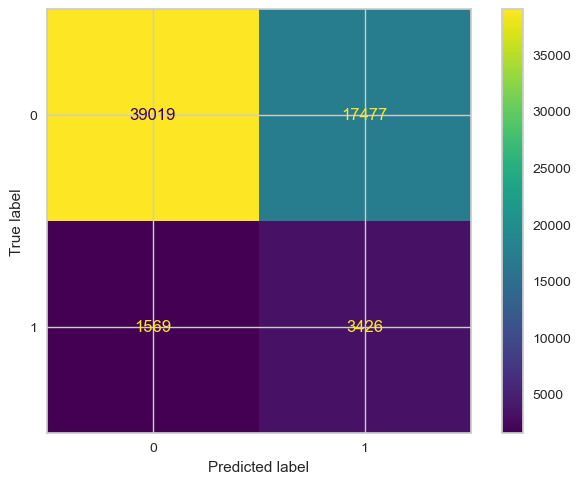

In [32]:
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot()

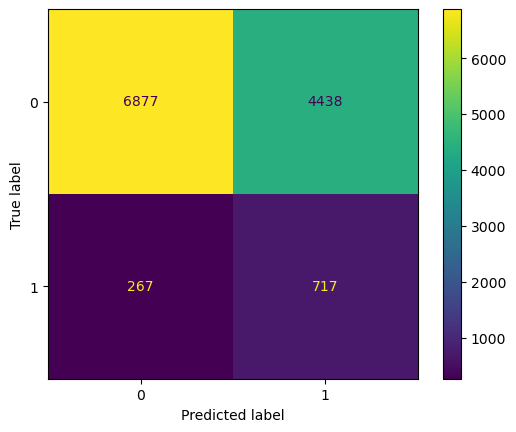

In [34]:
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot()

In [33]:
y_pred

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

### Reconstituion du df X_test avec:
- AMNT_GOODS_PRICE (note  du 22/02/24: AMNT8GOOD_PRICE n'a pa sété retiré de X_test mais de X_te_SCA)
- y_true => y_test
- y_pred => colonne prédictions
- y_proba => en 2 colonnes proba_0 et proba_1 ou une seule colonne sachant que proba_1=1 - proba_0


Ici copier d'abord y_test

In [34]:
X_test['y_true']=y_test
X_test

,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,Prev_contract_nb,Prev_AMT_CREDIT,Refused_rate,default_payment,INCOME_CREDIT_PERC,ANNUITY_INCOME_PERC,PAYMENT_RATE,client_age,client_prof_exp,INCOME_PER_PERSON,Cash_loans,GENDER_FEMALE,active_client,relationship,y_true
137148,259094,1,1,157500.0,454500.0,21996.0,454500.0,3.0,NaN,0.411834,0.780144,24.0,2.542698e+06,0.266667,0.0,0.346535,0.139657,0.048396,49,9.0,52500.0,1,0,1,1,0
103627,220291,0,1,247500.0,935640.0,88969.5,900000.0,2.0,0.811282,0.191526,NaN,11.0,5.531175e+06,0.300000,1.0,0.264525,0.359473,0.095089,34,14.0,123750.0,1,1,1,1,0
184095,313427,1,1,112500.0,288873.0,18936.0,238500.0,4.0,0.689873,0.546050,0.205598,21.0,1.146910e+07,0.285714,0.0,0.389444,0.168320,0.065551,31,13.0,28125.0,1,1,1,1,0
151420,275553,0,0,90000.0,1078200.0,31522.5,900000.0,1.0,NaN,0.194266,0.425893,18.0,1.112767e+06,0.375000,1.0,0.083472,0.350250,0.029236,31,2.0,90000.0,1,1,1,0,0
8867,110310,1,0,166500.0,1575000.0,41548.5,1575000.0,2.0,NaN,0.765907,0.533482,19.0,4.591624e+06,0.000000,1.0,0.105714,0.249541,0.026380,53,2.0,83250.0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254342,394377,1,1,270000.0,1047501.0,55939.5,990000.0,2.0,NaN,0.784347,0.827703,13.0,4.610241e+06,0.000000,1.0,0.257756,0.207183,0.053403,62,-0.0,135000.0,1,1,0,1,0
301437,449286,0,1,135000.0,592560.0,30384.0,450000.0,3.0,0.649995,0.616803,0.283712,7.0,3.080457e+06,0.000000,0.0,0.227825,0.225067,0.051276,35,2.0,45000.0,1,1,1,1,0
105068,221944,0,0,166500.0,500211.0,25537.5,463500.0,2.0,NaN,0.695075,0.678568,0.0,0.000000e+00,0.000000,0.0,0.332860,0.153378,0.051053,60,-0.0,83250.0,1,0,0,1,0
161980,287816,0,1,135000.0,122256.0,11560.5,108000.0,1.0,0.558348,0.243427,0.139376,0.0,0.000000e+00,0.000000,0.0,1.104240,0.085633,0.094560,49,2.0,135000.0,1,1,1,0,1


In [35]:
X_test['predictions']=y_pred
X_test

,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,Prev_contract_nb,Prev_AMT_CREDIT,Refused_rate,default_payment,INCOME_CREDIT_PERC,ANNUITY_INCOME_PERC,PAYMENT_RATE,client_age,client_prof_exp,INCOME_PER_PERSON,Cash_loans,GENDER_FEMALE,active_client,relationship,y_true,predictions
137148,259094,1,1,157500.0,454500.0,21996.0,454500.0,3.0,NaN,0.411834,0.780144,24.0,2.542698e+06,0.266667,0.0,0.346535,0.139657,0.048396,49,9.0,52500.0,1,0,1,1,0,0
103627,220291,0,1,247500.0,935640.0,88969.5,900000.0,2.0,0.811282,0.191526,NaN,11.0,5.531175e+06,0.300000,1.0,0.264525,0.359473,0.095089,34,14.0,123750.0,1,1,1,1,0,0
184095,313427,1,1,112500.0,288873.0,18936.0,238500.0,4.0,0.689873,0.546050,0.205598,21.0,1.146910e+07,0.285714,0.0,0.389444,0.168320,0.065551,31,13.0,28125.0,1,1,1,1,0,0
151420,275553,0,0,90000.0,1078200.0,31522.5,900000.0,1.0,NaN,0.194266,0.425893,18.0,1.112767e+06,0.375000,1.0,0.083472,0.350250,0.029236,31,2.0,90000.0,1,1,1,0,0,1
8867,110310,1,0,166500.0,1575000.0,41548.5,1575000.0,2.0,NaN,0.765907,0.533482,19.0,4.591624e+06,0.000000,1.0,0.105714,0.249541,0.026380,53,2.0,83250.0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254342,394377,1,1,270000.0,1047501.0,55939.5,990000.0,2.0,NaN,0.784347,0.827703,13.0,4.610241e+06,0.000000,1.0,0.257756,0.207183,0.053403,62,-0.0,135000.0,1,1,0,1,0,0
301437,449286,0,1,135000.0,592560.0,30384.0,450000.0,3.0,0.649995,0.616803,0.283712,7.0,3.080457e+06,0.000000,0.0,0.227825,0.225067,0.051276,35,2.0,45000.0,1,1,1,1,0,0
105068,221944,0,0,166500.0,500211.0,25537.5,463500.0,2.0,NaN,0.695075,0.678568,0.0,0.000000e+00,0.000000,0.0,0.332860,0.153378,0.051053,60,-0.0,83250.0,1,0,0,1,0,0
161980,287816,0,1,135000.0,122256.0,11560.5,108000.0,1.0,0.558348,0.243427,0.139376,0.0,0.000000e+00,0.000000,0.0,1.104240,0.085633,0.094560,49,2.0,135000.0,1,1,1,0,1,1


In [36]:
X_test['proba_0']=y_proba[:,0]
X_test

,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,Prev_contract_nb,Prev_AMT_CREDIT,Refused_rate,default_payment,INCOME_CREDIT_PERC,ANNUITY_INCOME_PERC,PAYMENT_RATE,client_age,client_prof_exp,INCOME_PER_PERSON,Cash_loans,GENDER_FEMALE,active_client,relationship,y_true,predictions,proba_0
137148,259094,1,1,157500.0,454500.0,21996.0,454500.0,3.0,NaN,0.411834,0.780144,24.0,2.542698e+06,0.266667,0.0,0.346535,0.139657,0.048396,49,9.0,52500.0,1,0,1,1,0,0,0.659988
103627,220291,0,1,247500.0,935640.0,88969.5,900000.0,2.0,0.811282,0.191526,NaN,11.0,5.531175e+06,0.300000,1.0,0.264525,0.359473,0.095089,34,14.0,123750.0,1,1,1,1,0,0,0.656680
184095,313427,1,1,112500.0,288873.0,18936.0,238500.0,4.0,0.689873,0.546050,0.205598,21.0,1.146910e+07,0.285714,0.0,0.389444,0.168320,0.065551,31,13.0,28125.0,1,1,1,1,0,0,0.609569
151420,275553,0,0,90000.0,1078200.0,31522.5,900000.0,1.0,NaN,0.194266,0.425893,18.0,1.112767e+06,0.375000,1.0,0.083472,0.350250,0.029236,31,2.0,90000.0,1,1,1,0,0,1,0.282221
8867,110310,1,0,166500.0,1575000.0,41548.5,1575000.0,2.0,NaN,0.765907,0.533482,19.0,4.591624e+06,0.000000,1.0,0.105714,0.249541,0.026380,53,2.0,83250.0,1,0,1,1,0,0,0.825407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254342,394377,1,1,270000.0,1047501.0,55939.5,990000.0,2.0,NaN,0.784347,0.827703,13.0,4.610241e+06,0.000000,1.0,0.257756,0.207183,0.053403,62,-0.0,135000.0,1,1,0,1,0,0,0.839411
301437,449286,0,1,135000.0,592560.0,30384.0,450000.0,3.0,0.649995,0.616803,0.283712,7.0,3.080457e+06,0.000000,0.0,0.227825,0.225067,0.051276,35,2.0,45000.0,1,1,1,1,0,0,0.571443
105068,221944,0,0,166500.0,500211.0,25537.5,463500.0,2.0,NaN,0.695075,0.678568,0.0,0.000000e+00,0.000000,0.0,0.332860,0.153378,0.051053,60,-0.0,83250.0,1,0,0,1,0,0,0.741970
161980,287816,0,1,135000.0,122256.0,11560.5,108000.0,1.0,0.558348,0.243427,0.139376,0.0,0.000000e+00,0.000000,0.0,1.104240,0.085633,0.094560,49,2.0,135000.0,1,1,1,0,1,1,0.253741


Ajout de la colonne nb d'annuité qui va nosu permettre de calculer le montant d'interet gagné ou perdu

In [37]:
X_test['nb_annuité']=round(X_test['AMT_CREDIT']/X_test['AMT_ANNUITY'],0)
X_test['nb_annuité'].describe()

count    61491.000000
mean        21.642777
std          7.827039
min          8.000000
25%         16.000000
50%         20.000000
75%         27.000000
max         45.000000
Name: nb_annuité, dtype: float64

In [163]:
X_test.loc[(X_test['y_true']==0) & (X_test['predictions']==1),:].head()

,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,Prev_contract_nb,Prev_AMT_CREDIT,Refused_rate,default_payment,INCOME_CREDIT_PERC,ANNUITY_INCOME_PERC,PAYMENT_RATE,client_age,client_prof_exp,INCOME_PER_PERSON,Cash_loans,GENDER_FEMALE,active_client,relationship,y_true,predictions,proba_0,nb_annuité
119861,239012,0,1,256500.0,383089.5,30397.5,346500.0,2.0,NaN,0.706524,0.215182,0.0,0.0,0.666667,0.0,0.669556,0.118509,0.079348,53,-0.0,128250.0,1,1,0,1,0,1,0.338468,13.0
219808,354696,0,1,112500.0,269550.0,18760.5,225000.0,1.0,NaN,0.451787,0.000527,0.0,0.0,0.000000,0.0,0.417362,0.166760,0.069599,66,-0.0,112500.0,1,1,0,0,0,1,0.333625,14.0
65497,175972,0,1,180000.0,490495.5,30136.5,454500.0,5.0,0.326813,0.606273,NaN,0.0,0.0,0.000000,0.0,0.366976,0.167425,0.061441,36,4.0,36000.0,1,0,1,1,0,1,0.380472,16.0
193862,324845,0,1,90000.0,247275.0,17586.0,225000.0,2.0,NaN,0.338567,NaN,0.0,0.0,0.000000,0.0,0.363967,0.195400,0.071119,47,1.0,45000.0,1,1,1,1,0,1,0.422413,14.0
204447,337067,1,1,180000.0,390960.0,23755.5,337500.0,2.0,NaN,0.355231,0.531686,16.0,3655359.0,0.615385,0.0,0.460405,0.131975,0.060762,48,6.0,90000.0,1,0,1,1,0,1,0.330524,16.0


X_test_2 ci dessous permet de remettre l'index à 0. 
- Plus facile pour tester les différentes fonction de calcul de gain

In [164]:
X_test_2=X_test.copy()

In [165]:
X_test_2.reset_index(inplace=True)

In [166]:
X_test_2.loc[(X_test_2['y_true']==0) & (X_test_2['predictions']==0),:].head()

,index,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,Prev_contract_nb,Prev_AMT_CREDIT,Refused_rate,default_payment,INCOME_CREDIT_PERC,ANNUITY_INCOME_PERC,PAYMENT_RATE,client_age,client_prof_exp,INCOME_PER_PERSON,Cash_loans,GENDER_FEMALE,active_client,relationship,y_true,predictions,proba_0,nb_annuité
1,45185,152343,0,1,72000.0,104481.0,10836.0,94500.0,1.0,0.616734,0.557774,0.554947,5.0,594787.5,0.000000,0.0,0.689121,0.150500,0.103713,57,-0.0,72000.0,1,1,0,0,0,0,0.890592,10.0
2,18325,121378,0,1,90000.0,675000.0,26901.0,675000.0,2.0,NaN,0.690603,NaN,0.0,0.0,0.000000,0.0,0.133333,0.298900,0.039853,41,4.0,45000.0,1,1,1,1,0,0,0.593539,25.0
3,187090,316927,0,1,99000.0,900000.0,46084.5,900000.0,3.0,0.476999,0.535482,0.486653,6.0,1008864.0,0.000000,0.0,0.110000,0.465500,0.051205,28,9.0,33000.0,1,1,1,1,0,0,0.544154,20.0
4,137030,258958,0,1,90000.0,215640.0,9265.5,180000.0,2.0,0.898895,0.599913,0.576209,17.0,1551761.1,0.166667,1.0,0.417362,0.102950,0.042967,62,38.0,45000.0,1,1,1,1,0,0,0.882745,23.0
6,77392,189746,1,1,247500.0,405000.0,42970.5,405000.0,4.0,NaN,0.604926,0.499272,0.0,0.0,0.000000,0.0,0.611111,0.173618,0.106100,37,6.0,61875.0,1,0,1,1,0,0,0.728776,9.0


## 9.2 Fonctions permettant de calculer le P/L par crédit puis sur l'ensemble du dataset

Ci dessous plusiseurs hypothèses:

1. Dans un 1er calcul prise en compte du manque à gagner (Faux positif) et de perte qui aurait dû être évitées (Faux négatif) => abandonné pour simplifiaction
2. en considérant ou non que les interets ne sont perçus qu'une année ou sur l'ensembel de la durée de vie du crédit => une seule annuité retenue pour simplification

Reflexion sur les différents cas de figure:

- Si y-pred = y_true = 0 => gain= interêts perçus sur le crédit = M * i * n
    
    M= Montant du crédit ;    
    i = taux d'interêt ;    
    n = nb d'année;
        
    Mais pas de gain par rapport à la situation sans modèle de prédiction
    

- Si y-pred = y_true = 1 => Si on considère que le prêt a été accordé à tort dans la réalité et que grace à notre modèle on n'octroie pas le crédit, le gain est une perte évitée soit:

    Montant du crédit moins revente du produit financé (moins décôte de 30%) => M-(30% * PP)

- Si y_pred =1 et y_true= 0 => Faux négatif: montant non accordé à tort: Manque à gagner (perte) = M * i * n

- SI y_pred = 0 et y_true =1 => Faux positif: montant accordé à tort: Perte = Montant du crédit - revente du bien acheté (avec décote de 30% par ex) => M-(30% * PP)

Rappel:  les NaN sur AMNT_GOODS_PRICE ont été défaultés avec le montant du crédit associé (cf nobe explo/transfo: les seuls NaN sont sur des crédits revolving pour lesquels dans la plupart des cas le montant de crédit est égal au prix du bien financé)

In [102]:
def calcul_gain_unit(ser, lost_coeff =0.3, taux=0.05): #y_true, y_pred
    
    '''Le but de cette fonction est de calculer le différentiel de gain grâce au modèle de prédiction comparé à la réalisation dans la vraie vie'''
        
    if ser['predictions']: # ==1 , pas de prêt
        if ser['y_true']: #==1; on ne perd plus d'argent grace au modèle de prédiction: gain
            return round(ser['AMT_CREDIT']-lost_coeff*ser['AMT_GOODS_PRICE'],2)
        else: # y_true = 0: on a refusé le crédit à tort: manque à gagner = interets non perçus = M*i*n (interets simples)
            return round(-(ser['AMT_CREDIT']*taux*ser['nb_annuité']),2)
    if not ser['predictions']: #==0, prêt accordé (pas de différence avec la réalité)
        return 0 
        #if y_true: #==1, prêt non remboursé, donc prêt accordé à tort=> perte = M-(30% * PP)
        #    return -(ser['AMT_CREDIT']-lost_coeff*ser['AMT_GOODS_PRICE'])
        #elif: # y_true = 0 pas de différence : le gain est le même avec et sans modèle de prédiction
        #    return 0
        
            
        

In [103]:
def calcul_gain_unit_1an(ser, lost_coeff =0.3, taux=0.05): #y_true, y_pred
    
    '''Variante de la fn calcul_gain_unit où l'on considère une seule annuité'''
        
    if ser['predictions']: # ==1 , pas de prêt
        if ser['y_true']: #==1; on ne perd plus d'argent grace au modèle de prédiction: gain
            return round(ser['AMT_CREDIT']-lost_coeff*ser['AMT_GOODS_PRICE'],2)
        else: # y_true = 0: on a refusé le crédit à tort: manque à gagner = interets non perçus = M*i*n (interets simples)
            return round(-(ser['AMT_CREDIT']*taux),2)
    if not ser['predictions']: #==0, prêt accordé (pas de différence avec la réalité)
        return 0 

Test fonction calcul_gain_unit

In [104]:
X_test.iloc[19].T

SK_ID_CURR             301444.000000
FLAG_OWN_CAR                1.000000
FLAG_OWN_REALTY             0.000000
AMT_INCOME_TOTAL       112500.000000
AMT_CREDIT             468000.000000
AMT_ANNUITY             12870.000000
AMT_GOODS_PRICE        468000.000000
CNT_FAM_MEMBERS             2.000000
EXT_SOURCE_1                     NaN
EXT_SOURCE_2                0.513720
EXT_SOURCE_3                0.616122
Prev_contract_nb            0.000000
Prev_AMT_CREDIT             0.000000
Refused_rate                0.000000
default_payment             0.000000
INCOME_CREDIT_PERC          0.240385
ANNUITY_INCOME_PERC         0.114400
PAYMENT_RATE                0.027500
client_age                 33.000000
client_prof_exp             0.000000
INCOME_PER_PERSON       56250.000000
Cash_loans                  1.000000
GENDER_FEMALE               0.000000
active_client               1.000000
relationship                1.000000
y_true                      0.000000
predictions                 0.000000
p

In [105]:
calcul_gain_unit(X_test.iloc[19].T)

0

In [106]:
def calcul_gain_total(df):
    df['Gain']=0
    for i in range(len(df)):
        #calcul_gain_unit(df.iloc[i].T)
        df['Gain'].iloc[i]=calcul_gain_unit(df.iloc[i].T)
    return round(df['Gain'].sum(),2)

Test fonction calcul_gain_total

In [107]:
calcul_gain_total(X_test)

-9545137925.5

Montant très négatif. Expliqué par:

- taux de récup et règle basée sur nb d'annuités 
- par le fait que l'on n'a pas les crédits refusés dans la réalité et qui auraient été octroyés grâce au modèle

Si 1 seule annuité

In [108]:
def calcul_gain_total_1an(df):
    df['Gain']=0
    for i in range(len(df)):
        #calcul_gain_unit(df.iloc[i].T)
        df['Gain'].iloc[i]=calcul_gain_unit_1an(df.iloc[i].T)
    return round(df['Gain'].sum(),2)

In [109]:
calcul_gain_total_1an(X_test)

875832638.43

Cette fois on gagne

### 9.2.1 Version alternative

pour un crédit donné, calcul du gain ou de la perte, en focntion de la prédictions. Pas de notion de perte évitée ou de manque à gagner

In [110]:
def calcul_gain_gross(ser, lost_coeff =0.3, taux=0.05): #y_true, y_pred
    
    if ser['predictions']:
        return 0
    
    if not ser['y_true']: # == 0 > prêt accordé et remboursé: gains = interets
        return round(ser['AMT_CREDIT']*taux*ser['nb_annuité'],2)
    
    if ser['y_true']: # ==1 prêt accordé à tort : perte K  - vente des biens
        return round(-ser['AMT_CREDIT']-lost_coeff * ser['AMT_GOODS_PRICE'],2)

Test de la fn calcul_gain_gross

In [111]:
calcul_gain_gross(X_test.iloc[19].T)

842400.0

In [112]:
X_test.iloc[0].T

SK_ID_CURR             2.852400e+05
FLAG_OWN_CAR           1.000000e+00
FLAG_OWN_REALTY        1.000000e+00
AMT_INCOME_TOTAL       1.440000e+05
AMT_CREDIT             5.212800e+05
AMT_ANNUITY            3.163050e+04
AMT_GOODS_PRICE        4.500000e+05
CNT_FAM_MEMBERS        2.000000e+00
EXT_SOURCE_1           2.759033e-01
EXT_SOURCE_2           7.317655e-01
EXT_SOURCE_3           6.848277e-01
Prev_contract_nb       8.000000e+00
Prev_AMT_CREDIT        1.374210e+06
Refused_rate           2.500000e-01
default_payment        1.000000e+00
INCOME_CREDIT_PERC     2.762431e-01
ANNUITY_INCOME_PERC    2.196562e-01
PAYMENT_RATE           6.067852e-02
client_age             3.400000e+01
client_prof_exp        1.000000e+00
INCOME_PER_PERSON      7.200000e+04
Cash_loans             1.000000e+00
GENDER_FEMALE          1.000000e+00
active_client          1.000000e+00
relationship           1.000000e+00
y_true                 0.000000e+00
predictions            0.000000e+00
proba_0                5.726

In [113]:
calcul_gain_gross(X_test.iloc[0].T)

417024.0

In [114]:
def calcul_gain_total_1an(df):
    df['Gain']=0
    for i in range(len(df)):
        #calcul_gain_unit(df.iloc[i].T)
        df['Gain'].iloc[i]=calcul_gain_unit_1an(df.iloc[i].T)
    return round(df['Gain'].sum(),2)

In [115]:
def calcul_gain_gross_total(df):
    gain=[]
    gain_total = 0
    for i in range(len(df)):
        gain.append(calcul_gain_gross(df.iloc[i].T))
        
        #df['Gain_net'].iloc[i]=calcul_gain_unit(df.iloc[i].T)
        gain_total+=gain[i]
    return round(gain_total,2)

In [116]:
calcul_gain_gross_total(X_test)

30718895914.2

## 9.3 Optimisation du seuil optimal

In [117]:
def calcul_gain_proba_unit(ser,seuil=0.50, lost_coeff =0.3, taux=0.05):
    
    """Fonction permettant de calculer le gain ou la perte attendus sur un prêt accordé selon qu'il ait été remboursé ou non
    
    ##### METTRE A JOUR fonctions.py de API_V2 #####
    
    
    Args:
    - ser: serie Pandas => colonne 'probe_0' du dataset 
    - seuil: par défaut = 0.5 (seuil de base pour définri la classe 0 ou 1 d'une prédiction)
    -lost_coeff: estimation du taux de revente d'un bien financé par le crédit (utilisé en cas d'impayé)
    - taux: taux d'intéret du crédit
        
    """
    if ser['proba_0'] < seuil:
        return 0    
            
    #if ser['predictions']:
    #    return 0
    
    
    
    if not ser['y_true']: # == 0 > prêt accordé et remboursé: gains = interets
        #Version où les interets sont perçus sur toutes les annuités
        #return round(ser['AMT_CREDIT']*taux*ser['nb_annuité'],2)
        
        #Version où l'on ne perçoit les int qu'une seule fois
        return round(ser['AMT_CREDIT']*taux,2)
    
    if ser['y_true']: # ==1 prêt accordé à tort : perte K  - vente des biens
        return round(-ser['AMT_CREDIT']-lost_coeff * ser['AMT_GOODS_PRICE'],2)

In [168]:
X_test_2.loc[(X_test_2['y_true']==0) & (X_test_2['predictions']==1),:].head()

,index,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,Prev_contract_nb,Prev_AMT_CREDIT,Refused_rate,default_payment,INCOME_CREDIT_PERC,ANNUITY_INCOME_PERC,PAYMENT_RATE,client_age,client_prof_exp,INCOME_PER_PERSON,Cash_loans,GENDER_FEMALE,active_client,relationship,y_true,predictions,proba_0,nb_annuité
5,119861,239012,0,1,256500.0,383089.5,30397.5,346500.0,2.0,NaN,0.706524,0.215182,0.0,0.0,0.666667,0.0,0.669556,0.118509,0.079348,53,-0.0,128250.0,1,1,0,1,0,1,0.338468,13.0
9,219808,354696,0,1,112500.0,269550.0,18760.5,225000.0,1.0,NaN,0.451787,0.000527,0.0,0.0,0.000000,0.0,0.417362,0.166760,0.069599,66,-0.0,112500.0,1,1,0,0,0,1,0.333625,14.0
13,65497,175972,0,1,180000.0,490495.5,30136.5,454500.0,5.0,0.326813,0.606273,NaN,0.0,0.0,0.000000,0.0,0.366976,0.167425,0.061441,36,4.0,36000.0,1,0,1,1,0,1,0.380472,16.0
14,193862,324845,0,1,90000.0,247275.0,17586.0,225000.0,2.0,NaN,0.338567,NaN,0.0,0.0,0.000000,0.0,0.363967,0.195400,0.071119,47,1.0,45000.0,1,1,1,1,0,1,0.422413,14.0
18,204447,337067,1,1,180000.0,390960.0,23755.5,337500.0,2.0,NaN,0.355231,0.531686,16.0,3655359.0,0.615385,0.0,0.460405,0.131975,0.060762,48,6.0,90000.0,1,0,1,1,0,1,0.330524,16.0


In [169]:
X_test_2.iloc[5].T

index                  119861.000000
SK_ID_CURR             239012.000000
FLAG_OWN_CAR                0.000000
FLAG_OWN_REALTY             1.000000
AMT_INCOME_TOTAL       256500.000000
AMT_CREDIT             383089.500000
AMT_ANNUITY             30397.500000
AMT_GOODS_PRICE        346500.000000
CNT_FAM_MEMBERS             2.000000
EXT_SOURCE_1                     NaN
EXT_SOURCE_2                0.706524
EXT_SOURCE_3                0.215182
Prev_contract_nb            0.000000
Prev_AMT_CREDIT             0.000000
Refused_rate                0.666667
default_payment             0.000000
INCOME_CREDIT_PERC          0.669556
ANNUITY_INCOME_PERC         0.118509
PAYMENT_RATE                0.079348
client_age                 53.000000
client_prof_exp            -0.000000
INCOME_PER_PERSON      128250.000000
Cash_loans                  1.000000
GENDER_FEMALE               1.000000
active_client               0.000000
relationship                1.000000
y_true                      0.000000
p

In [175]:
for i in [0.2,0.3,0.4]:
    print(f'gain ={calcul_gain_proba_unit(X_test.iloc[5].T,seuil=i)}')

gain =19154.48
gain =19154.48
gain =0


In [184]:
range(len(np.arange(0,1.05,0.05)))

range(0, 21)

In [185]:
def calcul_seuil_optimal(df):
    
    """ Fonction renvoyant un DataFrame renvoyant pour une série (entre 0 et 1), le gain total attendu.
    DataFrame utilisé pour définir le seuil optimal à partir duquel on considère que le prêt, qu'il ait été accordé ou non, rapportera de l'argent
    Dépend de la fonction calcul_gain_proba_unit définie + haut
    
    ##### METTRE A JOUR fonctions.py de API_V2? #####

    Arg:    
    df: contenant ['proba_0'] (predict proba 0)
    
    """
    
    best_thresh=pd.DataFrame(columns=['threshold','Gain_total'])
    #global best_thresh
    
    for thr,j in zip(np.arange(0,1.05,0.05),range(len(np.arange(0,1.05,0.05)))): 
        gain=[]
        gain_total = 0
        
        for i in range(len(df)):
            gain.append(calcul_gain_proba_unit(df.iloc[i].T,thr,taux=0.04,lost_coeff=0.3))
            gain_total+=gain[i]
        
        tmp=pd.DataFrame([[round(thr,2),gain_total]],columns=['threshold','Gain_total'])
        
        best_thresh=pd.concat([best_thresh,tmp],axis=0,ignore_index=True)
        
    return best_thresh #gain_total

In [186]:
thresh=calcul_seuil_optimal(X_test)
thresh

,threshold,Gain_total
0,0.00,-2.165771e+09
1,0.05,-2.165771e+09
2,0.10,-2.111915e+09
3,0.15,-1.922999e+09
4,0.20,-1.670030e+09
5,0.25,-1.414079e+09
6,0.30,-1.157116e+09
7,0.35,-9.060685e+08
8,0.40,-6.705026e+08
9,0.45,-4.495065e+08


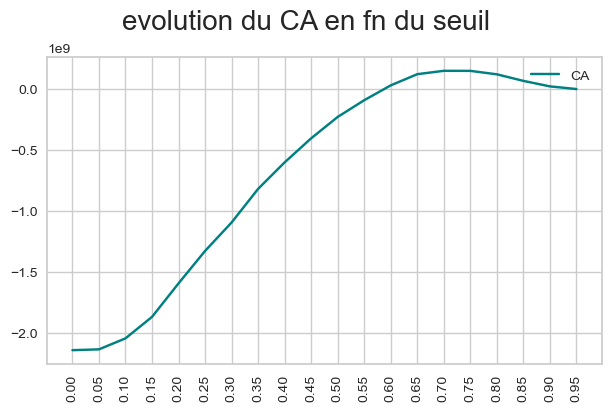

In [125]:
fig = plt.figure(figsize=(6,4),constrained_layout = True)
plt.plot(thresh['threshold'],thresh['Gain_total'], color='teal', label='CA')
#plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
listOf_Xticks = thresh['threshold']
plt.xticks(listOf_Xticks,rotation='vertical')
fig.suptitle('evolution du CA en fn du seuil', fontsize=20)
plt.legend(loc="upper right")
plt.show()

In [ ]:
thresh['Gain_total'].max()

150899057.45999753

In [ ]:
thresh.loc[thresh['Gain_total']==thresh['Gain_total'].max(),:]

,threshold,Gain_total
14,0.7,1.508991e+08


#### Vérification calcul:

In [194]:
X_test.shape

(61491, 29)

In [196]:
X_test.loc[X_test['y_true']==0].shape

(56439, 29)

In [197]:
X_test.loc[X_test['y_true']==1].shape

(5052, 29)

In [198]:
X_test.loc[(X_test['y_true']==0),'AMT_CREDIT'].sum()*0.04#-X_test.loc[(X_test['y_true']==1),'AMT_GOODS_PRICE'].sum()*0.3

1359473725.26

In [200]:
tmp= X_test.loc[(X_test['y_true']==1),['AMT_GOODS_PRICE','AMT_CREDIT']]

In [201]:
tmp['AMT_CREDIT'].sum()-0.3*(tmp['AMT_GOODS_PRICE'].sum())

2058062407.65

In [202]:
X_test.loc[(X_test['y_true']==0),'AMT_CREDIT'].sum()*0.04 - tmp['AMT_CREDIT'].sum()-0.3*(tmp['AMT_GOODS_PRICE'].sum())

-2165770953.09

In [203]:
thresh.loc[thresh['Gain_total']==thresh['Gain_total'].min(),:]

,threshold,Gain_total
0,0.00,-2.165771e+09
1,0.05,-2.165771e+09


### Conclusion

Seuil opptimal = 0.7

Point d'amélioration: inclure le calcul du gain max dans la comparaison entre les modèles

# 10 Préparation df pour API

X_test (données sur lesquelles le modèle n'est pas entrainé) duquel je retire les colonnes ajoutées:
- 'y_true',
- 'predictions',
- 'proba_0',
- 'nb_annuité',
- 'Gain'

In [38]:
X_test=X_test.drop(['y_true','predictions','proba_0','nb_annuité'],axis=1)
X_test.shape

(61491, 25)

## Modification des entêtes de colonnes pour meilleure lecture dans dashboard

N/A pour le moment: sera géré dans le dashboard via un expander d'explication

## Serialisation pour API

Serialisation depuis pd.to_picle()

In [39]:
X_test.to_pickle("./data2pkl_V2.pkl")

In [40]:
X_test.to_csv('C:/Users/xavie/P7/P7_API/data_sample_V2.csv', index=False)